In [21]:
import re
import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import KFold, train_test_split
import optuna.integration.lightgbm as lgb

In [22]:
all_new = pd.read_csv('data/all_nlp_preprocessed.csv')
bert_embeded = pd.read_csv('kaggle-notebook/data/bert_embeded_pretrained_cat2.csv')
tfidf_500 = pd.read_csv('data/tfidf_500.csv')
tfidf_1000 = pd.read_csv('data/tfidf_1000.csv')
tfidf_2000 = pd.read_csv('data/tfidf_2000.csv')
mfw_df = pd.read_csv('data/mfw.csv')
sub = pd.read_csv('data/sample_submit.csv')

In [23]:
all_new = pd.merge(all_new, bert_embeded, on="id", how='outer')
all_new = pd.merge(all_new, tfidf_1000, on="id", how="outer")
all_new = pd.merge(all_new, mfw_df, on="id", how="outer")

In [24]:
all_new[[f"{n+50}" for n in range(25)]] = np.array(all_new[[f"{n}" for n in range(25)]]) + np.array(all_new[[f"{n+25}" for n in range(25)]])

In [25]:
len(all_new.index.unique())

21089

In [26]:
class PseudoLabeler(object):
    def __init__(self, estimater, params, categorical_cols, taregt_cols):
        self.estimater = estimater
        self.params = params
        self.categorical_cols = categorical_cols
        self.target_cols = target_cols
    
    def pseudo_labeling(self, X_train, y_train, X_test, max_iter=100, th_confidence=0.95, fit_params=None):
        """
        Extract test data with enough confidence and conduct pseudo-labeling.
        
        -----Parameters-----
        X_train:       Features of training data. Pandas DataFrame is expected
        y_train:       Target of training data. Pandas DataFrame is expected.
        X_test:        Features of test data. Pandas DataFrame is expected.
        max_iter:      Maximun number for iteration of pseudo-labeling. int is expected.
        th_confidence: Threshold of the confidence. float is expected.
        fit_params:    Parameters for "fit" method. dict is expected.
        
        -----Returns-----
        X_conf:        Features of test data with enough confidence.
        y_conf:        Target of test data. Because they have enough confidence, you can treat them as data with response==1.
        """

        continue_ = 1
        X_conf = DataFrame()
        y_conf = DataFrame()
        
        y_train = DataFrame(y_train) # Although y_train is expected to be a DataFrame, we tends to input a Series for it.
        cv = KFold(n_splits=5, shuffle=True, random_state=2020)

        for iter_ in range(max_iter):
            if continue_ > 0:
                if iter_ > 0:
                    X = pd.concat([X_train, X_conf], axis=0)
                    y = pd.concat([y_train, y_conf], axis=0)
                    
                if iter_ == 0:
                    X = X_train
                    y = y_train
                    
                train_index, val_index = next(cv.split(X))
                X_tr = X.iloc[train_index, :]
                X_val = X.iloc[val_index, :]
                y_tr = y.iloc[train_index]
                y_val = y.iloc[val_index]
                    
                estimater_train = self.estimater.Dataset(X_tr,
                                                         y_tr,
                                                         categorical_feature=self.categorical_cols)
                estimater_eval = self.estimater.Dataset(X_val,
                                                        y_val,
                                                        reference=estimater_train,
                                                        categorical_feature=self.categorical_cols)


                print("Processing " + str(iter_+1) + " iteration")

                #fit_params = fit_params if fit_params is not None else {}
                #self.estimater.fit(X.as_matrix(), y.as_matrix(), **fit_params)
                model = self.estimater.train(self.params,
                                              estimater_train,
                                              valid_sets=[estimater_train, estimater_eval],
                                              verbose_eval=False,
                                              num_boost_round=1000,
                                              early_stopping_rounds=5,
                                              )
                oof = model.predict(X_val,
                                    num_iteration=model.best_iteration)
                oof = np.where(oof < 0.4, 0, 1)
                print(f1_score(y_true=y_val, y_pred=oof, average='binary', sample_weight=None, zero_division='warn'))
                preds = model.predict(X_test,
                                      num_iteration=model.best_iteration)
                df_prob = DataFrame(preds, 
                                    index=X_test.index, 
                                    columns=["probability"])


                #conf_index = df_prob[df_prob.probability > th_confidence].index
                conf_index_p = df_prob[df_prob.probability > th_confidence].index
                conf_index_n = df_prob[df_prob.probability < 1-th_confidence].index
                print(conf_index_p, conf_index_n)

                X_conf_p = X_test[X_test.index.isin(conf_index_p)]
                X_conf_n = X_test[X_test.index.isin(conf_index_n)]

                y_conf_p = DataFrame({self.target_cols: np.ones(len(conf_index_p))}, index=conf_index_p)
                #y_conf_p.index.names = y_train.index.names
                #y_conf_p[y_train.columns[0]] = 1
                
                y_conf_n = DataFrame({self.target_cols: np.zeros(len(conf_index_n))}, index=conf_index_n)
                #y_conf_n.index.names = y_train.index.names
                #y_conf_n[y_train.columns[0]] = 0
                
                X_conf = pd.concat([X_conf, X_conf_p, X_conf_n], axis=0)
                y_conf = pd.concat([y_conf, y_conf_p, y_conf_n], axis=0)
                
                X_test.drop(conf_index_p, axis=0, inplace=True)
                X_test.drop(conf_index_n, axis=0, inplace=True)

                #continu = X_conf_.shape[0]
                continue_ = X_conf_p.shape[0] + X_conf_n.shape[0]
                
                print(str(continue_) + " samples with enough confidence were found at this iteration.")

        del X, y, X_train, y_train, X_test, X_conf_p, X_conf_n, y_conf_p, y_conf_n
        print("Finished!")
        
        return (X_conf, y_conf), model
    
    
    def predict_with_pseudo_label(self, X_train, y_train, X_test, max_iter=100, th_confidence=0.95, fit_params=None):
        X_test_for_preds = X_test.copy()
        pseudo_labels, model = self.pseudo_labeling(X_train, y_train, X_test, max_iter, th_confidence, fit_params)
        preds = model.predict(X_test_for_preds,
                              num_iteration=model.best_iteration)
        return preds

In [27]:
params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        }
categorical_cols = ['country', "category1"]
target_cols = "state"
pseudo_labeler = PseudoLabeler(lgb, params, categorical_cols, target_cols)

In [28]:
#test = all_new[all_new["data_type"] == "test"]
train = all_new[all_new["data_type"] == "train"]
cv = KFold(n_splits=5, shuffle=True, random_state=2020)
train_index, val_index = next(cv.split(train))
train_set = train.iloc[train_index,:]
test_set = train.iloc[val_index,:]

In [29]:
feature_cols = ['country',
 'duration',
 'category1',
 'goal_min',
 'number_of_word',
 'number_of_sentence',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 'number_of_<i>',
 'number_of_<div>',
 'number_of_<span>',
 'number_of_<p>',
 'number_of_<h1>',
 'number_of_<a>',
 'number_of_<li>',
 'number_of_<figure>',
 'number_of_<img>',
 'min_per_word',
 'min_per_duration',
 'min_per_sentence',
 'min_per_<p>',
 'min_per_<figure>',
 'word_per_duration',
 'word_per_sentence',
 'word_per_<p>',
 'word_per_<figure>',
 'duration_per_sentence',
 'duration_per_<p>',
 'duration_per_<figure>',
 'sentence_per_<p>',
 'sentence_per_<figure>',
 '<p>_per_<figure>',
 'tfidf_000',
 'tfidf_2012',
 'tfidf_50',
 'tfidf_able',
 'tfidf_achieve',
 'tfidf_actors',
 'tfidf_addition',
 'tfidf_album',
 'tfidf_area',
 'tfidf_art',
 'tfidf_artist',
 'tfidf_artistic',
 'tfidf_artists',
 'tfidf_available',
 'tfidf_award',
 'tfidf_awareness',
 'tfidf_beautiful',
 'tfidf_beauty',
 'tfidf_beer',
 'tfidf_best',
 'tfidf_big',
 'tfidf_book',
 'tfidf_books',
 'tfidf_brand',
 'tfidf_bring',
 'tfidf_building',
 'tfidf_business',
 'tfidf_called',
 'tfidf_campaign',
 'tfidf_car',
 'tfidf_cast',
 'tfidf_chance',
 'tfidf_charge',
 'tfidf_check',
 'tfidf_child',
 'tfidf_choice',
 'tfidf_city',
 'tfidf_come',
 'tfidf_comedy',
 'tfidf_community',
 'tfidf_computer',
 'tfidf_cool',
 'tfidf_costs',
 'tfidf_cover',
 'tfidf_create',
 'tfidf_creating',
 'tfidf_creative',
 'tfidf_culture',
 'tfidf_currently',
 'tfidf_daily',
 'tfidf_day',
 'tfidf_design',
 'tfidf_developing',
 'tfidf_development',
 'tfidf_different',
 'tfidf_directed',
 'tfidf_directly',
 'tfidf_does',
 'tfidf_don',
 'tfidf_early',
 'tfidf_edition',
 'tfidf_en',
 'tfidf_equipment',
 'tfidf_example',
 'tfidf_excited',
 'tfidf_exciting',
 'tfidf_expenses',
 'tfidf_experience',
 'tfidf_family',
 'tfidf_features',
 'tfidf_featuring',
 'tfidf_feel',
 'tfidf_final',
 'tfidf_finally',
 'tfidf_friends',
 'tfidf_fund',
 'tfidf_funding',
 'tfidf_funds',
 'tfidf_future',
 'tfidf_games',
 'tfidf_getting',
 'tfidf_given',
 'tfidf_giving',
 'tfidf_goal',
 'tfidf_good',
 'tfidf_great',
 'tfidf_group',
 'tfidf_happen',
 'tfidf_having',
 'tfidf_help',
 'tfidf_high',
 'tfidf_home',
 'tfidf_hope',
 'tfidf_hopefully',
 'tfidf_house',
 'tfidf_idea',
 'tfidf_include',
 'tfidf_including',
 'tfidf_incredible',
 'tfidf_individual',
 'tfidf_industry',
 'tfidf_inspiration',
 'tfidf_items',
 'tfidf_john',
 'tfidf_join',
 'tfidf_journey',
 'tfidf_just',
 'tfidf_kickstarter',
 'tfidf_kitchen',
 'tfidf_known',
 'tfidf_la',
 'tfidf_later',
 'tfidf_life',
 'tfidf_like',
 'tfidf_link',
 'tfidf_little',
 'tfidf_live',
 'tfidf_ll',
 'tfidf_look',
 'tfidf_looking',
 'tfidf_los',
 'tfidf_love',
 'tfidf_make',
 'tfidf_making',
 'tfidf_market',
 'tfidf_marketing',
 'tfidf_message',
 'tfidf_money',
 'tfidf_movie',
 'tfidf_music',
 'tfidf_need',
 'tfidf_needed',
 'tfidf_needs',
 'tfidf_new',
 'tfidf_offer',
 'tfidf_offering',
 'tfidf_opening',
 'tfidf_order',
 'tfidf_original',
 'tfidf_passion',
 'tfidf_past',
 'tfidf_pay',
 'tfidf_people',
 'tfidf_photos',
 'tfidf_picture',
 'tfidf_pictures',
 'tfidf_pledge',
 'tfidf_possible',
 'tfidf_pre',
 'tfidf_print',
 'tfidf_printed',
 'tfidf_process',
 'tfidf_product',
 'tfidf_production',
 'tfidf_products',
 'tfidf_project',
 'tfidf_purchase',
 'tfidf_quality',
 'tfidf_raise',
 'tfidf_reach',
 'tfidf_ready',
 'tfidf_reality',
 'tfidf_really',
 'tfidf_received',
 'tfidf_record',
 'tfidf_recording',
 'tfidf_resources',
 'tfidf_result',
 'tfidf_return',
 'tfidf_rewards',
 'tfidf_sell',
 'tfidf_september',
 'tfidf_set',
 'tfidf_sets',
 'tfidf_software',
 'tfidf_songs',
 'tfidf_sound',
 'tfidf_space',
 'tfidf_spent',
 'tfidf_start',
 'tfidf_started',
 'tfidf_stories',
 'tfidf_students',
 'tfidf_style',
 'tfidf_support',
 'tfidf_supporting',
 'tfidf_talent',
 'tfidf_talented',
 'tfidf_team',
 'tfidf_thank',
 'tfidf_thanks',
 'tfidf_things',
 'tfidf_time',
 'tfidf_today',
 'tfidf_true',
 'tfidf_truly',
 'tfidf_try',
 'tfidf_university',
 'tfidf_use',
 'tfidf_used',
 'tfidf_using',
 'tfidf_ve',
 'tfidf_vision',
 'tfidf_want',
 'tfidf_website',
 'tfidf_work',
 'tfidf_world',
 'tfidf_written',
 'tfidf_year',
 'tfidf_years',
 'tfidf_yes',
 'tfidf_youth',
 'tfidf_youtube',
 'wordvec_0',
 'wordvec_1',
 'wordvec_2',
 'wordvec_3',
 'wordvec_4',
 'wordvec_5',
 'wordvec_6',
 'wordvec_7',
 'wordvec_8',
 'wordvec_9',
 'wordvec_10',
 'wordvec_11',
 'wordvec_12',
 'wordvec_13',
 'wordvec_14',
 'wordvec_15',
 'wordvec_16',
 'wordvec_17',
 'wordvec_18',
 'wordvec_19',
 'wordvec_20',
 'wordvec_21',
 'wordvec_22',
 'wordvec_23',
 'wordvec_24']

In [30]:
X_train_set = train_set[feature_cols]
y_train_set = train_set["state"]
X_test_set = test_set[feature_cols]

In [31]:
preds = pseudo_labeler.predict_with_pseudo_label(X_train_set, y_train_set, X_test_set.copy(), max_iter=100, th_confidence=0.7)

[I 2021-01-08 22:08:49,398] A new study created in memory with name: no-name-3f324a00-e035-4ea7-a688-3e95b82a8199
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Processing 1 iteration
[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
feature_fraction, val_score: 0.392066:  14%|#4        | 1/7 [00:00<00:03,  1.95it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


feature_fraction, val_score: 0.391172:  29%|##8       | 2/7 [00:00<00:02,  2.06it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


feature_fraction, val_score: 0.391172:  43%|####2     | 3/7 [00:01<00:02,  1.93it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


feature_fraction, val_score: 0.390775:  57%|#####7    | 4/7 [00:02<00:01,  1.88it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


feature_fraction, val_score: 0.390775:  71%|#######1  | 5/7 [00:02<00:01,  1.93it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


feature_fraction, val_score: 0.390775:  86%|########5 | 6/7 [00:03<00:00,  1.88it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


num_leaves, val_score: 0.390775:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


num_leaves, val_score: 0.390775:   5%|5         | 1/20 [00:00<00:14,  1.35it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


num_leaves, val_score: 0.390775:  10%|#         | 2/20 [00:01<00:12,  1.40it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


num_leaves, val_score: 0.390775:  15%|#5        | 3/20 [00:02<00:13,  1.26it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.390775:  20%|##        | 4/20 [00:03<00:13,  1.18it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.390775:  25%|##5       | 5/20 [00:04<00:14,  1.07it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


num_leaves, val_score: 0.390775:  30%|###       | 6/20 [00:05<00:12,  1.09it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


num_leaves, val_score: 0.390775:  35%|###5      | 7/20 [00:05<00:09,  1.30it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


num_leaves, val_score: 0.390775:  40%|####      | 8/20 [00:06<00:09,  1.22it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


num_leaves, val_score: 0.390775:  45%|####5     | 9/20 [00:07<00:09,  1.16it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


num_leaves, val_score: 0.390775:  50%|#####     | 10/20 [00:08<00:07,  1.37it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


num_leaves, val_score: 0.390775:  55%|#####5    | 11/20 [00:09<00:07,  1.27it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.390775:  60%|######    | 12/20 [00:10<00:06,  1.16it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


num_leaves, val_score: 0.390775:  65%|######5   | 13/20 [00:10<00:05,  1.18it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


num_leaves, val_score: 0.390775:  70%|#######   | 14/20 [00:11<00:05,  1.18it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


num_leaves, val_score: 0.390775:  75%|#######5  | 15/20 [00:12<00:03,  1.36it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


num_leaves, val_score: 0.390775:  80%|########  | 16/20 [00:12<00:02,  1.33it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


num_leaves, val_score: 0.390775:  85%|########5 | 17/20 [00:13<00:02,  1.25it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


num_leaves, val_score: 0.390775:  90%|######### | 18/20 [00:14<00:01,  1.23it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


num_leaves, val_score: 0.390775:  95%|#########5| 19/20 [00:15<00:00,  1.35it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


bagging, val_score: 0.390775:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


bagging, val_score: 0.390775:  10%|#         | 1/10 [00:00<00:03,  2.53it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


bagging, val_score: 0.390775:  20%|##        | 2/10 [00:00<00:03,  2.25it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


bagging, val_score: 0.390462:  30%|###       | 3/10 [00:01<00:03,  2.01it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


bagging, val_score: 0.390462:  40%|####      | 4/10 [00:02<00:03,  1.94it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


bagging, val_score: 0.390462:  50%|#####     | 5/10 [00:02<00:02,  2.06it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


bagging, val_score: 0.390462:  60%|######    | 6/10 [00:03<00:01,  2.01it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


bagging, val_score: 0.390462:  70%|#######   | 7/10 [00:03<00:01,  2.12it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


bagging, val_score: 0.390462:  80%|########  | 8/10 [00:03<00:00,  2.10it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


bagging, val_score: 0.390462:  90%|######### | 9/10 [00:04<00:00,  1.94it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


feature_fraction_stage2, val_score: 0.390462:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


feature_fraction_stage2, val_score: 0.390462:  17%|#6        | 1/6 [00:00<00:02,  1.85it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


feature_fraction_stage2, val_score: 0.387736:  33%|###3      | 2/6 [00:01<00:02,  1.84it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


feature_fraction_stage2, val_score: 0.387736:  50%|#####     | 3/6 [00:01<00:01,  1.87it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


feature_fraction_stage2, val_score: 0.387736:  67%|######6   | 4/6 [00:02<00:01,  1.78it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


feature_fraction_stage2, val_score: 0.387736:  83%|########3 | 5/6 [00:02<00:00,  1.84it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


regularization_factors, val_score: 0.387736:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


regularization_factors, val_score: 0.387736:   5%|5         | 1/20 [00:00<00:09,  2.01it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


regularization_factors, val_score: 0.387736:  10%|#         | 2/20 [00:01<00:09,  1.82it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


regularization_factors, val_score: 0.387736:  15%|#5        | 3/20 [00:01<00:09,  1.78it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


regularization_factors, val_score: 0.387736:  20%|##        | 4/20 [00:02<00:09,  1.72it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


regularization_factors, val_score: 0.387736:  25%|##5       | 5/20 [00:02<00:08,  1.71it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


regularization_factors, val_score: 0.387736:  30%|###       | 6/20 [00:03<00:08,  1.70it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


regularization_factors, val_score: 0.387736:  35%|###5      | 7/20 [00:04<00:07,  1.70it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


regularization_factors, val_score: 0.387736:  40%|####      | 8/20 [00:04<00:07,  1.70it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


regularization_factors, val_score: 0.387736:  45%|####5     | 9/20 [00:05<00:06,  1.69it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


regularization_factors, val_score: 0.387736:  50%|#####     | 10/20 [00:05<00:05,  1.69it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


regularization_factors, val_score: 0.387736:  55%|#####5    | 11/20 [00:06<00:05,  1.68it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


regularization_factors, val_score: 0.387736:  60%|######    | 12/20 [00:07<00:04,  1.68it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


regularization_factors, val_score: 0.387736:  65%|######5   | 13/20 [00:07<00:04,  1.64it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


regularization_factors, val_score: 0.387736:  70%|#######   | 14/20 [00:08<00:03,  1.65it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


regularization_factors, val_score: 0.387736:  75%|#######5  | 15/20 [00:08<00:03,  1.66it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


regularization_factors, val_score: 0.387736:  80%|########  | 16/20 [00:09<00:02,  1.66it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


regularization_factors, val_score: 0.387736:  85%|########5 | 17/20 [00:10<00:01,  1.67it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


regularization_factors, val_score: 0.387736:  90%|######### | 18/20 [00:10<00:01,  1.67it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


regularization_factors, val_score: 0.387736:  95%|#########5| 19/20 [00:11<00:00,  1.66it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


min_data_in_leaf, val_score: 0.387736:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


min_data_in_leaf, val_score: 0.387736:  20%|##        | 1/5 [00:00<00:02,  1.97it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


min_data_in_leaf, val_score: 0.387736:  40%|####      | 2/5 [00:01<00:01,  1.90it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


min_data_in_leaf, val_score: 0.387736:  60%|######    | 3/5 [00:01<00:01,  1.87it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


min_data_in_leaf, val_score: 0.387736:  80%|########  | 4/5 [00:02<00:00,  1.72it/s]

[LightGBM] [Info] Number of positive: 3429, number of negative: 3319
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 56781
[LightGBM] [Info] Number of data points in the train set: 6748, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508151 -> initscore=0.032605
[LightGBM] [Info] Start training from score 0.032605


min_data_in_leaf, val_score: 0.387736: 100%|##########| 5/5 [00:02<00:00,  1.74it/s]
[I 2021-01-08 22:09:32,664] A new study created in memory with name: no-name-b895e8e2-f24e-4772-aa26-8cc43ed31e79
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.8200883002207505
Int64Index([    4,    16,    28,    35,    47,    58,    68,    74,    76,
               78,
            ...
            10415, 10429, 10465, 10488, 10505, 10508, 10523, 10524, 10531,
            10533],
           dtype='int64', length=771) Int64Index([    1,    10,    14,    64,    87,    95,    99,   106,   107,
              118,
            ...
            10463, 10468, 10483, 10485, 10492, 10497, 10498, 10507, 10518,
            10544],
           dtype='int64', length=765)
1536 samples with enough confidence were found at this iteration.
Processing 2 iteration
[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: p

feature_fraction, val_score: 0.362392:  14%|#4        | 1/7 [00:00<00:03,  1.87it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


feature_fraction, val_score: 0.359998:  29%|##8       | 2/7 [00:01<00:03,  1.64it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


feature_fraction, val_score: 0.359998:  43%|####2     | 3/7 [00:01<00:02,  1.61it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


feature_fraction, val_score: 0.359013:  57%|#####7    | 4/7 [00:02<00:01,  1.60it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


feature_fraction, val_score: 0.359013:  71%|#######1  | 5/7 [00:03<00:01,  1.62it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


feature_fraction, val_score: 0.359013:  86%|########5 | 6/7 [00:03<00:00,  1.57it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


num_leaves, val_score: 0.359013:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


num_leaves, val_score: 0.359013:   5%|5         | 1/20 [00:01<00:20,  1.09s/it]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


num_leaves, val_score: 0.359013:  10%|#         | 2/20 [00:02<00:19,  1.07s/it]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


num_leaves, val_score: 0.359013:  15%|#5        | 3/20 [00:03<00:19,  1.14s/it]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


num_leaves, val_score: 0.359013:  20%|##        | 4/20 [00:03<00:15,  1.06it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


num_leaves, val_score: 0.359013:  25%|##5       | 5/20 [00:04<00:11,  1.28it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


num_leaves, val_score: 0.359013:  30%|###       | 6/20 [00:05<00:11,  1.19it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


num_leaves, val_score: 0.359013:  35%|###5      | 7/20 [00:06<00:13,  1.04s/it]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


num_leaves, val_score: 0.359013:  40%|####      | 8/20 [00:08<00:13,  1.12s/it]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


num_leaves, val_score: 0.359013:  45%|####5     | 9/20 [00:09<00:11,  1.06s/it]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


num_leaves, val_score: 0.359013:  50%|#####     | 10/20 [00:10<00:10,  1.08s/it]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


num_leaves, val_score: 0.354937:  55%|#####5    | 11/20 [00:10<00:08,  1.02it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


num_leaves, val_score: 0.354937:  60%|######    | 12/20 [00:11<00:07,  1.10it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


num_leaves, val_score: 0.354937:  65%|######5   | 13/20 [00:12<00:06,  1.03it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


num_leaves, val_score: 0.354937:  70%|#######   | 14/20 [00:13<00:05,  1.10it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


num_leaves, val_score: 0.354937:  75%|#######5  | 15/20 [00:14<00:04,  1.16it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


num_leaves, val_score: 0.354937:  80%|########  | 16/20 [00:14<00:02,  1.36it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


num_leaves, val_score: 0.354937:  85%|########5 | 17/20 [00:15<00:02,  1.34it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


num_leaves, val_score: 0.354937:  90%|######### | 18/20 [00:16<00:01,  1.30it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


num_leaves, val_score: 0.354937:  95%|#########5| 19/20 [00:16<00:00,  1.41it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


bagging, val_score: 0.354937:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


bagging, val_score: 0.354937:  10%|#         | 1/10 [00:00<00:05,  1.62it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


bagging, val_score: 0.354937:  20%|##        | 2/10 [00:01<00:05,  1.59it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


bagging, val_score: 0.354937:  30%|###       | 3/10 [00:01<00:04,  1.75it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


bagging, val_score: 0.354517:  40%|####      | 4/10 [00:02<00:03,  1.59it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


bagging, val_score: 0.354517:  50%|#####     | 5/10 [00:03<00:03,  1.41it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


bagging, val_score: 0.354517:  60%|######    | 6/10 [00:04<00:02,  1.38it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


bagging, val_score: 0.354517:  70%|#######   | 7/10 [00:04<00:02,  1.36it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


bagging, val_score: 0.354517:  80%|########  | 8/10 [00:05<00:01,  1.35it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


bagging, val_score: 0.354517:  90%|######### | 9/10 [00:06<00:00,  1.36it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


feature_fraction_stage2, val_score: 0.354517:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


feature_fraction_stage2, val_score: 0.354517:  17%|#6        | 1/6 [00:00<00:03,  1.30it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


feature_fraction_stage2, val_score: 0.354517:  33%|###3      | 2/6 [00:01<00:03,  1.27it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


feature_fraction_stage2, val_score: 0.354454:  50%|#####     | 3/6 [00:02<00:02,  1.28it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


feature_fraction_stage2, val_score: 0.354454:  67%|######6   | 4/6 [00:03<00:01,  1.32it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


feature_fraction_stage2, val_score: 0.354454:  83%|########3 | 5/6 [00:03<00:00,  1.30it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


regularization_factors, val_score: 0.354454:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


regularization_factors, val_score: 0.354454:   5%|5         | 1/20 [00:00<00:14,  1.36it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


regularization_factors, val_score: 0.354454:  10%|#         | 2/20 [00:01<00:12,  1.40it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


regularization_factors, val_score: 0.353087:  15%|#5        | 3/20 [00:02<00:13,  1.29it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


regularization_factors, val_score: 0.353087:  20%|##        | 4/20 [00:03<00:13,  1.21it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


regularization_factors, val_score: 0.353087:  25%|##5       | 5/20 [00:04<00:12,  1.18it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


regularization_factors, val_score: 0.353087:  30%|###       | 6/20 [00:05<00:12,  1.14it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


regularization_factors, val_score: 0.353087:  35%|###5      | 7/20 [00:06<00:11,  1.13it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


regularization_factors, val_score: 0.353087:  40%|####      | 8/20 [00:06<00:10,  1.12it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


regularization_factors, val_score: 0.353087:  45%|####5     | 9/20 [00:07<00:09,  1.12it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


regularization_factors, val_score: 0.353087:  50%|#####     | 10/20 [00:08<00:08,  1.12it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


regularization_factors, val_score: 0.353087:  55%|#####5    | 11/20 [00:09<00:08,  1.12it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


regularization_factors, val_score: 0.353087:  60%|######    | 12/20 [00:10<00:07,  1.11it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


regularization_factors, val_score: 0.353087:  65%|######5   | 13/20 [00:11<00:06,  1.14it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


regularization_factors, val_score: 0.353087:  70%|#######   | 14/20 [00:12<00:05,  1.16it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


regularization_factors, val_score: 0.353087:  75%|#######5  | 15/20 [00:13<00:04,  1.12it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


regularization_factors, val_score: 0.353087:  80%|########  | 16/20 [00:13<00:03,  1.14it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


regularization_factors, val_score: 0.353087:  85%|########5 | 17/20 [00:14<00:02,  1.16it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


regularization_factors, val_score: 0.353087:  90%|######### | 18/20 [00:15<00:01,  1.13it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


regularization_factors, val_score: 0.353087:  95%|#########5| 19/20 [00:16<00:00,  1.12it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


min_data_in_leaf, val_score: 0.353087:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


min_data_in_leaf, val_score: 0.353087:  20%|##        | 1/5 [00:00<00:02,  1.44it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


min_data_in_leaf, val_score: 0.353087:  40%|####      | 2/5 [00:01<00:02,  1.42it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


min_data_in_leaf, val_score: 0.353087:  60%|######    | 3/5 [00:02<00:01,  1.37it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


min_data_in_leaf, val_score: 0.353087:  80%|########  | 4/5 [00:02<00:00,  1.37it/s]

[LightGBM] [Info] Number of positive: 4036, number of negative: 3941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59998
[LightGBM] [Info] Number of data points in the train set: 7977, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505955 -> initscore=0.023820
[LightGBM] [Info] Start training from score 0.023820


min_data_in_leaf, val_score: 0.353087: 100%|##########| 5/5 [00:03<00:00,  1.35it/s]
[I 2021-01-08 22:10:28,439] A new study created in memory with name: no-name-abf2f76b-a7f2-4a57-bd66-e3ad1a5ee7fa
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.8453117563065206
Int64Index([   73,   265,   268,   334,   416,   540,   696,   829,  1011,
             1022,
            ...
             9933, 10012, 10035, 10048, 10134, 10140, 10206, 10247, 10375,
            10503],
           dtype='int64', length=107) Int64Index([  109,   195,   313,   348,   439,   553,   604,   615,   657,
              697,
            ...
             9749,  9902,  9910,  9928, 10006, 10016, 10061, 10069, 10192,
            10278],
           dtype='int64', length=123)
230 samples with enough confidence were found at this iteration.
Processing 3 iteration
[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pa

feature_fraction, val_score: 0.366149:  14%|#4        | 1/7 [00:00<00:04,  1.34it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


feature_fraction, val_score: 0.366149:  29%|##8       | 2/7 [00:01<00:03,  1.27it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


feature_fraction, val_score: 0.361705:  43%|####2     | 3/7 [00:02<00:03,  1.32it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


feature_fraction, val_score: 0.361705:  57%|#####7    | 4/7 [00:02<00:02,  1.40it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


feature_fraction, val_score: 0.361705:  71%|#######1  | 5/7 [00:03<00:01,  1.37it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


feature_fraction, val_score: 0.361705:  86%|########5 | 6/7 [00:04<00:00,  1.39it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


num_leaves, val_score: 0.361705:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


num_leaves, val_score: 0.361705:   5%|5         | 1/20 [00:01<00:26,  1.39s/it]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


num_leaves, val_score: 0.361705:  10%|#         | 2/20 [00:02<00:22,  1.26s/it]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


num_leaves, val_score: 0.361705:  15%|#5        | 3/20 [00:03<00:20,  1.21s/it]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


num_leaves, val_score: 0.361705:  20%|##        | 4/20 [00:04<00:16,  1.06s/it]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


num_leaves, val_score: 0.361705:  25%|##5       | 5/20 [00:04<00:13,  1.10it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


num_leaves, val_score: 0.361705:  30%|###       | 6/20 [00:05<00:11,  1.25it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


num_leaves, val_score: 0.361705:  35%|###5      | 7/20 [00:06<00:11,  1.11it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


num_leaves, val_score: 0.361705:  40%|####      | 8/20 [00:07<00:11,  1.08it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


num_leaves, val_score: 0.361705:  45%|####5     | 9/20 [00:08<00:09,  1.15it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


num_leaves, val_score: 0.361705:  50%|#####     | 10/20 [00:09<00:09,  1.04it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


num_leaves, val_score: 0.361705:  55%|#####5    | 11/20 [00:10<00:09,  1.07s/it]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


num_leaves, val_score: 0.361705:  60%|######    | 12/20 [00:11<00:07,  1.06it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


num_leaves, val_score: 0.361705:  65%|######5   | 13/20 [00:12<00:06,  1.00it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


num_leaves, val_score: 0.361705:  70%|#######   | 14/20 [00:12<00:05,  1.19it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


num_leaves, val_score: 0.361705:  75%|#######5  | 15/20 [00:13<00:04,  1.23it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


num_leaves, val_score: 0.361705:  80%|########  | 16/20 [00:14<00:03,  1.09it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


num_leaves, val_score: 0.361705:  85%|########5 | 17/20 [00:15<00:02,  1.04it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


num_leaves, val_score: 0.361705:  90%|######### | 18/20 [00:17<00:02,  1.10s/it]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


num_leaves, val_score: 0.361705:  95%|#########5| 19/20 [00:17<00:00,  1.04it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


bagging, val_score: 0.360998:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


bagging, val_score: 0.360998:  10%|#         | 1/10 [00:00<00:06,  1.41it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


bagging, val_score: 0.360998:  20%|##        | 2/10 [00:01<00:05,  1.49it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


bagging, val_score: 0.360998:  30%|###       | 3/10 [00:02<00:04,  1.45it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


bagging, val_score: 0.360998:  40%|####      | 4/10 [00:02<00:03,  1.55it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


bagging, val_score: 0.359346:  50%|#####     | 5/10 [00:03<00:03,  1.47it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


bagging, val_score: 0.359346:  60%|######    | 6/10 [00:04<00:02,  1.47it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


bagging, val_score: 0.358649:  70%|#######   | 7/10 [00:04<00:02,  1.43it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


bagging, val_score: 0.358649:  80%|########  | 8/10 [00:05<00:01,  1.48it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


bagging, val_score: 0.358649:  90%|######### | 9/10 [00:06<00:00,  1.42it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


feature_fraction_stage2, val_score: 0.358649:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


feature_fraction_stage2, val_score: 0.358649:  17%|#6        | 1/6 [00:00<00:03,  1.38it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


feature_fraction_stage2, val_score: 0.358649:  33%|###3      | 2/6 [00:01<00:02,  1.40it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


feature_fraction_stage2, val_score: 0.358649:  50%|#####     | 3/6 [00:02<00:02,  1.46it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


feature_fraction_stage2, val_score: 0.358649:  67%|######6   | 4/6 [00:02<00:01,  1.49it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


feature_fraction_stage2, val_score: 0.358649:  83%|########3 | 5/6 [00:03<00:00,  1.54it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


regularization_factors, val_score: 0.358649:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


regularization_factors, val_score: 0.358649:   5%|5         | 1/20 [00:00<00:15,  1.24it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


regularization_factors, val_score: 0.358649:  10%|#         | 2/20 [00:01<00:14,  1.24it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


regularization_factors, val_score: 0.358649:  15%|#5        | 3/20 [00:02<00:13,  1.25it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


regularization_factors, val_score: 0.358649:  20%|##        | 4/20 [00:03<00:12,  1.24it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


regularization_factors, val_score: 0.358649:  25%|##5       | 5/20 [00:04<00:12,  1.24it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


regularization_factors, val_score: 0.358649:  30%|###       | 6/20 [00:04<00:11,  1.25it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


regularization_factors, val_score: 0.358649:  35%|###5      | 7/20 [00:05<00:10,  1.25it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


regularization_factors, val_score: 0.358649:  40%|####      | 8/20 [00:06<00:09,  1.25it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


regularization_factors, val_score: 0.358649:  45%|####5     | 9/20 [00:07<00:08,  1.25it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


regularization_factors, val_score: 0.358649:  50%|#####     | 10/20 [00:08<00:08,  1.24it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


regularization_factors, val_score: 0.358649:  55%|#####5    | 11/20 [00:08<00:07,  1.24it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


regularization_factors, val_score: 0.358649:  60%|######    | 12/20 [00:09<00:06,  1.21it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


regularization_factors, val_score: 0.358649:  65%|######5   | 13/20 [00:10<00:05,  1.22it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


regularization_factors, val_score: 0.358649:  70%|#######   | 14/20 [00:11<00:04,  1.23it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


regularization_factors, val_score: 0.358649:  75%|#######5  | 15/20 [00:12<00:04,  1.23it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


regularization_factors, val_score: 0.358649:  80%|########  | 16/20 [00:12<00:03,  1.22it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


regularization_factors, val_score: 0.358649:  85%|########5 | 17/20 [00:13<00:02,  1.27it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


regularization_factors, val_score: 0.358649:  90%|######### | 18/20 [00:14<00:01,  1.23it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


regularization_factors, val_score: 0.358649:  95%|#########5| 19/20 [00:15<00:00,  1.23it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


min_data_in_leaf, val_score: 0.358649:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


min_data_in_leaf, val_score: 0.358649:  20%|##        | 1/5 [00:00<00:02,  1.37it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


min_data_in_leaf, val_score: 0.358649:  40%|####      | 2/5 [00:01<00:02,  1.43it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


min_data_in_leaf, val_score: 0.358649:  60%|######    | 3/5 [00:02<00:01,  1.36it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


min_data_in_leaf, val_score: 0.358649:  80%|########  | 4/5 [00:02<00:00,  1.42it/s]

[LightGBM] [Info] Number of positive: 4135, number of negative: 4026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60408
[LightGBM] [Info] Number of data points in the train set: 8161, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506678 -> initscore=0.026714
[LightGBM] [Info] Start training from score 0.026714


min_data_in_leaf, val_score: 0.358649: 100%|##########| 5/5 [00:03<00:00,  1.36it/s]
[I 2021-01-08 22:11:22,559] A new study created in memory with name: no-name-a80d07d5-bf83-4839-b267-61d1574e7bd1
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.8465509150633506
Int64Index([   96,   401,   786,  1397,  1489,  1495,  1647,  1789,  2201,
             2442,  2648,  2649,  2740,  2803,  3370,  3491,  3622,  3829,
             3930,  4191,  4384,  4595,  4682,  4913,  5047,  5190,  5806,
             5879,  5939,  6549,  6632,  6658,  7980,  8269,  8443, 10273],
           dtype='int64') Int64Index([  652,  1139,  1142,  1219,  1290,  1297,  1299,  1478,  1895,
             2137,  2537,  2598,  2878,  2885,  2893,  3273,  3416,  3420,
             3455,  3548,  3865,  3922,  4000,  4676,  4715,  4743,  5035,
             5362,  5572,  5656,  5755,  5898,  6188,  6544,  6659,  6689,
             7268,  7639,  7783,  7893,  8381,  8656,  9300,  9451,  9674,
             9890, 10051, 10325],
           dtype='int64')
84 samples with enough confidence were found at this iteration.
Processing 4 iteration
[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, th

feature_fraction, val_score: 0.370528:  14%|#4        | 1/7 [00:00<00:04,  1.44it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


feature_fraction, val_score: 0.370528:  29%|##8       | 2/7 [00:01<00:03,  1.55it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


feature_fraction, val_score: 0.365379:  43%|####2     | 3/7 [00:01<00:02,  1.49it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


feature_fraction, val_score: 0.365379:  57%|#####7    | 4/7 [00:02<00:02,  1.49it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


feature_fraction, val_score: 0.365379:  71%|#######1  | 5/7 [00:03<00:01,  1.54it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


feature_fraction, val_score: 0.363831:  86%|########5 | 6/7 [00:03<00:00,  1.48it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


num_leaves, val_score: 0.363831:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


num_leaves, val_score: 0.363831:   5%|5         | 1/20 [00:01<00:21,  1.11s/it]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


num_leaves, val_score: 0.363831:  10%|#         | 2/20 [00:01<00:17,  1.01it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


num_leaves, val_score: 0.363831:  15%|#5        | 3/20 [00:02<00:16,  1.01it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


num_leaves, val_score: 0.363831:  20%|##        | 4/20 [00:03<00:13,  1.21it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


num_leaves, val_score: 0.363831:  25%|##5       | 5/20 [00:04<00:15,  1.05s/it]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


num_leaves, val_score: 0.363831:  30%|###       | 6/20 [00:05<00:12,  1.12it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


num_leaves, val_score: 0.363831:  35%|###5      | 7/20 [00:06<00:11,  1.12it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


num_leaves, val_score: 0.363831:  40%|####      | 8/20 [00:07<00:11,  1.07it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


num_leaves, val_score: 0.363831:  45%|####5     | 9/20 [00:08<00:10,  1.08it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


num_leaves, val_score: 0.363831:  50%|#####     | 10/20 [00:09<00:09,  1.11it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


num_leaves, val_score: 0.363831:  55%|#####5    | 11/20 [00:10<00:08,  1.01it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


num_leaves, val_score: 0.363831:  60%|######    | 12/20 [00:10<00:07,  1.13it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


num_leaves, val_score: 0.363831:  65%|######5   | 13/20 [00:11<00:06,  1.08it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


num_leaves, val_score: 0.363831:  70%|#######   | 14/20 [00:13<00:05,  1.01it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


num_leaves, val_score: 0.363831:  75%|#######5  | 15/20 [00:13<00:04,  1.15it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


num_leaves, val_score: 0.363831:  80%|########  | 16/20 [00:14<00:03,  1.14it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


num_leaves, val_score: 0.363831:  85%|########5 | 17/20 [00:15<00:02,  1.05it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


num_leaves, val_score: 0.363831:  90%|######### | 18/20 [00:16<00:01,  1.01it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


num_leaves, val_score: 0.363831:  95%|#########5| 19/20 [00:17<00:00,  1.20it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


bagging, val_score: 0.363831:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


bagging, val_score: 0.363831:  10%|#         | 1/10 [00:00<00:05,  1.55it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


bagging, val_score: 0.363831:  20%|##        | 2/10 [00:01<00:04,  1.65it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


bagging, val_score: 0.363831:  30%|###       | 3/10 [00:01<00:04,  1.73it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


bagging, val_score: 0.363831:  40%|####      | 4/10 [00:02<00:03,  1.81it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


bagging, val_score: 0.363831:  50%|#####     | 5/10 [00:02<00:02,  1.79it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


bagging, val_score: 0.363831:  60%|######    | 6/10 [00:03<00:02,  1.80it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


bagging, val_score: 0.363831:  70%|#######   | 7/10 [00:03<00:01,  1.78it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


bagging, val_score: 0.363831:  80%|########  | 8/10 [00:04<00:01,  1.74it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


bagging, val_score: 0.363831:  90%|######### | 9/10 [00:04<00:00,  1.84it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


feature_fraction_stage2, val_score: 0.363831:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


feature_fraction_stage2, val_score: 0.363831:  17%|#6        | 1/6 [00:00<00:03,  1.60it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


feature_fraction_stage2, val_score: 0.363831:  33%|###3      | 2/6 [00:01<00:02,  1.52it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


feature_fraction_stage2, val_score: 0.363831:  50%|#####     | 3/6 [00:01<00:01,  1.59it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


feature_fraction_stage2, val_score: 0.363831:  67%|######6   | 4/6 [00:02<00:01,  1.58it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


feature_fraction_stage2, val_score: 0.361636:  83%|########3 | 5/6 [00:03<00:00,  1.48it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


regularization_factors, val_score: 0.361636:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


regularization_factors, val_score: 0.361636:   5%|5         | 1/20 [00:00<00:11,  1.62it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


regularization_factors, val_score: 0.361636:  10%|#         | 2/20 [00:01<00:12,  1.46it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


regularization_factors, val_score: 0.361636:  15%|#5        | 3/20 [00:02<00:12,  1.37it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


regularization_factors, val_score: 0.361636:  20%|##        | 4/20 [00:03<00:12,  1.30it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


regularization_factors, val_score: 0.361636:  25%|##5       | 5/20 [00:04<00:11,  1.26it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


regularization_factors, val_score: 0.361636:  30%|###       | 6/20 [00:04<00:11,  1.24it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


regularization_factors, val_score: 0.361636:  35%|###5      | 7/20 [00:05<00:10,  1.20it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


regularization_factors, val_score: 0.361636:  40%|####      | 8/20 [00:06<00:10,  1.19it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


regularization_factors, val_score: 0.361636:  45%|####5     | 9/20 [00:07<00:09,  1.19it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


regularization_factors, val_score: 0.361636:  50%|#####     | 10/20 [00:08<00:08,  1.18it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


regularization_factors, val_score: 0.361636:  55%|#####5    | 11/20 [00:09<00:07,  1.18it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


regularization_factors, val_score: 0.361636:  60%|######    | 12/20 [00:10<00:06,  1.18it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


regularization_factors, val_score: 0.361636:  65%|######5   | 13/20 [00:10<00:05,  1.18it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


regularization_factors, val_score: 0.361636:  70%|#######   | 14/20 [00:11<00:05,  1.18it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


regularization_factors, val_score: 0.361636:  75%|#######5  | 15/20 [00:12<00:04,  1.18it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


regularization_factors, val_score: 0.361636:  80%|########  | 16/20 [00:13<00:03,  1.18it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


regularization_factors, val_score: 0.361636:  85%|########5 | 17/20 [00:14<00:02,  1.18it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


regularization_factors, val_score: 0.361636:  90%|######### | 18/20 [00:15<00:01,  1.18it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


regularization_factors, val_score: 0.361636:  95%|#########5| 19/20 [00:15<00:00,  1.16it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


min_data_in_leaf, val_score: 0.361636:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


min_data_in_leaf, val_score: 0.361636:  20%|##        | 1/5 [00:00<00:02,  1.74it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


min_data_in_leaf, val_score: 0.361636:  40%|####      | 2/5 [00:01<00:01,  1.59it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


min_data_in_leaf, val_score: 0.361636:  60%|######    | 3/5 [00:01<00:01,  1.59it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


min_data_in_leaf, val_score: 0.361636:  80%|########  | 4/5 [00:02<00:00,  1.57it/s]

[LightGBM] [Info] Number of positive: 4184, number of negative: 4044
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60552
[LightGBM] [Info] Number of data points in the train set: 8228, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508508 -> initscore=0.034033
[LightGBM] [Info] Start training from score 0.034033


min_data_in_leaf, val_score: 0.361636: 100%|##########| 5/5 [00:03<00:00,  1.56it/s]
[I 2021-01-08 22:12:14,821] A new study created in memory with name: no-name-f4668922-abba-4f2b-ac66-f88b9b603d00
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.8362768496420047
Int64Index([  43,  133,  735,  776, 1202, 2087, 2450, 2642, 3439, 3507, 3545,
            3684, 4476, 4603, 5758, 6055, 7000, 7110, 8369, 9467, 9787],
           dtype='int64') Int64Index([  554,   782,  2063,  2130,  2859,  3095,  3651,  3660,  3729,
             3929,  4347,  4448,  4931,  5612,  5669,  5674,  5695,  6235,
             6505,  6768,  7441,  8103,  8239,  9140,  9768,  9772,  9839,
            10236],
           dtype='int64')
49 samples with enough confidence were found at this iteration.
Processing 5 iteration
[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[Ligh

feature_fraction, val_score: 0.382613:  14%|#4        | 1/7 [00:00<00:04,  1.28it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


feature_fraction, val_score: 0.375029:  29%|##8       | 2/7 [00:01<00:03,  1.29it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


feature_fraction, val_score: 0.375029:  43%|####2     | 3/7 [00:02<00:02,  1.35it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


feature_fraction, val_score: 0.375029:  57%|#####7    | 4/7 [00:02<00:02,  1.44it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


feature_fraction, val_score: 0.375029:  71%|#######1  | 5/7 [00:03<00:01,  1.55it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


feature_fraction, val_score: 0.375029:  86%|########5 | 6/7 [00:04<00:00,  1.48it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


num_leaves, val_score: 0.375029:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


num_leaves, val_score: 0.375029:   5%|5         | 1/20 [00:00<00:17,  1.09it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


num_leaves, val_score: 0.375029:  10%|#         | 2/20 [00:02<00:18,  1.01s/it]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


num_leaves, val_score: 0.375029:  15%|#5        | 3/20 [00:03<00:18,  1.11s/it]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


num_leaves, val_score: 0.375029:  20%|##        | 4/20 [00:04<00:15,  1.03it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


num_leaves, val_score: 0.375029:  25%|##5       | 5/20 [00:05<00:15,  1.05s/it]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


num_leaves, val_score: 0.375029:  30%|###       | 6/20 [00:06<00:13,  1.08it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


num_leaves, val_score: 0.375029:  35%|###5      | 7/20 [00:07<00:12,  1.05it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


num_leaves, val_score: 0.375029:  40%|####      | 8/20 [00:08<00:11,  1.02it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


num_leaves, val_score: 0.375029:  45%|####5     | 9/20 [00:09<00:11,  1.02s/it]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


num_leaves, val_score: 0.375029:  50%|#####     | 10/20 [00:10<00:09,  1.01it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


num_leaves, val_score: 0.375029:  55%|#####5    | 11/20 [00:11<00:09,  1.08s/it]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


num_leaves, val_score: 0.375029:  60%|######    | 12/20 [00:12<00:08,  1.00s/it]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


num_leaves, val_score: 0.375029:  65%|######5   | 13/20 [00:12<00:06,  1.10it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


num_leaves, val_score: 0.375029:  70%|#######   | 14/20 [00:13<00:05,  1.16it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


num_leaves, val_score: 0.373543:  75%|#######5  | 15/20 [00:14<00:04,  1.21it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


num_leaves, val_score: 0.373543:  80%|########  | 16/20 [00:15<00:03,  1.18it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


num_leaves, val_score: 0.373543:  85%|########5 | 17/20 [00:16<00:02,  1.10it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


num_leaves, val_score: 0.373543:  90%|######### | 18/20 [00:17<00:01,  1.06it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


num_leaves, val_score: 0.373543:  95%|#########5| 19/20 [00:18<00:00,  1.02it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


bagging, val_score: 0.373543:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


bagging, val_score: 0.373543:  10%|#         | 1/10 [00:00<00:07,  1.27it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


bagging, val_score: 0.373543:  20%|##        | 2/10 [00:01<00:05,  1.39it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


bagging, val_score: 0.373543:  30%|###       | 3/10 [00:01<00:04,  1.48it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


bagging, val_score: 0.373543:  40%|####      | 4/10 [00:02<00:04,  1.49it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


bagging, val_score: 0.373543:  50%|#####     | 5/10 [00:03<00:03,  1.55it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


bagging, val_score: 0.373543:  60%|######    | 6/10 [00:03<00:02,  1.49it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


bagging, val_score: 0.373543:  70%|#######   | 7/10 [00:04<00:02,  1.48it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


bagging, val_score: 0.373543:  80%|########  | 8/10 [00:05<00:01,  1.50it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


bagging, val_score: 0.373543:  90%|######### | 9/10 [00:05<00:00,  1.51it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


feature_fraction_stage2, val_score: 0.373543:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


feature_fraction_stage2, val_score: 0.373543:  17%|#6        | 1/6 [00:00<00:03,  1.28it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


feature_fraction_stage2, val_score: 0.373054:  33%|###3      | 2/6 [00:01<00:03,  1.32it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


feature_fraction_stage2, val_score: 0.373054:  50%|#####     | 3/6 [00:02<00:02,  1.31it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


feature_fraction_stage2, val_score: 0.373054:  67%|######6   | 4/6 [00:03<00:01,  1.29it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


feature_fraction_stage2, val_score: 0.373054:  83%|########3 | 5/6 [00:03<00:00,  1.27it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


regularization_factors, val_score: 0.373054:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


regularization_factors, val_score: 0.373054:   5%|5         | 1/20 [00:00<00:18,  1.05it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


regularization_factors, val_score: 0.373054:  10%|#         | 2/20 [00:01<00:16,  1.12it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


regularization_factors, val_score: 0.373054:  15%|#5        | 3/20 [00:02<00:14,  1.17it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


regularization_factors, val_score: 0.373054:  20%|##        | 4/20 [00:03<00:13,  1.22it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


regularization_factors, val_score: 0.373054:  25%|##5       | 5/20 [00:03<00:12,  1.25it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


regularization_factors, val_score: 0.373054:  30%|###       | 6/20 [00:04<00:11,  1.26it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


regularization_factors, val_score: 0.373054:  35%|###5      | 7/20 [00:05<00:10,  1.29it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


regularization_factors, val_score: 0.373054:  40%|####      | 8/20 [00:06<00:09,  1.30it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009012 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


regularization_factors, val_score: 0.373054:  45%|####5     | 9/20 [00:06<00:08,  1.31it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


regularization_factors, val_score: 0.373054:  50%|#####     | 10/20 [00:07<00:07,  1.31it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


regularization_factors, val_score: 0.373054:  55%|#####5    | 11/20 [00:08<00:06,  1.32it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


regularization_factors, val_score: 0.373054:  60%|######    | 12/20 [00:09<00:06,  1.33it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


regularization_factors, val_score: 0.373054:  65%|######5   | 13/20 [00:10<00:05,  1.31it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


regularization_factors, val_score: 0.373054:  70%|#######   | 14/20 [00:10<00:04,  1.32it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


regularization_factors, val_score: 0.373054:  75%|#######5  | 15/20 [00:11<00:03,  1.32it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


regularization_factors, val_score: 0.373054:  80%|########  | 16/20 [00:12<00:03,  1.27it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


regularization_factors, val_score: 0.373054:  85%|########5 | 17/20 [00:13<00:02,  1.29it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


regularization_factors, val_score: 0.373054:  90%|######### | 18/20 [00:13<00:01,  1.29it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


regularization_factors, val_score: 0.373054:  95%|#########5| 19/20 [00:14<00:00,  1.31it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


min_data_in_leaf, val_score: 0.373054:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


min_data_in_leaf, val_score: 0.373054:  20%|##        | 1/5 [00:00<00:03,  1.26it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


min_data_in_leaf, val_score: 0.373054:  40%|####      | 2/5 [00:01<00:02,  1.23it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


min_data_in_leaf, val_score: 0.373054:  60%|######    | 3/5 [00:02<00:01,  1.28it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


min_data_in_leaf, val_score: 0.369264:  80%|########  | 4/5 [00:03<00:00,  1.31it/s]

[LightGBM] [Info] Number of positive: 4191, number of negative: 4077
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60699
[LightGBM] [Info] Number of data points in the train set: 8268, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506894 -> initscore=0.027578
[LightGBM] [Info] Start training from score 0.027578


min_data_in_leaf, val_score: 0.369264: 100%|##########| 5/5 [00:03<00:00,  1.33it/s]
[I 2021-01-08 22:13:09,389] A new study created in memory with name: no-name-d6731dcc-60a8-4d55-a52b-51a4b3c36c75
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.8289719626168225
Int64Index([ 1446,  1469,  1543,  1566,  1585,  1966,  2570,  4376,  6280,
             6540,  8827,  8868,  8915,  9390,  9447,  9543,  9971, 10255,
            10520],
           dtype='int64') Int64Index([  42, 1224, 2425, 3358, 4180, 4695, 4959, 4962, 5765, 7677, 7925,
            8030, 8689, 9319, 9667],
           dtype='int64')
34 samples with enough confidence were found at this iteration.
Processing 6 iteration
[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


feature_fraction, val_score: 0.367278:  14%|#4        | 1/7 [00:00<00:03,  1.63it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


feature_fraction, val_score: 0.367278:  29%|##8       | 2/7 [00:01<00:03,  1.54it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


feature_fraction, val_score: 0.367278:  43%|####2     | 3/7 [00:02<00:02,  1.54it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


feature_fraction, val_score: 0.367278:  57%|#####7    | 4/7 [00:02<00:02,  1.48it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


feature_fraction, val_score: 0.367278:  71%|#######1  | 5/7 [00:03<00:01,  1.41it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


feature_fraction, val_score: 0.367278:  86%|########5 | 6/7 [00:04<00:00,  1.45it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


num_leaves, val_score: 0.367278:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


num_leaves, val_score: 0.367278:   5%|5         | 1/20 [00:00<00:14,  1.30it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


num_leaves, val_score: 0.367278:  10%|#         | 2/20 [00:01<00:12,  1.40it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


num_leaves, val_score: 0.367278:  15%|#5        | 3/20 [00:02<00:13,  1.29it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


num_leaves, val_score: 0.367278:  20%|##        | 4/20 [00:03<00:13,  1.16it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


num_leaves, val_score: 0.367278:  25%|##5       | 5/20 [00:03<00:11,  1.30it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


num_leaves, val_score: 0.367278:  30%|###       | 6/20 [00:04<00:11,  1.26it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


num_leaves, val_score: 0.367278:  35%|###5      | 7/20 [00:05<00:10,  1.27it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


num_leaves, val_score: 0.367278:  40%|####      | 8/20 [00:06<00:09,  1.33it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


num_leaves, val_score: 0.367278:  45%|####5     | 9/20 [00:07<00:09,  1.18it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


num_leaves, val_score: 0.367278:  50%|#####     | 10/20 [00:07<00:07,  1.33it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


num_leaves, val_score: 0.367278:  55%|#####5    | 11/20 [00:08<00:07,  1.15it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


num_leaves, val_score: 0.367278:  60%|######    | 12/20 [00:09<00:07,  1.12it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


num_leaves, val_score: 0.367278:  65%|######5   | 13/20 [00:10<00:05,  1.20it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


num_leaves, val_score: 0.367278:  70%|#######   | 14/20 [00:11<00:05,  1.12it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


num_leaves, val_score: 0.367278:  75%|#######5  | 15/20 [00:12<00:04,  1.23it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


num_leaves, val_score: 0.367278:  80%|########  | 16/20 [00:12<00:02,  1.35it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


num_leaves, val_score: 0.367278:  85%|########5 | 17/20 [00:13<00:02,  1.32it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


num_leaves, val_score: 0.367278:  90%|######### | 18/20 [00:14<00:01,  1.38it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


num_leaves, val_score: 0.367278:  95%|#########5| 19/20 [00:15<00:00,  1.36it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


bagging, val_score: 0.367278:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


bagging, val_score: 0.367278:  10%|#         | 1/10 [00:00<00:05,  1.69it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


bagging, val_score: 0.363610:  20%|##        | 2/10 [00:01<00:04,  1.60it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


bagging, val_score: 0.363610:  30%|###       | 3/10 [00:01<00:04,  1.63it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


bagging, val_score: 0.363610:  40%|####      | 4/10 [00:02<00:04,  1.35it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


bagging, val_score: 0.363610:  50%|#####     | 5/10 [00:03<00:03,  1.42it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


bagging, val_score: 0.363610:  60%|######    | 6/10 [00:04<00:02,  1.47it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


bagging, val_score: 0.363610:  70%|#######   | 7/10 [00:04<00:01,  1.54it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


bagging, val_score: 0.363610:  80%|########  | 8/10 [00:05<00:01,  1.62it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


bagging, val_score: 0.363610:  90%|######### | 9/10 [00:05<00:00,  1.67it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


feature_fraction_stage2, val_score: 0.363610:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


feature_fraction_stage2, val_score: 0.363610:  33%|###3      | 1/3 [00:00<00:01,  1.83it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


feature_fraction_stage2, val_score: 0.363610:  67%|######6   | 2/3 [00:01<00:00,  1.73it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


regularization_factors, val_score: 0.363610:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


regularization_factors, val_score: 0.363610:   5%|5         | 1/20 [00:00<00:13,  1.37it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


regularization_factors, val_score: 0.363610:  10%|#         | 2/20 [00:01<00:12,  1.43it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


regularization_factors, val_score: 0.363610:  15%|#5        | 3/20 [00:02<00:11,  1.42it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


regularization_factors, val_score: 0.363610:  20%|##        | 4/20 [00:02<00:11,  1.37it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


regularization_factors, val_score: 0.363610:  25%|##5       | 5/20 [00:03<00:10,  1.37it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


regularization_factors, val_score: 0.363610:  30%|###       | 6/20 [00:04<00:10,  1.35it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


regularization_factors, val_score: 0.363610:  35%|###5      | 7/20 [00:05<00:09,  1.34it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


regularization_factors, val_score: 0.363610:  40%|####      | 8/20 [00:05<00:08,  1.35it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


regularization_factors, val_score: 0.363610:  45%|####5     | 9/20 [00:06<00:08,  1.35it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


regularization_factors, val_score: 0.363610:  50%|#####     | 10/20 [00:07<00:07,  1.37it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


regularization_factors, val_score: 0.363610:  55%|#####5    | 11/20 [00:08<00:06,  1.34it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


regularization_factors, val_score: 0.363610:  60%|######    | 12/20 [00:08<00:05,  1.35it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


regularization_factors, val_score: 0.363610:  65%|######5   | 13/20 [00:09<00:05,  1.35it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022876 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


regularization_factors, val_score: 0.363610:  70%|#######   | 14/20 [00:10<00:04,  1.34it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


regularization_factors, val_score: 0.363610:  75%|#######5  | 15/20 [00:11<00:03,  1.28it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


regularization_factors, val_score: 0.363610:  80%|########  | 16/20 [00:11<00:03,  1.30it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


regularization_factors, val_score: 0.363610:  85%|########5 | 17/20 [00:12<00:02,  1.29it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


regularization_factors, val_score: 0.363610:  90%|######### | 18/20 [00:13<00:01,  1.31it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


regularization_factors, val_score: 0.363610:  95%|#########5| 19/20 [00:14<00:00,  1.31it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


min_data_in_leaf, val_score: 0.363610:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


min_data_in_leaf, val_score: 0.363610:  20%|##        | 1/5 [00:00<00:02,  1.60it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


min_data_in_leaf, val_score: 0.363610:  40%|####      | 2/5 [00:01<00:01,  1.50it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


min_data_in_leaf, val_score: 0.363610:  60%|######    | 3/5 [00:01<00:01,  1.57it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


min_data_in_leaf, val_score: 0.363610:  80%|########  | 4/5 [00:02<00:00,  1.54it/s]

[LightGBM] [Info] Number of positive: 4212, number of negative: 4083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60674
[LightGBM] [Info] Number of data points in the train set: 8295, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507776 -> initscore=0.031106
[LightGBM] [Info] Start training from score 0.031106


min_data_in_leaf, val_score: 0.363610: 100%|##########| 5/5 [00:03<00:00,  1.49it/s]
[I 2021-01-08 22:13:56,295] A new study created in memory with name: no-name-e18450dd-7309-4338-8202-18892a13f2aa
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


0.8374707259953162
Int64Index([2368, 2371, 2587, 4279, 4566, 4884, 8909, 9158], dtype='int64') Int64Index([2446, 2455, 2720, 3051, 3353, 3529, 3671, 5255, 7571, 10534], dtype='int64')
18 samples with enough confidence were found at this iteration.
Processing 7 iteration
[LightGBM] [Info] Number of positive: 4230, number of negative: 4079


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


feature_fraction, val_score: 0.375090:  14%|#4        | 1/7 [00:00<00:04,  1.28it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


feature_fraction, val_score: 0.361312:  29%|##8       | 2/7 [00:01<00:04,  1.25it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


feature_fraction, val_score: 0.361312:  43%|####2     | 3/7 [00:02<00:02,  1.37it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


feature_fraction, val_score: 0.361312:  57%|#####7    | 4/7 [00:02<00:02,  1.35it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


feature_fraction, val_score: 0.361312:  71%|#######1  | 5/7 [00:03<00:01,  1.35it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


feature_fraction, val_score: 0.361312:  86%|########5 | 6/7 [00:04<00:00,  1.31it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


num_leaves, val_score: 0.361312:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


num_leaves, val_score: 0.361312:   5%|5         | 1/20 [00:01<00:20,  1.08s/it]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


num_leaves, val_score: 0.361312:  10%|#         | 2/20 [00:02<00:19,  1.09s/it]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


num_leaves, val_score: 0.361312:  15%|#5        | 3/20 [00:03<00:19,  1.16s/it]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


num_leaves, val_score: 0.361312:  20%|##        | 4/20 [00:04<00:16,  1.05s/it]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


num_leaves, val_score: 0.361312:  25%|##5       | 5/20 [00:05<00:16,  1.13s/it]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


num_leaves, val_score: 0.361312:  30%|###       | 6/20 [00:06<00:13,  1.05it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


num_leaves, val_score: 0.361312:  35%|###5      | 7/20 [00:07<00:12,  1.04it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


num_leaves, val_score: 0.361312:  40%|####      | 8/20 [00:08<00:12,  1.08s/it]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


num_leaves, val_score: 0.361312:  45%|####5     | 9/20 [00:09<00:12,  1.14s/it]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


num_leaves, val_score: 0.361312:  50%|#####     | 10/20 [00:10<00:11,  1.12s/it]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


num_leaves, val_score: 0.361312:  55%|#####5    | 11/20 [00:12<00:10,  1.17s/it]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


num_leaves, val_score: 0.361312:  60%|######    | 12/20 [00:13<00:09,  1.18s/it]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


num_leaves, val_score: 0.361312:  65%|######5   | 13/20 [00:14<00:07,  1.11s/it]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


num_leaves, val_score: 0.361312:  70%|#######   | 14/20 [00:15<00:06,  1.09s/it]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


num_leaves, val_score: 0.361312:  75%|#######5  | 15/20 [00:16<00:05,  1.00s/it]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


num_leaves, val_score: 0.361312:  80%|########  | 16/20 [00:17<00:04,  1.02s/it]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015963 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


num_leaves, val_score: 0.361312:  85%|########5 | 17/20 [00:17<00:02,  1.16it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


num_leaves, val_score: 0.361312:  90%|######### | 18/20 [00:18<00:01,  1.18it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


num_leaves, val_score: 0.361312:  95%|#########5| 19/20 [00:19<00:00,  1.09it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


bagging, val_score: 0.361312:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


bagging, val_score: 0.361312:  10%|#         | 1/10 [00:00<00:07,  1.26it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


bagging, val_score: 0.361312:  20%|##        | 2/10 [00:01<00:06,  1.22it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


bagging, val_score: 0.361312:  30%|###       | 3/10 [00:02<00:05,  1.27it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


bagging, val_score: 0.361312:  40%|####      | 4/10 [00:03<00:04,  1.32it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


bagging, val_score: 0.361312:  50%|#####     | 5/10 [00:03<00:03,  1.35it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


bagging, val_score: 0.361312:  60%|######    | 6/10 [00:04<00:02,  1.42it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


bagging, val_score: 0.361312:  70%|#######   | 7/10 [00:05<00:02,  1.39it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


bagging, val_score: 0.361312:  80%|########  | 8/10 [00:05<00:01,  1.39it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


bagging, val_score: 0.361312:  90%|######### | 9/10 [00:06<00:00,  1.37it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


feature_fraction_stage2, val_score: 0.361312:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


feature_fraction_stage2, val_score: 0.361312:  17%|#6        | 1/6 [00:00<00:03,  1.52it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


feature_fraction_stage2, val_score: 0.361312:  33%|###3      | 2/6 [00:01<00:02,  1.50it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


feature_fraction_stage2, val_score: 0.361312:  50%|#####     | 3/6 [00:02<00:02,  1.45it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


feature_fraction_stage2, val_score: 0.361312:  67%|######6   | 4/6 [00:02<00:01,  1.40it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


feature_fraction_stage2, val_score: 0.361312:  83%|########3 | 5/6 [00:03<00:00,  1.38it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


regularization_factors, val_score: 0.361312:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


regularization_factors, val_score: 0.361312:   5%|5         | 1/20 [00:00<00:17,  1.08it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


regularization_factors, val_score: 0.361312:  10%|#         | 2/20 [00:01<00:16,  1.12it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


regularization_factors, val_score: 0.361312:  15%|#5        | 3/20 [00:02<00:15,  1.12it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


regularization_factors, val_score: 0.361312:  20%|##        | 4/20 [00:03<00:14,  1.10it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


regularization_factors, val_score: 0.361312:  25%|##5       | 5/20 [00:04<00:13,  1.09it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


regularization_factors, val_score: 0.361312:  30%|###       | 6/20 [00:05<00:13,  1.05it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


regularization_factors, val_score: 0.361312:  35%|###5      | 7/20 [00:06<00:12,  1.05it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


regularization_factors, val_score: 0.361312:  40%|####      | 8/20 [00:07<00:11,  1.05it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


regularization_factors, val_score: 0.361312:  45%|####5     | 9/20 [00:08<00:10,  1.06it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


regularization_factors, val_score: 0.361312:  50%|#####     | 10/20 [00:09<00:09,  1.06it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


regularization_factors, val_score: 0.361312:  55%|#####5    | 11/20 [00:10<00:08,  1.06it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


regularization_factors, val_score: 0.361312:  60%|######    | 12/20 [00:11<00:07,  1.12it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


regularization_factors, val_score: 0.361312:  65%|######5   | 13/20 [00:12<00:06,  1.10it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


regularization_factors, val_score: 0.361312:  70%|#######   | 14/20 [00:12<00:05,  1.09it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


regularization_factors, val_score: 0.361312:  75%|#######5  | 15/20 [00:13<00:04,  1.08it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


regularization_factors, val_score: 0.361312:  80%|########  | 16/20 [00:14<00:03,  1.17it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


regularization_factors, val_score: 0.361312:  85%|########5 | 17/20 [00:15<00:02,  1.15it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


regularization_factors, val_score: 0.361312:  90%|######### | 18/20 [00:16<00:01,  1.11it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


regularization_factors, val_score: 0.361312:  95%|#########5| 19/20 [00:17<00:00,  1.10it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


min_data_in_leaf, val_score: 0.361312:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


min_data_in_leaf, val_score: 0.361312:  20%|##        | 1/5 [00:00<00:03,  1.27it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


min_data_in_leaf, val_score: 0.361312:  40%|####      | 2/5 [00:01<00:02,  1.27it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


min_data_in_leaf, val_score: 0.361312:  60%|######    | 3/5 [00:02<00:01,  1.21it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


min_data_in_leaf, val_score: 0.361312:  80%|########  | 4/5 [00:03<00:00,  1.22it/s]

[LightGBM] [Info] Number of positive: 4230, number of negative: 4079
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60740
[LightGBM] [Info] Number of data points in the train set: 8309, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509087 -> initscore=0.036350
[LightGBM] [Info] Start training from score 0.036350


min_data_in_leaf, val_score: 0.361312: 100%|##########| 5/5 [00:04<00:00,  1.25it/s]
[I 2021-01-08 22:14:56,343] A new study created in memory with name: no-name-187f8d11-94c9-47f8-82dd-4e45a028014b
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


0.8354670459933619
Int64Index([   46,    49,   102,  1414,  1466,  3591,  3961,  5778,  6305,
             6934,  7315,  7860,  8252,  8518, 10135, 10253],
           dtype='int64') Int64Index([415, 651, 798, 1254, 5981, 7624, 8411, 10317], dtype='int64')
24 samples with enough confidence were found at this iteration.
Processing 8 iteration
[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


feature_fraction, val_score: 0.365753:  14%|#4        | 1/7 [00:00<00:04,  1.36it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


feature_fraction, val_score: 0.362329:  29%|##8       | 2/7 [00:01<00:03,  1.34it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


feature_fraction, val_score: 0.357767:  43%|####2     | 3/7 [00:02<00:02,  1.35it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


feature_fraction, val_score: 0.357767:  57%|#####7    | 4/7 [00:03<00:02,  1.26it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


feature_fraction, val_score: 0.357767:  71%|#######1  | 5/7 [00:03<00:01,  1.27it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


feature_fraction, val_score: 0.357767:  86%|########5 | 6/7 [00:04<00:00,  1.33it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


num_leaves, val_score: 0.357767:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


num_leaves, val_score: 0.357767:   5%|5         | 1/20 [00:01<00:19,  1.01s/it]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


num_leaves, val_score: 0.357767:  10%|#         | 2/20 [00:02<00:19,  1.08s/it]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


num_leaves, val_score: 0.357767:  15%|#5        | 3/20 [00:03<00:20,  1.18s/it]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


num_leaves, val_score: 0.357767:  20%|##        | 4/20 [00:04<00:16,  1.01s/it]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


num_leaves, val_score: 0.357767:  25%|##5       | 5/20 [00:05<00:15,  1.06s/it]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


num_leaves, val_score: 0.357767:  30%|###       | 6/20 [00:06<00:13,  1.05it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


num_leaves, val_score: 0.357767:  35%|###5      | 7/20 [00:06<00:10,  1.19it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


num_leaves, val_score: 0.357767:  40%|####      | 8/20 [00:07<00:10,  1.16it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


num_leaves, val_score: 0.357767:  45%|####5     | 9/20 [00:08<00:10,  1.03it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


num_leaves, val_score: 0.357767:  50%|#####     | 10/20 [00:09<00:09,  1.07it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


num_leaves, val_score: 0.357767:  55%|#####5    | 11/20 [00:10<00:09,  1.03s/it]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


num_leaves, val_score: 0.357767:  60%|######    | 12/20 [00:11<00:07,  1.06it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


num_leaves, val_score: 0.357767:  65%|######5   | 13/20 [00:12<00:06,  1.01it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


num_leaves, val_score: 0.357767:  70%|#######   | 14/20 [00:13<00:05,  1.08it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


num_leaves, val_score: 0.357767:  75%|#######5  | 15/20 [00:14<00:03,  1.25it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


num_leaves, val_score: 0.357767:  80%|########  | 16/20 [00:14<00:03,  1.23it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


num_leaves, val_score: 0.355107:  85%|########5 | 17/20 [00:15<00:02,  1.26it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


num_leaves, val_score: 0.355107:  90%|######### | 18/20 [00:16<00:01,  1.16it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


num_leaves, val_score: 0.355107:  95%|#########5| 19/20 [00:17<00:00,  1.04it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


bagging, val_score: 0.355107:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


bagging, val_score: 0.355107:  10%|#         | 1/10 [00:00<00:05,  1.57it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


bagging, val_score: 0.355107:  20%|##        | 2/10 [00:01<00:05,  1.60it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


bagging, val_score: 0.355107:  30%|###       | 3/10 [00:01<00:04,  1.67it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014559 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


bagging, val_score: 0.355107:  40%|####      | 4/10 [00:02<00:03,  1.70it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


bagging, val_score: 0.355107:  50%|#####     | 5/10 [00:03<00:03,  1.62it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


bagging, val_score: 0.355107:  60%|######    | 6/10 [00:03<00:02,  1.68it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


bagging, val_score: 0.355107:  70%|#######   | 7/10 [00:04<00:01,  1.71it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


bagging, val_score: 0.355107:  80%|########  | 8/10 [00:04<00:01,  1.72it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


bagging, val_score: 0.355107:  90%|######### | 9/10 [00:05<00:00,  1.69it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


feature_fraction_stage2, val_score: 0.355107:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


feature_fraction_stage2, val_score: 0.355107:  17%|#6        | 1/6 [00:00<00:03,  1.64it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


feature_fraction_stage2, val_score: 0.355107:  33%|###3      | 2/6 [00:01<00:02,  1.51it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


feature_fraction_stage2, val_score: 0.355107:  50%|#####     | 3/6 [00:02<00:02,  1.47it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


feature_fraction_stage2, val_score: 0.355107:  67%|######6   | 4/6 [00:02<00:01,  1.39it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


feature_fraction_stage2, val_score: 0.355107:  83%|########3 | 5/6 [00:03<00:00,  1.32it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


regularization_factors, val_score: 0.355107:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


regularization_factors, val_score: 0.355107:   5%|5         | 1/20 [00:00<00:13,  1.43it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


regularization_factors, val_score: 0.355107:  10%|#         | 2/20 [00:01<00:13,  1.32it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


regularization_factors, val_score: 0.355107:  15%|#5        | 3/20 [00:02<00:16,  1.06it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


regularization_factors, val_score: 0.355107:  20%|##        | 4/20 [00:03<00:14,  1.08it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


regularization_factors, val_score: 0.355107:  25%|##5       | 5/20 [00:04<00:12,  1.18it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


regularization_factors, val_score: 0.355107:  30%|###       | 6/20 [00:05<00:11,  1.19it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


regularization_factors, val_score: 0.355107:  35%|###5      | 7/20 [00:06<00:10,  1.22it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


regularization_factors, val_score: 0.355107:  40%|####      | 8/20 [00:06<00:09,  1.22it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


regularization_factors, val_score: 0.355107:  45%|####5     | 9/20 [00:07<00:08,  1.23it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


regularization_factors, val_score: 0.355107:  50%|#####     | 10/20 [00:08<00:08,  1.22it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


regularization_factors, val_score: 0.355107:  55%|#####5    | 11/20 [00:09<00:07,  1.23it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


regularization_factors, val_score: 0.355107:  60%|######    | 12/20 [00:10<00:06,  1.22it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


regularization_factors, val_score: 0.355107:  65%|######5   | 13/20 [00:11<00:05,  1.23it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


regularization_factors, val_score: 0.355107:  70%|#######   | 14/20 [00:11<00:04,  1.22it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


regularization_factors, val_score: 0.355107:  75%|#######5  | 15/20 [00:12<00:04,  1.22it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


regularization_factors, val_score: 0.355107:  80%|########  | 16/20 [00:13<00:03,  1.22it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


regularization_factors, val_score: 0.355107:  85%|########5 | 17/20 [00:14<00:02,  1.24it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


regularization_factors, val_score: 0.355107:  90%|######### | 18/20 [00:15<00:01,  1.22it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


regularization_factors, val_score: 0.355107:  95%|#########5| 19/20 [00:15<00:00,  1.22it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


min_data_in_leaf, val_score: 0.355107:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


min_data_in_leaf, val_score: 0.355107:  20%|##        | 1/5 [00:00<00:02,  1.69it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


min_data_in_leaf, val_score: 0.355107:  40%|####      | 2/5 [00:01<00:02,  1.47it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


min_data_in_leaf, val_score: 0.355107:  60%|######    | 3/5 [00:02<00:01,  1.46it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


min_data_in_leaf, val_score: 0.355107:  80%|########  | 4/5 [00:02<00:00,  1.41it/s]

[LightGBM] [Info] Number of positive: 4205, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60736
[LightGBM] [Info] Number of data points in the train set: 8328, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504923 -> initscore=0.019693
[LightGBM] [Info] Start training from score 0.019693


min_data_in_leaf, val_score: 0.355107: 100%|##########| 5/5 [00:03<00:00,  1.37it/s]
[I 2021-01-08 22:15:51,254] A new study created in memory with name: no-name-e6dd8085-21ac-4020-b5cd-af5e1bdea9fc
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


0.8396528095020558
Int64Index([728, 1612, 2303, 5206], dtype='int64') Int64Index([1319, 1641, 2628, 3168, 3243, 4343, 5756, 8158, 8758], dtype='int64')
13 samples with enough confidence were found at this iteration.
Processing 9 iteration
[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


feature_fraction, val_score: 0.360329:  14%|#4        | 1/7 [00:00<00:05,  1.15it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


feature_fraction, val_score: 0.360329:  29%|##8       | 2/7 [00:01<00:04,  1.19it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


feature_fraction, val_score: 0.360329:  43%|####2     | 3/7 [00:02<00:03,  1.21it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


feature_fraction, val_score: 0.357070:  57%|#####7    | 4/7 [00:03<00:02,  1.24it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


feature_fraction, val_score: 0.353685:  71%|#######1  | 5/7 [00:03<00:01,  1.25it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


feature_fraction, val_score: 0.353685:  86%|########5 | 6/7 [00:04<00:00,  1.22it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


num_leaves, val_score: 0.353685:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


num_leaves, val_score: 0.353685:   5%|5         | 1/20 [00:01<00:19,  1.01s/it]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


num_leaves, val_score: 0.353685:  10%|#         | 2/20 [00:02<00:18,  1.02s/it]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


num_leaves, val_score: 0.353685:  15%|#5        | 3/20 [00:03<00:18,  1.10s/it]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


num_leaves, val_score: 0.353685:  20%|##        | 4/20 [00:04<00:15,  1.01it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


num_leaves, val_score: 0.353685:  25%|##5       | 5/20 [00:05<00:16,  1.08s/it]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


num_leaves, val_score: 0.353685:  30%|###       | 6/20 [00:06<00:15,  1.12s/it]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


num_leaves, val_score: 0.353685:  35%|###5      | 7/20 [00:07<00:12,  1.03it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


num_leaves, val_score: 0.353685:  40%|####      | 8/20 [00:08<00:11,  1.09it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


num_leaves, val_score: 0.353685:  45%|####5     | 9/20 [00:08<00:10,  1.09it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


num_leaves, val_score: 0.353685:  50%|#####     | 10/20 [00:09<00:08,  1.12it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


num_leaves, val_score: 0.353685:  55%|#####5    | 11/20 [00:10<00:08,  1.07it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


num_leaves, val_score: 0.353685:  60%|######    | 12/20 [00:11<00:06,  1.15it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


num_leaves, val_score: 0.353685:  65%|######5   | 13/20 [00:12<00:06,  1.05it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


num_leaves, val_score: 0.353685:  70%|#######   | 14/20 [00:13<00:05,  1.13it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


num_leaves, val_score: 0.353685:  75%|#######5  | 15/20 [00:14<00:04,  1.15it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


num_leaves, val_score: 0.353685:  80%|########  | 16/20 [00:15<00:03,  1.11it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


num_leaves, val_score: 0.353685:  85%|########5 | 17/20 [00:15<00:02,  1.23it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


num_leaves, val_score: 0.350791:  90%|######### | 18/20 [00:16<00:01,  1.18it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


num_leaves, val_score: 0.350791:  95%|#########5| 19/20 [00:17<00:00,  1.14it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


bagging, val_score: 0.350791:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


bagging, val_score: 0.350791:  10%|#         | 1/10 [00:00<00:05,  1.60it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


bagging, val_score: 0.350791:  20%|##        | 2/10 [00:01<00:05,  1.51it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


bagging, val_score: 0.350791:  30%|###       | 3/10 [00:02<00:04,  1.51it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


bagging, val_score: 0.350791:  40%|####      | 4/10 [00:02<00:03,  1.54it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


bagging, val_score: 0.350791:  50%|#####     | 5/10 [00:03<00:03,  1.45it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


bagging, val_score: 0.350791:  60%|######    | 6/10 [00:04<00:02,  1.49it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


bagging, val_score: 0.350791:  70%|#######   | 7/10 [00:04<00:01,  1.52it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


bagging, val_score: 0.350791:  80%|########  | 8/10 [00:05<00:01,  1.43it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


bagging, val_score: 0.350791:  90%|######### | 9/10 [00:06<00:00,  1.47it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


feature_fraction_stage2, val_score: 0.350791:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


feature_fraction_stage2, val_score: 0.350791:  33%|###3      | 1/3 [00:00<00:01,  1.25it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


feature_fraction_stage2, val_score: 0.350791:  67%|######6   | 2/3 [00:01<00:00,  1.21it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


regularization_factors, val_score: 0.350791:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


regularization_factors, val_score: 0.350791:   5%|5         | 1/20 [00:00<00:18,  1.02it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


regularization_factors, val_score: 0.350791:  10%|#         | 2/20 [00:02<00:17,  1.02it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


regularization_factors, val_score: 0.350791:  15%|#5        | 3/20 [00:02<00:16,  1.03it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


regularization_factors, val_score: 0.350791:  20%|##        | 4/20 [00:03<00:15,  1.03it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


regularization_factors, val_score: 0.350791:  25%|##5       | 5/20 [00:04<00:14,  1.05it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


regularization_factors, val_score: 0.350791:  30%|###       | 6/20 [00:05<00:13,  1.04it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


regularization_factors, val_score: 0.350791:  35%|###5      | 7/20 [00:06<00:12,  1.05it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


regularization_factors, val_score: 0.350791:  40%|####      | 8/20 [00:07<00:11,  1.06it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


regularization_factors, val_score: 0.350791:  45%|####5     | 9/20 [00:08<00:10,  1.06it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


regularization_factors, val_score: 0.350791:  50%|#####     | 10/20 [00:09<00:09,  1.07it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


regularization_factors, val_score: 0.350791:  55%|#####5    | 11/20 [00:10<00:08,  1.08it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


regularization_factors, val_score: 0.350791:  60%|######    | 12/20 [00:11<00:07,  1.08it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


regularization_factors, val_score: 0.350791:  65%|######5   | 13/20 [00:12<00:06,  1.08it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


regularization_factors, val_score: 0.350791:  70%|#######   | 14/20 [00:13<00:05,  1.08it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


regularization_factors, val_score: 0.350791:  75%|#######5  | 15/20 [00:14<00:04,  1.03it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


regularization_factors, val_score: 0.350791:  80%|########  | 16/20 [00:15<00:03,  1.05it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


regularization_factors, val_score: 0.350791:  85%|########5 | 17/20 [00:16<00:02,  1.04it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


regularization_factors, val_score: 0.350791:  90%|######### | 18/20 [00:17<00:01,  1.04it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


regularization_factors, val_score: 0.350791:  95%|#########5| 19/20 [00:18<00:00,  1.05it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


min_data_in_leaf, val_score: 0.350791:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


min_data_in_leaf, val_score: 0.350791:  20%|##        | 1/5 [00:00<00:03,  1.13it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


min_data_in_leaf, val_score: 0.350791:  40%|####      | 2/5 [00:01<00:02,  1.17it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


min_data_in_leaf, val_score: 0.350791:  60%|######    | 3/5 [00:02<00:01,  1.23it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


min_data_in_leaf, val_score: 0.350791:  80%|########  | 4/5 [00:03<00:00,  1.22it/s]

[LightGBM] [Info] Number of positive: 4216, number of negative: 4123
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60814
[LightGBM] [Info] Number of data points in the train set: 8339, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505576 -> initscore=0.022306
[LightGBM] [Info] Start training from score 0.022306


min_data_in_leaf, val_score: 0.350791: 100%|##########| 5/5 [00:04<00:00,  1.25it/s]
[I 2021-01-08 22:16:47,905] A new study created in memory with name: no-name-bb7055aa-c0f7-474a-95f9-dc3a4e71cbff
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.8496975337366216
Int64Index([3178, 4865, 5060, 6074, 7658], dtype='int64') Int64Index([116, 1673, 1982, 4671, 5057, 5272, 8580, 8817], dtype='int64')
13 samples with enough confidence were found at this iteration.
Processing 10 iteration
[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


feature_fraction, val_score: 0.366553:  14%|#4        | 1/7 [00:01<00:06,  1.02s/it]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


feature_fraction, val_score: 0.365261:  29%|##8       | 2/7 [00:01<00:04,  1.01it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


feature_fraction, val_score: 0.365261:  43%|####2     | 3/7 [00:02<00:03,  1.04it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


feature_fraction, val_score: 0.365261:  57%|#####7    | 4/7 [00:03<00:02,  1.13it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


feature_fraction, val_score: 0.365261:  71%|#######1  | 5/7 [00:04<00:01,  1.20it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


feature_fraction, val_score: 0.365261:  86%|########5 | 6/7 [00:05<00:00,  1.19it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


num_leaves, val_score: 0.365261:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


num_leaves, val_score: 0.365261:   5%|5         | 1/20 [00:01<00:25,  1.32s/it]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


num_leaves, val_score: 0.365261:  10%|#         | 2/20 [00:02<00:21,  1.18s/it]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


num_leaves, val_score: 0.365261:  15%|#5        | 3/20 [00:03<00:21,  1.24s/it]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


num_leaves, val_score: 0.365261:  20%|##        | 4/20 [00:04<00:16,  1.04s/it]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


num_leaves, val_score: 0.365261:  25%|##5       | 5/20 [00:05<00:16,  1.10s/it]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


num_leaves, val_score: 0.365261:  30%|###       | 6/20 [00:06<00:16,  1.15s/it]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


num_leaves, val_score: 0.365261:  35%|###5      | 7/20 [00:07<00:14,  1.08s/it]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


num_leaves, val_score: 0.365261:  40%|####      | 8/20 [00:08<00:14,  1.18s/it]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


num_leaves, val_score: 0.365261:  45%|####5     | 9/20 [00:10<00:13,  1.22s/it]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


num_leaves, val_score: 0.365261:  50%|#####     | 10/20 [00:11<00:11,  1.18s/it]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


num_leaves, val_score: 0.365261:  55%|#####5    | 11/20 [00:12<00:11,  1.26s/it]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


num_leaves, val_score: 0.365261:  60%|######    | 12/20 [00:14<00:10,  1.28s/it]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


num_leaves, val_score: 0.364811:  65%|######5   | 13/20 [00:14<00:08,  1.15s/it]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


num_leaves, val_score: 0.364811:  70%|#######   | 14/20 [00:15<00:06,  1.02s/it]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


num_leaves, val_score: 0.364811:  75%|#######5  | 15/20 [00:16<00:05,  1.03s/it]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


num_leaves, val_score: 0.364811:  80%|########  | 16/20 [00:17<00:03,  1.05it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


num_leaves, val_score: 0.364811:  85%|########5 | 17/20 [00:18<00:03,  1.10s/it]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


num_leaves, val_score: 0.364811:  90%|######### | 18/20 [00:19<00:02,  1.04s/it]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


num_leaves, val_score: 0.364811:  95%|#########5| 19/20 [00:20<00:00,  1.12it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


bagging, val_score: 0.364811:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


bagging, val_score: 0.364811:  10%|#         | 1/10 [00:00<00:05,  1.66it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


bagging, val_score: 0.364811:  20%|##        | 2/10 [00:01<00:05,  1.58it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


bagging, val_score: 0.364811:  30%|###       | 3/10 [00:02<00:04,  1.51it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


bagging, val_score: 0.364811:  40%|####      | 4/10 [00:02<00:03,  1.54it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


bagging, val_score: 0.364811:  50%|#####     | 5/10 [00:03<00:03,  1.49it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


bagging, val_score: 0.364811:  60%|######    | 6/10 [00:04<00:02,  1.41it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


bagging, val_score: 0.364811:  70%|#######   | 7/10 [00:04<00:02,  1.36it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


bagging, val_score: 0.364811:  80%|########  | 8/10 [00:05<00:01,  1.38it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


bagging, val_score: 0.361777:  90%|######### | 9/10 [00:06<00:00,  1.32it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


feature_fraction_stage2, val_score: 0.361777:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


feature_fraction_stage2, val_score: 0.361777:  17%|#6        | 1/6 [00:00<00:03,  1.51it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


feature_fraction_stage2, val_score: 0.361777:  33%|###3      | 2/6 [00:01<00:02,  1.50it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


feature_fraction_stage2, val_score: 0.360869:  50%|#####     | 3/6 [00:02<00:02,  1.40it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


feature_fraction_stage2, val_score: 0.360869:  67%|######6   | 4/6 [00:03<00:01,  1.32it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


feature_fraction_stage2, val_score: 0.360869:  83%|########3 | 5/6 [00:03<00:00,  1.28it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


regularization_factors, val_score: 0.360869:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


regularization_factors, val_score: 0.360869:   5%|5         | 1/20 [00:00<00:14,  1.31it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


regularization_factors, val_score: 0.360869:  10%|#         | 2/20 [00:01<00:14,  1.25it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


regularization_factors, val_score: 0.360869:  15%|#5        | 3/20 [00:02<00:14,  1.20it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


regularization_factors, val_score: 0.360869:  20%|##        | 4/20 [00:03<00:13,  1.17it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


regularization_factors, val_score: 0.360869:  25%|##5       | 5/20 [00:04<00:13,  1.14it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


regularization_factors, val_score: 0.360869:  30%|###       | 6/20 [00:05<00:12,  1.12it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


regularization_factors, val_score: 0.360869:  35%|###5      | 7/20 [00:06<00:12,  1.04it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


regularization_factors, val_score: 0.360869:  40%|####      | 8/20 [00:07<00:12,  1.00s/it]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


regularization_factors, val_score: 0.360869:  45%|####5     | 9/20 [00:08<00:10,  1.02it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


regularization_factors, val_score: 0.360869:  50%|#####     | 10/20 [00:09<00:09,  1.04it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


regularization_factors, val_score: 0.360869:  55%|#####5    | 11/20 [00:10<00:08,  1.06it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


regularization_factors, val_score: 0.360869:  60%|######    | 12/20 [00:11<00:07,  1.07it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


regularization_factors, val_score: 0.357628:  65%|######5   | 13/20 [00:12<00:06,  1.04it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


regularization_factors, val_score: 0.357628:  70%|#######   | 14/20 [00:13<00:05,  1.11it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


regularization_factors, val_score: 0.357628:  75%|#######5  | 15/20 [00:13<00:04,  1.09it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


regularization_factors, val_score: 0.357628:  80%|########  | 16/20 [00:14<00:03,  1.15it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


regularization_factors, val_score: 0.357628:  85%|########5 | 17/20 [00:15<00:02,  1.14it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


regularization_factors, val_score: 0.357628:  90%|######### | 18/20 [00:16<00:01,  1.19it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


regularization_factors, val_score: 0.357628:  95%|#########5| 19/20 [00:17<00:00,  1.14it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


min_data_in_leaf, val_score: 0.357628:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


min_data_in_leaf, val_score: 0.357628:  20%|##        | 1/5 [00:00<00:03,  1.19it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


min_data_in_leaf, val_score: 0.357628:  40%|####      | 2/5 [00:01<00:02,  1.24it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


min_data_in_leaf, val_score: 0.357628:  60%|######    | 3/5 [00:02<00:01,  1.28it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


min_data_in_leaf, val_score: 0.357628:  80%|########  | 4/5 [00:03<00:00,  1.26it/s]

[LightGBM] [Info] Number of positive: 4231, number of negative: 4118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60752
[LightGBM] [Info] Number of data points in the train set: 8349, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506767 -> initscore=0.027071
[LightGBM] [Info] Start training from score 0.027071


min_data_in_leaf, val_score: 0.357628: 100%|##########| 5/5 [00:03<00:00,  1.31it/s]
[I 2021-01-08 22:17:49,267] A new study created in memory with name: no-name-220fb038-c7aa-4827-994c-8728b09e7a8d
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


0.8374476013041452
Int64Index([1156, 1598, 3627, 6366, 7026, 7835], dtype='int64') Int64Index([353, 645, 2326, 3186, 9072, 10428], dtype='int64')
12 samples with enough confidence were found at this iteration.
Processing 11 iteration
[LightGBM] [Info] Number of positive: 4228, number of negative: 4131


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


feature_fraction, val_score: 0.379758:  14%|#4        | 1/7 [00:00<00:05,  1.05it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


feature_fraction, val_score: 0.379758:  29%|##8       | 2/7 [00:01<00:04,  1.09it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


feature_fraction, val_score: 0.379758:  43%|####2     | 3/7 [00:02<00:03,  1.15it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


feature_fraction, val_score: 0.379758:  57%|#####7    | 4/7 [00:03<00:02,  1.19it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


feature_fraction, val_score: 0.379758:  71%|#######1  | 5/7 [00:04<00:01,  1.25it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


feature_fraction, val_score: 0.376143:  86%|########5 | 6/7 [00:04<00:00,  1.30it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


num_leaves, val_score: 0.376143:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


num_leaves, val_score: 0.376143:   5%|5         | 1/20 [00:00<00:18,  1.04it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


num_leaves, val_score: 0.376143:  10%|#         | 2/20 [00:01<00:17,  1.02it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


num_leaves, val_score: 0.376143:  15%|#5        | 3/20 [00:03<00:17,  1.01s/it]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


num_leaves, val_score: 0.376143:  20%|##        | 4/20 [00:04<00:17,  1.11s/it]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


num_leaves, val_score: 0.376143:  25%|##5       | 5/20 [00:05<00:14,  1.05it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


num_leaves, val_score: 0.376143:  30%|###       | 6/20 [00:06<00:14,  1.03s/it]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


num_leaves, val_score: 0.376143:  35%|###5      | 7/20 [00:06<00:11,  1.12it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


num_leaves, val_score: 0.376143:  40%|####      | 8/20 [00:07<00:11,  1.06it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


num_leaves, val_score: 0.376143:  45%|####5     | 9/20 [00:08<00:09,  1.14it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


num_leaves, val_score: 0.376143:  50%|#####     | 10/20 [00:09<00:09,  1.04it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


num_leaves, val_score: 0.376143:  55%|#####5    | 11/20 [00:11<00:09,  1.07s/it]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


num_leaves, val_score: 0.376143:  60%|######    | 12/20 [00:12<00:08,  1.10s/it]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


num_leaves, val_score: 0.374529:  65%|######5   | 13/20 [00:13<00:07,  1.03s/it]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


num_leaves, val_score: 0.374529:  70%|#######   | 14/20 [00:13<00:05,  1.07it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


num_leaves, val_score: 0.374529:  75%|#######5  | 15/20 [00:14<00:04,  1.12it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


num_leaves, val_score: 0.373075:  80%|########  | 16/20 [00:15<00:03,  1.14it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


num_leaves, val_score: 0.373075:  85%|########5 | 17/20 [00:16<00:02,  1.17it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


num_leaves, val_score: 0.373075:  90%|######### | 18/20 [00:16<00:01,  1.33it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


num_leaves, val_score: 0.373075:  95%|#########5| 19/20 [00:17<00:00,  1.31it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


bagging, val_score: 0.373075:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


bagging, val_score: 0.373075:  10%|#         | 1/10 [00:00<00:05,  1.64it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


bagging, val_score: 0.373075:  20%|##        | 2/10 [00:01<00:05,  1.53it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


bagging, val_score: 0.373075:  30%|###       | 3/10 [00:02<00:04,  1.45it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


bagging, val_score: 0.373075:  40%|####      | 4/10 [00:02<00:04,  1.39it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


bagging, val_score: 0.373075:  50%|#####     | 5/10 [00:03<00:03,  1.40it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


bagging, val_score: 0.373075:  60%|######    | 6/10 [00:04<00:02,  1.42it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


bagging, val_score: 0.373075:  70%|#######   | 7/10 [00:05<00:02,  1.33it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


bagging, val_score: 0.373075:  80%|########  | 8/10 [00:05<00:01,  1.39it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


bagging, val_score: 0.373075:  90%|######### | 9/10 [00:06<00:00,  1.37it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


feature_fraction_stage2, val_score: 0.373075:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


feature_fraction_stage2, val_score: 0.373075:  33%|###3      | 1/3 [00:00<00:01,  1.25it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


feature_fraction_stage2, val_score: 0.373075:  67%|######6   | 2/3 [00:01<00:00,  1.27it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


regularization_factors, val_score: 0.373075:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


regularization_factors, val_score: 0.373075:   5%|5         | 1/20 [00:00<00:15,  1.19it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


regularization_factors, val_score: 0.373075:  10%|#         | 2/20 [00:01<00:15,  1.18it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


regularization_factors, val_score: 0.373075:  15%|#5        | 3/20 [00:02<00:14,  1.18it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


regularization_factors, val_score: 0.373075:  20%|##        | 4/20 [00:03<00:13,  1.17it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


regularization_factors, val_score: 0.373075:  25%|##5       | 5/20 [00:04<00:12,  1.17it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


regularization_factors, val_score: 0.373075:  30%|###       | 6/20 [00:05<00:11,  1.17it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


regularization_factors, val_score: 0.373075:  35%|###5      | 7/20 [00:05<00:10,  1.18it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


regularization_factors, val_score: 0.373075:  40%|####      | 8/20 [00:06<00:10,  1.17it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


regularization_factors, val_score: 0.373075:  45%|####5     | 9/20 [00:07<00:09,  1.17it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


regularization_factors, val_score: 0.373075:  50%|#####     | 10/20 [00:08<00:08,  1.17it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


regularization_factors, val_score: 0.373075:  55%|#####5    | 11/20 [00:09<00:07,  1.16it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


regularization_factors, val_score: 0.373075:  60%|######    | 12/20 [00:10<00:06,  1.16it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


regularization_factors, val_score: 0.373075:  65%|######5   | 13/20 [00:11<00:05,  1.17it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


regularization_factors, val_score: 0.373075:  70%|#######   | 14/20 [00:12<00:05,  1.16it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


regularization_factors, val_score: 0.373075:  75%|#######5  | 15/20 [00:12<00:04,  1.16it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


regularization_factors, val_score: 0.373075:  80%|########  | 16/20 [00:13<00:03,  1.16it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


regularization_factors, val_score: 0.373075:  85%|########5 | 17/20 [00:14<00:02,  1.17it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


regularization_factors, val_score: 0.373075:  90%|######### | 18/20 [00:15<00:01,  1.18it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


regularization_factors, val_score: 0.373075:  95%|#########5| 19/20 [00:16<00:00,  1.13it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


min_data_in_leaf, val_score: 0.373075:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


min_data_in_leaf, val_score: 0.373075:  20%|##        | 1/5 [00:00<00:03,  1.12it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


min_data_in_leaf, val_score: 0.373075:  40%|####      | 2/5 [00:01<00:02,  1.18it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


min_data_in_leaf, val_score: 0.373075:  60%|######    | 3/5 [00:02<00:01,  1.25it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


min_data_in_leaf, val_score: 0.373075:  80%|########  | 4/5 [00:03<00:00,  1.27it/s]

[LightGBM] [Info] Number of positive: 4228, number of negative: 4131
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60861
[LightGBM] [Info] Number of data points in the train set: 8359, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505802 -> initscore=0.023210
[LightGBM] [Info] Start training from score 0.023210


min_data_in_leaf, val_score: 0.373075: 100%|##########| 5/5 [00:03<00:00,  1.30it/s]
[I 2021-01-08 22:18:44,131] A new study created in memory with name: no-name-74f789a8-5f2a-433c-95d9-9560140d6052
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


0.8271773825809393
Int64Index([5902, 6616, 7367, 8253, 8432, 8751, 9028, 10291], dtype='int64') Int64Index([4098, 9375], dtype='int64')
10 samples with enough confidence were found at this iteration.
Processing 12 iteration
[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


feature_fraction, val_score: 0.375888:  14%|#4        | 1/7 [00:00<00:05,  1.09it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


feature_fraction, val_score: 0.375888:  29%|##8       | 2/7 [00:01<00:04,  1.14it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


feature_fraction, val_score: 0.374901:  43%|####2     | 3/7 [00:02<00:03,  1.24it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


feature_fraction, val_score: 0.374901:  57%|#####7    | 4/7 [00:03<00:02,  1.24it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


feature_fraction, val_score: 0.372261:  71%|#######1  | 5/7 [00:04<00:01,  1.16it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


feature_fraction, val_score: 0.372261:  86%|########5 | 6/7 [00:04<00:00,  1.20it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


num_leaves, val_score: 0.372261:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011555 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


num_leaves, val_score: 0.372261:   5%|5         | 1/20 [00:01<00:26,  1.38s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


num_leaves, val_score: 0.372261:  10%|#         | 2/20 [00:02<00:21,  1.22s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


num_leaves, val_score: 0.372261:  15%|#5        | 3/20 [00:03<00:21,  1.27s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


num_leaves, val_score: 0.372261:  20%|##        | 4/20 [00:05<00:22,  1.39s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


num_leaves, val_score: 0.372261:  25%|##5       | 5/20 [00:06<00:20,  1.39s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


num_leaves, val_score: 0.372261:  30%|###       | 6/20 [00:07<00:16,  1.15s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


num_leaves, val_score: 0.372261:  35%|###5      | 7/20 [00:08<00:15,  1.21s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


num_leaves, val_score: 0.372261:  40%|####      | 8/20 [00:09<00:14,  1.18s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


num_leaves, val_score: 0.372261:  45%|####5     | 9/20 [00:11<00:14,  1.29s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


num_leaves, val_score: 0.372261:  50%|#####     | 10/20 [00:12<00:12,  1.21s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016663 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


num_leaves, val_score: 0.372261:  55%|#####5    | 11/20 [00:13<00:10,  1.20s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


num_leaves, val_score: 0.372261:  60%|######    | 12/20 [00:14<00:09,  1.20s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


num_leaves, val_score: 0.372261:  65%|######5   | 13/20 [00:15<00:07,  1.09s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


num_leaves, val_score: 0.372261:  70%|#######   | 14/20 [00:16<00:06,  1.09s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


num_leaves, val_score: 0.372261:  75%|#######5  | 15/20 [00:18<00:06,  1.23s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


num_leaves, val_score: 0.372261:  80%|########  | 16/20 [00:19<00:04,  1.13s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


num_leaves, val_score: 0.372261:  85%|########5 | 17/20 [00:20<00:03,  1.14s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


num_leaves, val_score: 0.372261:  90%|######### | 18/20 [00:20<00:01,  1.04it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


num_leaves, val_score: 0.372261:  95%|#########5| 19/20 [00:22<00:01,  1.12s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


bagging, val_score: 0.372261:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


bagging, val_score: 0.372261:  10%|#         | 1/10 [00:00<00:08,  1.10it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


bagging, val_score: 0.372261:  20%|##        | 2/10 [00:01<00:06,  1.16it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


bagging, val_score: 0.372261:  30%|###       | 3/10 [00:02<00:05,  1.20it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


bagging, val_score: 0.372261:  40%|####      | 4/10 [00:03<00:04,  1.31it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


bagging, val_score: 0.372261:  50%|#####     | 5/10 [00:03<00:03,  1.27it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


bagging, val_score: 0.372261:  60%|######    | 6/10 [00:04<00:03,  1.33it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


bagging, val_score: 0.372261:  70%|#######   | 7/10 [00:05<00:02,  1.33it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


bagging, val_score: 0.372261:  80%|########  | 8/10 [00:06<00:01,  1.32it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


bagging, val_score: 0.372261:  90%|######### | 9/10 [00:06<00:00,  1.31it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


feature_fraction_stage2, val_score: 0.372261:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


feature_fraction_stage2, val_score: 0.372261:  33%|###3      | 1/3 [00:01<00:02,  1.10s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


feature_fraction_stage2, val_score: 0.372261:  67%|######6   | 2/3 [00:01<00:00,  1.01it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


regularization_factors, val_score: 0.372261:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


regularization_factors, val_score: 0.372261:   5%|5         | 1/20 [00:01<00:21,  1.11s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


regularization_factors, val_score: 0.372261:  10%|#         | 2/20 [00:02<00:19,  1.10s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


regularization_factors, val_score: 0.372261:  15%|#5        | 3/20 [00:03<00:18,  1.09s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


regularization_factors, val_score: 0.372261:  20%|##        | 4/20 [00:04<00:17,  1.09s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


regularization_factors, val_score: 0.372261:  25%|##5       | 5/20 [00:05<00:16,  1.08s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


regularization_factors, val_score: 0.372261:  30%|###       | 6/20 [00:06<00:15,  1.09s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


regularization_factors, val_score: 0.372261:  35%|###5      | 7/20 [00:07<00:14,  1.09s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


regularization_factors, val_score: 0.372261:  40%|####      | 8/20 [00:08<00:13,  1.09s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


regularization_factors, val_score: 0.372261:  45%|####5     | 9/20 [00:09<00:11,  1.08s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


regularization_factors, val_score: 0.372261:  50%|#####     | 10/20 [00:11<00:12,  1.25s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


regularization_factors, val_score: 0.372261:  55%|#####5    | 11/20 [00:12<00:10,  1.18s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


regularization_factors, val_score: 0.372261:  60%|######    | 12/20 [00:13<00:09,  1.13s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


regularization_factors, val_score: 0.372261:  65%|######5   | 13/20 [00:14<00:07,  1.12s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


regularization_factors, val_score: 0.372261:  70%|#######   | 14/20 [00:15<00:06,  1.13s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


regularization_factors, val_score: 0.372261:  75%|#######5  | 15/20 [00:17<00:06,  1.20s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


regularization_factors, val_score: 0.372261:  80%|########  | 16/20 [00:18<00:04,  1.16s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


regularization_factors, val_score: 0.372261:  85%|########5 | 17/20 [00:19<00:03,  1.13s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


regularization_factors, val_score: 0.372261:  90%|######### | 18/20 [00:20<00:02,  1.13s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


regularization_factors, val_score: 0.371174:  95%|#########5| 19/20 [00:21<00:01,  1.10s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


min_data_in_leaf, val_score: 0.371174:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


min_data_in_leaf, val_score: 0.371174:  20%|##        | 1/5 [00:01<00:04,  1.03s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


min_data_in_leaf, val_score: 0.371174:  40%|####      | 2/5 [00:02<00:03,  1.02s/it]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


min_data_in_leaf, val_score: 0.371174:  60%|######    | 3/5 [00:02<00:01,  1.04it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


min_data_in_leaf, val_score: 0.371174:  80%|########  | 4/5 [00:03<00:00,  1.08it/s]

[LightGBM] [Info] Number of positive: 4242, number of negative: 4125
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60888
[LightGBM] [Info] Number of data points in the train set: 8367, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506992 -> initscore=0.027969
[LightGBM] [Info] Start training from score 0.027969


min_data_in_leaf, val_score: 0.371174: 100%|##########| 5/5 [00:04<00:00,  1.08it/s]
[I 2021-01-08 22:19:51,028] A new study created in memory with name: no-name-546760d1-f0ab-44f5-bf2c-a5c23761270b
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.8380864765409384
Int64Index([914, 1477, 3092, 3104, 9551], dtype='int64') Int64Index([5317, 7373], dtype='int64')
7 samples with enough confidence were found at this iteration.
Processing 13 iteration
[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


feature_fraction, val_score: 0.368284:  14%|#4        | 1/7 [00:00<00:05,  1.06it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


feature_fraction, val_score: 0.368284:  29%|##8       | 2/7 [00:01<00:04,  1.10it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


feature_fraction, val_score: 0.368284:  43%|####2     | 3/7 [00:02<00:03,  1.15it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


feature_fraction, val_score: 0.368284:  57%|#####7    | 4/7 [00:03<00:02,  1.21it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


feature_fraction, val_score: 0.368284:  71%|#######1  | 5/7 [00:04<00:01,  1.13it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


feature_fraction, val_score: 0.368284:  86%|########5 | 6/7 [00:05<00:00,  1.11it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


num_leaves, val_score: 0.367352:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


num_leaves, val_score: 0.367352:   5%|5         | 1/20 [00:01<00:27,  1.47s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


num_leaves, val_score: 0.367352:  10%|#         | 2/20 [00:02<00:23,  1.32s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


num_leaves, val_score: 0.367352:  15%|#5        | 3/20 [00:03<00:21,  1.26s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


num_leaves, val_score: 0.367352:  20%|##        | 4/20 [00:04<00:17,  1.10s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


num_leaves, val_score: 0.367352:  25%|##5       | 5/20 [00:05<00:17,  1.18s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


num_leaves, val_score: 0.367352:  30%|###       | 6/20 [00:06<00:16,  1.19s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


num_leaves, val_score: 0.367352:  35%|###5      | 7/20 [00:08<00:15,  1.19s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


num_leaves, val_score: 0.367352:  40%|####      | 8/20 [00:09<00:15,  1.29s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


num_leaves, val_score: 0.367352:  45%|####5     | 9/20 [00:10<00:12,  1.13s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


num_leaves, val_score: 0.367352:  50%|#####     | 10/20 [00:11<00:10,  1.09s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


num_leaves, val_score: 0.367352:  55%|#####5    | 11/20 [00:12<00:10,  1.22s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


num_leaves, val_score: 0.367352:  60%|######    | 12/20 [00:14<00:10,  1.35s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


num_leaves, val_score: 0.367352:  65%|######5   | 13/20 [00:15<00:09,  1.38s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


num_leaves, val_score: 0.367352:  70%|#######   | 14/20 [00:17<00:07,  1.29s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


num_leaves, val_score: 0.367352:  75%|#######5  | 15/20 [00:17<00:05,  1.17s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


num_leaves, val_score: 0.367352:  80%|########  | 16/20 [00:19<00:04,  1.17s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


num_leaves, val_score: 0.367352:  85%|########5 | 17/20 [00:20<00:03,  1.25s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


num_leaves, val_score: 0.367352:  90%|######### | 18/20 [00:21<00:02,  1.28s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


num_leaves, val_score: 0.367352:  95%|#########5| 19/20 [00:23<00:01,  1.28s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


bagging, val_score: 0.367352:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


bagging, val_score: 0.367352:  10%|#         | 1/10 [00:00<00:08,  1.10it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


bagging, val_score: 0.367352:  20%|##        | 2/10 [00:01<00:06,  1.22it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


bagging, val_score: 0.367352:  30%|###       | 3/10 [00:02<00:05,  1.33it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


bagging, val_score: 0.367352:  40%|####      | 4/10 [00:02<00:04,  1.33it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


bagging, val_score: 0.367352:  50%|#####     | 5/10 [00:03<00:04,  1.19it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


bagging, val_score: 0.367352:  60%|######    | 6/10 [00:04<00:03,  1.17it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


bagging, val_score: 0.367352:  70%|#######   | 7/10 [00:05<00:02,  1.17it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


bagging, val_score: 0.367352:  80%|########  | 8/10 [00:06<00:01,  1.29it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


bagging, val_score: 0.367352:  90%|######### | 9/10 [00:07<00:00,  1.26it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


feature_fraction_stage2, val_score: 0.367352:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


feature_fraction_stage2, val_score: 0.367352:  17%|#6        | 1/6 [00:00<00:04,  1.05it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


feature_fraction_stage2, val_score: 0.367352:  33%|###3      | 2/6 [00:02<00:04,  1.00s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


feature_fraction_stage2, val_score: 0.364374:  50%|#####     | 3/6 [00:03<00:02,  1.01it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


feature_fraction_stage2, val_score: 0.364374:  67%|######6   | 4/6 [00:03<00:01,  1.03it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


feature_fraction_stage2, val_score: 0.364374:  83%|########3 | 5/6 [00:05<00:00,  1.00it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


regularization_factors, val_score: 0.364374:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


regularization_factors, val_score: 0.364374:   5%|5         | 1/20 [00:00<00:16,  1.16it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


regularization_factors, val_score: 0.364374:  10%|#         | 2/20 [00:01<00:16,  1.07it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


regularization_factors, val_score: 0.364374:  15%|#5        | 3/20 [00:03<00:16,  1.03it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


regularization_factors, val_score: 0.364374:  20%|##        | 4/20 [00:04<00:16,  1.06s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


regularization_factors, val_score: 0.364374:  25%|##5       | 5/20 [00:05<00:15,  1.06s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021960 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


regularization_factors, val_score: 0.364374:  30%|###       | 6/20 [00:06<00:14,  1.07s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


regularization_factors, val_score: 0.364374:  35%|###5      | 7/20 [00:07<00:13,  1.06s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


regularization_factors, val_score: 0.364374:  40%|####      | 8/20 [00:08<00:12,  1.07s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


regularization_factors, val_score: 0.364374:  45%|####5     | 9/20 [00:09<00:11,  1.07s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


regularization_factors, val_score: 0.364374:  50%|#####     | 10/20 [00:10<00:10,  1.08s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


regularization_factors, val_score: 0.364374:  55%|#####5    | 11/20 [00:11<00:09,  1.07s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


regularization_factors, val_score: 0.364374:  60%|######    | 12/20 [00:12<00:08,  1.07s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


regularization_factors, val_score: 0.364374:  65%|######5   | 13/20 [00:13<00:07,  1.08s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


regularization_factors, val_score: 0.364374:  70%|#######   | 14/20 [00:15<00:06,  1.08s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


regularization_factors, val_score: 0.364374:  75%|#######5  | 15/20 [00:16<00:05,  1.09s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025603 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


regularization_factors, val_score: 0.364374:  80%|########  | 16/20 [00:17<00:04,  1.05s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


regularization_factors, val_score: 0.364374:  85%|########5 | 17/20 [00:18<00:03,  1.06s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


regularization_factors, val_score: 0.364374:  90%|######### | 18/20 [00:19<00:02,  1.06s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


regularization_factors, val_score: 0.364374:  95%|#########5| 19/20 [00:20<00:01,  1.06s/it]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


min_data_in_leaf, val_score: 0.364374:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


min_data_in_leaf, val_score: 0.364374:  20%|##        | 1/5 [00:00<00:03,  1.22it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


min_data_in_leaf, val_score: 0.364374:  40%|####      | 2/5 [00:01<00:02,  1.21it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


min_data_in_leaf, val_score: 0.364374:  60%|######    | 3/5 [00:02<00:01,  1.24it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


min_data_in_leaf, val_score: 0.364374:  80%|########  | 4/5 [00:03<00:00,  1.21it/s]

[LightGBM] [Info] Number of positive: 4240, number of negative: 4132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60746
[LightGBM] [Info] Number of data points in the train set: 8372, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506450 -> initscore=0.025802
[LightGBM] [Info] Start training from score 0.025802


min_data_in_leaf, val_score: 0.364374: 100%|##########| 5/5 [00:04<00:00,  1.19it/s]
[I 2021-01-08 22:21:00,916] A new study created in memory with name: no-name-2ec15fe9-ba11-4cd7-bd8d-068f2b3f9268
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


0.8451612903225807
Int64Index([213, 435, 3261, 3877, 5734, 5809, 10343], dtype='int64') Int64Index([603, 2247, 5419, 8455], dtype='int64')
11 samples with enough confidence were found at this iteration.
Processing 14 iteration
[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


feature_fraction, val_score: 0.371259:  14%|#4        | 1/7 [00:01<00:06,  1.09s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


feature_fraction, val_score: 0.371259:  29%|##8       | 2/7 [00:01<00:05,  1.01s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


feature_fraction, val_score: 0.371259:  43%|####2     | 3/7 [00:02<00:04,  1.02s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


feature_fraction, val_score: 0.371259:  57%|#####7    | 4/7 [00:03<00:02,  1.05it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027653 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


feature_fraction, val_score: 0.371259:  71%|#######1  | 5/7 [00:04<00:01,  1.10it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


feature_fraction, val_score: 0.371259:  86%|########5 | 6/7 [00:05<00:00,  1.16it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


num_leaves, val_score: 0.371259:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


num_leaves, val_score: 0.371259:   5%|5         | 1/20 [00:00<00:18,  1.04it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


num_leaves, val_score: 0.371259:  10%|#         | 2/20 [00:02<00:18,  1.00s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


num_leaves, val_score: 0.371259:  15%|#5        | 3/20 [00:03<00:17,  1.04s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


num_leaves, val_score: 0.371259:  20%|##        | 4/20 [00:04<00:19,  1.22s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


num_leaves, val_score: 0.371259:  25%|##5       | 5/20 [00:06<00:19,  1.30s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


num_leaves, val_score: 0.371259:  30%|###       | 6/20 [00:07<00:15,  1.12s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


num_leaves, val_score: 0.371259:  35%|###5      | 7/20 [00:08<00:16,  1.28s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


num_leaves, val_score: 0.371259:  40%|####      | 8/20 [00:10<00:15,  1.31s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


num_leaves, val_score: 0.371259:  45%|####5     | 9/20 [00:11<00:13,  1.21s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


num_leaves, val_score: 0.371259:  50%|#####     | 10/20 [00:12<00:12,  1.26s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


num_leaves, val_score: 0.371259:  55%|#####5    | 11/20 [00:13<00:11,  1.32s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


num_leaves, val_score: 0.371259:  60%|######    | 12/20 [00:14<00:08,  1.12s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


num_leaves, val_score: 0.371259:  65%|######5   | 13/20 [00:15<00:07,  1.10s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


num_leaves, val_score: 0.371259:  70%|#######   | 14/20 [00:17<00:07,  1.21s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


num_leaves, val_score: 0.371259:  75%|#######5  | 15/20 [00:17<00:05,  1.13s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021005 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


num_leaves, val_score: 0.371259:  80%|########  | 16/20 [00:19<00:04,  1.12s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


num_leaves, val_score: 0.371259:  85%|########5 | 17/20 [00:19<00:02,  1.02it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


num_leaves, val_score: 0.371259:  90%|######### | 18/20 [00:20<00:01,  1.07it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


num_leaves, val_score: 0.371259:  95%|#########5| 19/20 [00:21<00:00,  1.01it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


bagging, val_score: 0.371259:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


bagging, val_score: 0.371259:  10%|#         | 1/10 [00:00<00:06,  1.38it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


bagging, val_score: 0.366782:  20%|##        | 2/10 [00:01<00:06,  1.21it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


bagging, val_score: 0.366782:  30%|###       | 3/10 [00:02<00:05,  1.20it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


bagging, val_score: 0.366782:  40%|####      | 4/10 [00:03<00:04,  1.20it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


bagging, val_score: 0.366782:  50%|#####     | 5/10 [00:04<00:04,  1.16it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


bagging, val_score: 0.366782:  60%|######    | 6/10 [00:05<00:03,  1.16it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


bagging, val_score: 0.366782:  70%|#######   | 7/10 [00:06<00:03,  1.01s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


bagging, val_score: 0.366782:  80%|########  | 8/10 [00:07<00:01,  1.07it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


bagging, val_score: 0.366782:  90%|######### | 9/10 [00:08<00:00,  1.12it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


feature_fraction_stage2, val_score: 0.366782:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


feature_fraction_stage2, val_score: 0.366782:  33%|###3      | 1/3 [00:00<00:01,  1.13it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


feature_fraction_stage2, val_score: 0.366782:  67%|######6   | 2/3 [00:01<00:00,  1.16it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


regularization_factors, val_score: 0.366782:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


regularization_factors, val_score: 0.366782:   5%|5         | 1/20 [00:01<00:19,  1.03s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


regularization_factors, val_score: 0.366782:  10%|#         | 2/20 [00:02<00:19,  1.07s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


regularization_factors, val_score: 0.366782:  15%|#5        | 3/20 [00:03<00:17,  1.02s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


regularization_factors, val_score: 0.366782:  20%|##        | 4/20 [00:04<00:16,  1.04s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


regularization_factors, val_score: 0.366782:  25%|##5       | 5/20 [00:05<00:16,  1.09s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


regularization_factors, val_score: 0.366782:  30%|###       | 6/20 [00:06<00:14,  1.07s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


regularization_factors, val_score: 0.366782:  35%|###5      | 7/20 [00:07<00:13,  1.06s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


regularization_factors, val_score: 0.366782:  40%|####      | 8/20 [00:08<00:12,  1.03s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


regularization_factors, val_score: 0.366782:  45%|####5     | 9/20 [00:09<00:11,  1.03s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


regularization_factors, val_score: 0.366782:  50%|#####     | 10/20 [00:10<00:10,  1.05s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


regularization_factors, val_score: 0.366782:  55%|#####5    | 11/20 [00:11<00:09,  1.08s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


regularization_factors, val_score: 0.366782:  60%|######    | 12/20 [00:12<00:08,  1.10s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


regularization_factors, val_score: 0.366782:  65%|######5   | 13/20 [00:14<00:07,  1.13s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


regularization_factors, val_score: 0.366782:  70%|#######   | 14/20 [00:15<00:06,  1.16s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


regularization_factors, val_score: 0.366782:  75%|#######5  | 15/20 [00:16<00:05,  1.17s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


regularization_factors, val_score: 0.366782:  80%|########  | 16/20 [00:17<00:04,  1.17s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


regularization_factors, val_score: 0.366782:  85%|########5 | 17/20 [00:18<00:03,  1.17s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


regularization_factors, val_score: 0.366782:  90%|######### | 18/20 [00:20<00:02,  1.20s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


regularization_factors, val_score: 0.366782:  95%|#########5| 19/20 [00:21<00:01,  1.19s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


min_data_in_leaf, val_score: 0.366782:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


min_data_in_leaf, val_score: 0.366782:  20%|##        | 1/5 [00:00<00:03,  1.04it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


min_data_in_leaf, val_score: 0.366782:  40%|####      | 2/5 [00:02<00:02,  1.01it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


min_data_in_leaf, val_score: 0.366782:  60%|######    | 3/5 [00:03<00:01,  1.00it/s]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


min_data_in_leaf, val_score: 0.366782:  80%|########  | 4/5 [00:04<00:01,  1.02s/it]

[LightGBM] [Info] Number of positive: 4219, number of negative: 4162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60781
[LightGBM] [Info] Number of data points in the train set: 8381, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503401 -> initscore=0.013602
[LightGBM] [Info] Start training from score 0.013602


min_data_in_leaf, val_score: 0.366782: 100%|##########| 5/5 [00:05<00:00,  1.03s/it]
[I 2021-01-08 22:22:08,747] A new study created in memory with name: no-name-a9810093-6fd6-4fa4-9542-d078b5b25b66
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


0.8405405405405406
Int64Index([166, 665, 1861, 3925, 4396, 9722], dtype='int64') Int64Index([3804, 10024], dtype='int64')
8 samples with enough confidence were found at this iteration.
Processing 15 iteration
[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031369 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60965


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


feature_fraction, val_score: 0.372244:  14%|#4        | 1/7 [00:01<00:06,  1.10s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


feature_fraction, val_score: 0.371319:  29%|##8       | 2/7 [00:01<00:05,  1.01s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


feature_fraction, val_score: 0.370888:  43%|####2     | 3/7 [00:02<00:03,  1.01it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


feature_fraction, val_score: 0.370888:  57%|#####7    | 4/7 [00:03<00:02,  1.07it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


feature_fraction, val_score: 0.366080:  71%|#######1  | 5/7 [00:04<00:01,  1.07it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


feature_fraction, val_score: 0.366080:  86%|########5 | 6/7 [00:05<00:00,  1.08it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


num_leaves, val_score: 0.366080:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


num_leaves, val_score: 0.366080:   5%|5         | 1/20 [00:00<00:17,  1.06it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112512 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


num_leaves, val_score: 0.366080:  10%|#         | 2/20 [00:02<00:22,  1.26s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


num_leaves, val_score: 0.366080:  15%|#5        | 3/20 [00:03<00:18,  1.12s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


num_leaves, val_score: 0.366080:  20%|##        | 4/20 [00:05<00:19,  1.21s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


num_leaves, val_score: 0.366080:  25%|##5       | 5/20 [00:06<00:16,  1.10s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


num_leaves, val_score: 0.366080:  30%|###       | 6/20 [00:07<00:16,  1.17s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


num_leaves, val_score: 0.366080:  35%|###5      | 7/20 [00:08<00:15,  1.16s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


num_leaves, val_score: 0.366080:  40%|####      | 8/20 [00:09<00:14,  1.22s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


num_leaves, val_score: 0.366080:  45%|####5     | 9/20 [00:10<00:12,  1.16s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


num_leaves, val_score: 0.366080:  50%|#####     | 10/20 [00:12<00:12,  1.24s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


num_leaves, val_score: 0.366080:  55%|#####5    | 11/20 [00:13<00:10,  1.19s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


num_leaves, val_score: 0.366080:  60%|######    | 12/20 [00:14<00:09,  1.15s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


num_leaves, val_score: 0.366080:  65%|######5   | 13/20 [00:15<00:08,  1.18s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


num_leaves, val_score: 0.366080:  70%|#######   | 14/20 [00:16<00:06,  1.02s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


num_leaves, val_score: 0.366080:  75%|#######5  | 15/20 [00:17<00:05,  1.02s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


num_leaves, val_score: 0.366080:  80%|########  | 16/20 [00:18<00:04,  1.03s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


num_leaves, val_score: 0.366080:  85%|########5 | 17/20 [00:19<00:03,  1.06s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


num_leaves, val_score: 0.366080:  90%|######### | 18/20 [00:20<00:02,  1.10s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


num_leaves, val_score: 0.366080:  95%|#########5| 19/20 [00:21<00:01,  1.11s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


bagging, val_score: 0.366080:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


bagging, val_score: 0.366080:  10%|#         | 1/10 [00:00<00:06,  1.38it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


bagging, val_score: 0.366080:  20%|##        | 2/10 [00:01<00:05,  1.39it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


bagging, val_score: 0.364087:  30%|###       | 3/10 [00:02<00:05,  1.25it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


bagging, val_score: 0.364087:  40%|####      | 4/10 [00:03<00:04,  1.24it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


bagging, val_score: 0.364087:  50%|#####     | 5/10 [00:04<00:04,  1.15it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


bagging, val_score: 0.364087:  60%|######    | 6/10 [00:04<00:03,  1.22it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


bagging, val_score: 0.364087:  70%|#######   | 7/10 [00:05<00:02,  1.22it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


bagging, val_score: 0.364087:  80%|########  | 8/10 [00:06<00:01,  1.25it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


bagging, val_score: 0.364087:  90%|######### | 9/10 [00:07<00:00,  1.24it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


feature_fraction_stage2, val_score: 0.364087:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


feature_fraction_stage2, val_score: 0.364087:  17%|#6        | 1/6 [00:00<00:04,  1.14it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


feature_fraction_stage2, val_score: 0.364087:  33%|###3      | 2/6 [00:01<00:03,  1.18it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


feature_fraction_stage2, val_score: 0.364087:  50%|#####     | 3/6 [00:02<00:02,  1.12it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


feature_fraction_stage2, val_score: 0.364087:  67%|######6   | 4/6 [00:03<00:01,  1.11it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


feature_fraction_stage2, val_score: 0.364087:  83%|########3 | 5/6 [00:04<00:00,  1.10it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


regularization_factors, val_score: 0.364087:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


regularization_factors, val_score: 0.364087:   5%|5         | 1/20 [00:01<00:20,  1.06s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


regularization_factors, val_score: 0.364087:  10%|#         | 2/20 [00:02<00:18,  1.04s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


regularization_factors, val_score: 0.364087:  15%|#5        | 3/20 [00:03<00:17,  1.03s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


regularization_factors, val_score: 0.364087:  20%|##        | 4/20 [00:04<00:16,  1.06s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


regularization_factors, val_score: 0.364087:  25%|##5       | 5/20 [00:05<00:15,  1.06s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


regularization_factors, val_score: 0.364087:  30%|###       | 6/20 [00:06<00:15,  1.07s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


regularization_factors, val_score: 0.364087:  35%|###5      | 7/20 [00:07<00:13,  1.07s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


regularization_factors, val_score: 0.364087:  40%|####      | 8/20 [00:08<00:12,  1.07s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


regularization_factors, val_score: 0.364087:  45%|####5     | 9/20 [00:09<00:11,  1.06s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


regularization_factors, val_score: 0.364087:  50%|#####     | 10/20 [00:10<00:10,  1.07s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


regularization_factors, val_score: 0.364087:  55%|#####5    | 11/20 [00:11<00:09,  1.05s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


regularization_factors, val_score: 0.364087:  60%|######    | 12/20 [00:12<00:08,  1.03s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


regularization_factors, val_score: 0.364087:  65%|######5   | 13/20 [00:13<00:07,  1.06s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


regularization_factors, val_score: 0.364087:  70%|#######   | 14/20 [00:14<00:06,  1.07s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


regularization_factors, val_score: 0.364087:  75%|#######5  | 15/20 [00:16<00:05,  1.13s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


regularization_factors, val_score: 0.364087:  80%|########  | 16/20 [00:17<00:04,  1.11s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


regularization_factors, val_score: 0.364087:  85%|########5 | 17/20 [00:18<00:03,  1.10s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


regularization_factors, val_score: 0.364087:  90%|######### | 18/20 [00:19<00:02,  1.10s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


regularization_factors, val_score: 0.364087:  95%|#########5| 19/20 [00:20<00:01,  1.09s/it]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


min_data_in_leaf, val_score: 0.364087:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


min_data_in_leaf, val_score: 0.364087:  20%|##        | 1/5 [00:00<00:03,  1.29it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


min_data_in_leaf, val_score: 0.364087:  40%|####      | 2/5 [00:01<00:02,  1.30it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


min_data_in_leaf, val_score: 0.364087:  60%|######    | 3/5 [00:02<00:01,  1.29it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


min_data_in_leaf, val_score: 0.364087:  80%|########  | 4/5 [00:03<00:00,  1.23it/s]

[LightGBM] [Info] Number of positive: 4245, number of negative: 4143
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60965
[LightGBM] [Info] Number of data points in the train set: 8388, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506080 -> initscore=0.024322
[LightGBM] [Info] Start training from score 0.024322


min_data_in_leaf, val_score: 0.364087: 100%|##########| 5/5 [00:04<00:00,  1.24it/s]
[I 2021-01-08 22:23:16,517] A new study created in memory with name: no-name-70a796c6-d61b-4819-a3e3-5292f1314b60
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


0.8429295255642562
Int64Index([], dtype='int64') Int64Index([2696, 8912], dtype='int64')
2 samples with enough confidence were found at this iteration.
Processing 16 iteration
[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


feature_fraction, val_score: 0.378940:  14%|#4        | 1/7 [00:01<00:05,  1.00it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


feature_fraction, val_score: 0.374225:  29%|##8       | 2/7 [00:01<00:04,  1.08it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


feature_fraction, val_score: 0.373374:  43%|####2     | 3/7 [00:02<00:03,  1.10it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


feature_fraction, val_score: 0.373374:  57%|#####7    | 4/7 [00:03<00:02,  1.12it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


feature_fraction, val_score: 0.372216:  71%|#######1  | 5/7 [00:04<00:01,  1.06it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


feature_fraction, val_score: 0.372216:  86%|########5 | 6/7 [00:05<00:00,  1.11it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


num_leaves, val_score: 0.372216:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


num_leaves, val_score: 0.372216:   5%|5         | 1/20 [00:00<00:17,  1.11it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


num_leaves, val_score: 0.372216:  10%|#         | 2/20 [00:01<00:17,  1.05it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


num_leaves, val_score: 0.372216:  15%|#5        | 3/20 [00:03<00:16,  1.01it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


num_leaves, val_score: 0.372216:  20%|##        | 4/20 [00:04<00:18,  1.18s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


num_leaves, val_score: 0.372216:  25%|##5       | 5/20 [00:06<00:18,  1.23s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


num_leaves, val_score: 0.372216:  30%|###       | 6/20 [00:06<00:14,  1.05s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


num_leaves, val_score: 0.372216:  35%|###5      | 7/20 [00:07<00:14,  1.11s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


num_leaves, val_score: 0.372216:  40%|####      | 8/20 [00:09<00:14,  1.17s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


num_leaves, val_score: 0.372216:  45%|####5     | 9/20 [00:10<00:13,  1.26s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


num_leaves, val_score: 0.372216:  50%|#####     | 10/20 [00:11<00:10,  1.08s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


num_leaves, val_score: 0.372216:  55%|#####5    | 11/20 [00:12<00:09,  1.07s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


num_leaves, val_score: 0.372216:  60%|######    | 12/20 [00:14<00:09,  1.23s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


num_leaves, val_score: 0.372216:  65%|######5   | 13/20 [00:15<00:09,  1.34s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


num_leaves, val_score: 0.372216:  70%|#######   | 14/20 [00:16<00:06,  1.14s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


num_leaves, val_score: 0.372216:  75%|#######5  | 15/20 [00:17<00:06,  1.25s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


num_leaves, val_score: 0.372216:  80%|########  | 16/20 [00:18<00:04,  1.15s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


num_leaves, val_score: 0.372216:  85%|########5 | 17/20 [00:20<00:03,  1.21s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


num_leaves, val_score: 0.372216:  90%|######### | 18/20 [00:21<00:02,  1.27s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


num_leaves, val_score: 0.372216:  95%|#########5| 19/20 [00:22<00:01,  1.24s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


bagging, val_score: 0.372216:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


bagging, val_score: 0.372216:  10%|#         | 1/10 [00:01<00:09,  1.09s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


bagging, val_score: 0.372216:  20%|##        | 2/10 [00:01<00:08,  1.00s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


bagging, val_score: 0.372216:  30%|###       | 3/10 [00:02<00:06,  1.01it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


bagging, val_score: 0.372216:  40%|####      | 4/10 [00:03<00:05,  1.13it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


bagging, val_score: 0.369462:  50%|#####     | 5/10 [00:04<00:04,  1.10it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


bagging, val_score: 0.369462:  60%|######    | 6/10 [00:05<00:03,  1.15it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


bagging, val_score: 0.369462:  70%|#######   | 7/10 [00:06<00:02,  1.17it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


bagging, val_score: 0.369462:  80%|########  | 8/10 [00:06<00:01,  1.22it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


bagging, val_score: 0.369462:  90%|######### | 9/10 [00:07<00:00,  1.22it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


feature_fraction_stage2, val_score: 0.369462:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


feature_fraction_stage2, val_score: 0.369462:  17%|#6        | 1/6 [00:00<00:04,  1.19it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


feature_fraction_stage2, val_score: 0.369462:  33%|###3      | 2/6 [00:01<00:03,  1.12it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


feature_fraction_stage2, val_score: 0.369462:  50%|#####     | 3/6 [00:02<00:02,  1.13it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


feature_fraction_stage2, val_score: 0.369462:  67%|######6   | 4/6 [00:03<00:01,  1.13it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


feature_fraction_stage2, val_score: 0.369462:  83%|########3 | 5/6 [00:04<00:00,  1.11it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


regularization_factors, val_score: 0.369462:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


regularization_factors, val_score: 0.369462:   5%|5         | 1/20 [00:01<00:19,  1.03s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


regularization_factors, val_score: 0.369227:  10%|#         | 2/20 [00:02<00:19,  1.10s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


regularization_factors, val_score: 0.369227:  15%|#5        | 3/20 [00:03<00:18,  1.09s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


regularization_factors, val_score: 0.369227:  20%|##        | 4/20 [00:04<00:18,  1.13s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


regularization_factors, val_score: 0.369227:  25%|##5       | 5/20 [00:05<00:17,  1.17s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


regularization_factors, val_score: 0.369227:  30%|###       | 6/20 [00:07<00:16,  1.18s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


regularization_factors, val_score: 0.369227:  35%|###5      | 7/20 [00:08<00:15,  1.16s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


regularization_factors, val_score: 0.369227:  40%|####      | 8/20 [00:09<00:13,  1.12s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


regularization_factors, val_score: 0.369227:  45%|####5     | 9/20 [00:10<00:11,  1.09s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


regularization_factors, val_score: 0.369227:  50%|#####     | 10/20 [00:11<00:11,  1.13s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


regularization_factors, val_score: 0.369227:  55%|#####5    | 11/20 [00:12<00:10,  1.12s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


regularization_factors, val_score: 0.369227:  60%|######    | 12/20 [00:13<00:08,  1.11s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


regularization_factors, val_score: 0.369227:  65%|######5   | 13/20 [00:14<00:07,  1.10s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


regularization_factors, val_score: 0.369227:  70%|#######   | 14/20 [00:15<00:06,  1.08s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


regularization_factors, val_score: 0.369227:  75%|#######5  | 15/20 [00:16<00:05,  1.12s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


regularization_factors, val_score: 0.369227:  80%|########  | 16/20 [00:18<00:04,  1.12s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


regularization_factors, val_score: 0.369227:  85%|########5 | 17/20 [00:19<00:03,  1.15s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


regularization_factors, val_score: 0.369227:  90%|######### | 18/20 [00:20<00:02,  1.15s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


regularization_factors, val_score: 0.369227:  95%|#########5| 19/20 [00:21<00:01,  1.12s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


min_data_in_leaf, val_score: 0.369227:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


min_data_in_leaf, val_score: 0.369227:  20%|##        | 1/5 [00:01<00:05,  1.27s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


min_data_in_leaf, val_score: 0.369227:  40%|####      | 2/5 [00:02<00:03,  1.23s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


min_data_in_leaf, val_score: 0.369227:  60%|######    | 3/5 [00:03<00:02,  1.16s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


min_data_in_leaf, val_score: 0.369227:  80%|########  | 4/5 [00:04<00:01,  1.10s/it]

[LightGBM] [Info] Number of positive: 4251, number of negative: 4138
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60828
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506735 -> initscore=0.026942
[LightGBM] [Info] Start training from score 0.026942


min_data_in_leaf, val_score: 0.369227: 100%|##########| 5/5 [00:05<00:00,  1.09s/it]
[I 2021-01-08 22:24:28,618] A new study created in memory with name: no-name-3148e46c-2e09-4406-83d9-d895c60eeee9
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.8387096774193549
Int64Index([1250, 2225], dtype='int64') Int64Index([6076, 8194], dtype='int64')
4 samples with enough confidence were found at this iteration.
Processing 17 iteration
[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


feature_fraction, val_score: 0.378385:  14%|#4        | 1/7 [00:00<00:05,  1.11it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


feature_fraction, val_score: 0.373488:  29%|##8       | 2/7 [00:01<00:04,  1.15it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


feature_fraction, val_score: 0.367689:  43%|####2     | 3/7 [00:02<00:03,  1.14it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


feature_fraction, val_score: 0.367689:  57%|#####7    | 4/7 [00:03<00:02,  1.19it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


feature_fraction, val_score: 0.367689:  71%|#######1  | 5/7 [00:04<00:01,  1.19it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


feature_fraction, val_score: 0.367689:  86%|########5 | 6/7 [00:04<00:00,  1.22it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


num_leaves, val_score: 0.367689:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


num_leaves, val_score: 0.367689:   5%|5         | 1/20 [00:01<00:19,  1.01s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


num_leaves, val_score: 0.367689:  10%|#         | 2/20 [00:01<00:16,  1.07it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


num_leaves, val_score: 0.367689:  15%|#5        | 3/20 [00:03<00:17,  1.05s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.367689:  20%|##        | 4/20 [00:04<00:19,  1.20s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


num_leaves, val_score: 0.367689:  25%|##5       | 5/20 [00:05<00:18,  1.23s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


num_leaves, val_score: 0.367689:  30%|###       | 6/20 [00:07<00:16,  1.19s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


num_leaves, val_score: 0.367689:  35%|###5      | 7/20 [00:08<00:16,  1.26s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


num_leaves, val_score: 0.367689:  40%|####      | 8/20 [00:09<00:12,  1.06s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


num_leaves, val_score: 0.367689:  45%|####5     | 9/20 [00:10<00:11,  1.09s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


num_leaves, val_score: 0.367689:  50%|#####     | 10/20 [00:11<00:11,  1.16s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


num_leaves, val_score: 0.367689:  55%|#####5    | 11/20 [00:12<00:10,  1.14s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


num_leaves, val_score: 0.367689:  60%|######    | 12/20 [00:13<00:09,  1.20s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


num_leaves, val_score: 0.367689:  65%|######5   | 13/20 [00:15<00:08,  1.22s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


num_leaves, val_score: 0.367689:  70%|#######   | 14/20 [00:16<00:07,  1.24s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


num_leaves, val_score: 0.367689:  75%|#######5  | 15/20 [00:17<00:05,  1.12s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


num_leaves, val_score: 0.367689:  80%|########  | 16/20 [00:18<00:04,  1.10s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


num_leaves, val_score: 0.367689:  85%|########5 | 17/20 [00:19<00:03,  1.03s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


num_leaves, val_score: 0.367689:  90%|######### | 18/20 [00:20<00:02,  1.01s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


num_leaves, val_score: 0.367689:  95%|#########5| 19/20 [00:21<00:00,  1.06it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


bagging, val_score: 0.367689:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


bagging, val_score: 0.367689:  10%|#         | 1/10 [00:00<00:06,  1.31it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


bagging, val_score: 0.367689:  20%|##        | 2/10 [00:01<00:05,  1.39it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


bagging, val_score: 0.367689:  30%|###       | 3/10 [00:02<00:05,  1.22it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


bagging, val_score: 0.367689:  40%|####      | 4/10 [00:03<00:04,  1.25it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


bagging, val_score: 0.367689:  50%|#####     | 5/10 [00:03<00:03,  1.25it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


bagging, val_score: 0.367689:  60%|######    | 6/10 [00:04<00:03,  1.31it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


bagging, val_score: 0.367689:  70%|#######   | 7/10 [00:05<00:02,  1.37it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


bagging, val_score: 0.367689:  80%|########  | 8/10 [00:06<00:01,  1.36it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


bagging, val_score: 0.367689:  90%|######### | 9/10 [00:06<00:00,  1.27it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


feature_fraction_stage2, val_score: 0.367689:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


feature_fraction_stage2, val_score: 0.367689:  17%|#6        | 1/6 [00:00<00:04,  1.06it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


feature_fraction_stage2, val_score: 0.367689:  33%|###3      | 2/6 [00:01<00:03,  1.06it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


feature_fraction_stage2, val_score: 0.367689:  50%|#####     | 3/6 [00:02<00:02,  1.11it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


feature_fraction_stage2, val_score: 0.367689:  67%|######6   | 4/6 [00:03<00:01,  1.18it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


feature_fraction_stage2, val_score: 0.367689:  83%|########3 | 5/6 [00:04<00:00,  1.18it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


regularization_factors, val_score: 0.367689:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


regularization_factors, val_score: 0.367689:   5%|5         | 1/20 [00:00<00:16,  1.14it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


regularization_factors, val_score: 0.367689:  10%|#         | 2/20 [00:01<00:16,  1.08it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


regularization_factors, val_score: 0.367689:  15%|#5        | 3/20 [00:03<00:16,  1.01it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


regularization_factors, val_score: 0.367689:  20%|##        | 4/20 [00:04<00:16,  1.01s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


regularization_factors, val_score: 0.367689:  25%|##5       | 5/20 [00:05<00:15,  1.04s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


regularization_factors, val_score: 0.367689:  30%|###       | 6/20 [00:06<00:14,  1.04s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


regularization_factors, val_score: 0.367689:  35%|###5      | 7/20 [00:07<00:13,  1.05s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


regularization_factors, val_score: 0.367689:  40%|####      | 8/20 [00:08<00:12,  1.03s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


regularization_factors, val_score: 0.367689:  45%|####5     | 9/20 [00:09<00:11,  1.05s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


regularization_factors, val_score: 0.367689:  50%|#####     | 10/20 [00:10<00:10,  1.09s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


regularization_factors, val_score: 0.367689:  55%|#####5    | 11/20 [00:11<00:09,  1.06s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


regularization_factors, val_score: 0.367689:  60%|######    | 12/20 [00:12<00:08,  1.04s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


regularization_factors, val_score: 0.367689:  65%|######5   | 13/20 [00:13<00:07,  1.05s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


regularization_factors, val_score: 0.367689:  70%|#######   | 14/20 [00:14<00:06,  1.05s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


regularization_factors, val_score: 0.367689:  75%|#######5  | 15/20 [00:15<00:04,  1.00it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


regularization_factors, val_score: 0.367689:  80%|########  | 16/20 [00:16<00:04,  1.02s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


regularization_factors, val_score: 0.367689:  85%|########5 | 17/20 [00:17<00:03,  1.03s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


regularization_factors, val_score: 0.367689:  90%|######### | 18/20 [00:18<00:02,  1.06s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


regularization_factors, val_score: 0.367689:  95%|#########5| 19/20 [00:19<00:01,  1.05s/it]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


min_data_in_leaf, val_score: 0.367689:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


min_data_in_leaf, val_score: 0.367689:  20%|##        | 1/5 [00:00<00:03,  1.22it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


min_data_in_leaf, val_score: 0.367689:  40%|####      | 2/5 [00:01<00:02,  1.22it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


min_data_in_leaf, val_score: 0.367689:  60%|######    | 3/5 [00:02<00:01,  1.16it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


min_data_in_leaf, val_score: 0.367689:  80%|########  | 4/5 [00:03<00:00,  1.14it/s]

[LightGBM] [Info] Number of positive: 4256, number of negative: 4136
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60924
[LightGBM] [Info] Number of data points in the train set: 8392, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507150 -> initscore=0.028601
[LightGBM] [Info] Start training from score 0.028601


min_data_in_leaf, val_score: 0.367689: 100%|##########| 5/5 [00:04<00:00,  1.12it/s]
[I 2021-01-08 22:25:35,252] A new study created in memory with name: no-name-fa35673d-8837-4b6a-ad29-b5838f70a7cf
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.8336380255941499
Int64Index([3086], dtype='int64') Int64Index([10442], dtype='int64')
2 samples with enough confidence were found at this iteration.
Processing 18 iteration
[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


feature_fraction, val_score: 0.371317:  14%|#4        | 1/7 [00:00<00:05,  1.12it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


feature_fraction, val_score: 0.371317:  29%|##8       | 2/7 [00:01<00:04,  1.13it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


feature_fraction, val_score: 0.370020:  43%|####2     | 3/7 [00:03<00:04,  1.06s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


feature_fraction, val_score: 0.370020:  57%|#####7    | 4/7 [00:04<00:03,  1.07s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


feature_fraction, val_score: 0.370020:  71%|#######1  | 5/7 [00:05<00:02,  1.03s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


feature_fraction, val_score: 0.365736:  86%|########5 | 6/7 [00:06<00:01,  1.03s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


num_leaves, val_score: 0.365736:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


num_leaves, val_score: 0.365736:   5%|5         | 1/20 [00:01<00:26,  1.38s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


num_leaves, val_score: 0.365736:  10%|#         | 2/20 [00:02<00:20,  1.15s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


num_leaves, val_score: 0.365736:  15%|#5        | 3/20 [00:03<00:20,  1.22s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


num_leaves, val_score: 0.365736:  20%|##        | 4/20 [00:04<00:18,  1.17s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


num_leaves, val_score: 0.365736:  25%|##5       | 5/20 [00:05<00:18,  1.22s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


num_leaves, val_score: 0.365736:  30%|###       | 6/20 [00:07<00:17,  1.23s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


num_leaves, val_score: 0.365736:  35%|###5      | 7/20 [00:08<00:17,  1.31s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


num_leaves, val_score: 0.365736:  40%|####      | 8/20 [00:10<00:16,  1.36s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


num_leaves, val_score: 0.365736:  45%|####5     | 9/20 [00:11<00:13,  1.27s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


num_leaves, val_score: 0.365736:  50%|#####     | 10/20 [00:12<00:12,  1.30s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


num_leaves, val_score: 0.365736:  55%|#####5    | 11/20 [00:13<00:11,  1.33s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


num_leaves, val_score: 0.365736:  60%|######    | 12/20 [00:14<00:10,  1.26s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


num_leaves, val_score: 0.365736:  65%|######5   | 13/20 [00:15<00:07,  1.11s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


num_leaves, val_score: 0.365736:  70%|#######   | 14/20 [00:17<00:07,  1.23s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


num_leaves, val_score: 0.365736:  75%|#######5  | 15/20 [00:18<00:06,  1.26s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


num_leaves, val_score: 0.365736:  80%|########  | 16/20 [00:19<00:04,  1.21s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


num_leaves, val_score: 0.365736:  85%|########5 | 17/20 [00:21<00:03,  1.29s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


num_leaves, val_score: 0.365736:  90%|######### | 18/20 [00:22<00:02,  1.34s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


num_leaves, val_score: 0.365736:  95%|#########5| 19/20 [00:23<00:01,  1.20s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


bagging, val_score: 0.365736:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


bagging, val_score: 0.365736:  10%|#         | 1/10 [00:00<00:07,  1.25it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


bagging, val_score: 0.365736:  20%|##        | 2/10 [00:01<00:06,  1.27it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


bagging, val_score: 0.365736:  30%|###       | 3/10 [00:02<00:05,  1.17it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


bagging, val_score: 0.365736:  40%|####      | 4/10 [00:03<00:05,  1.16it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


bagging, val_score: 0.365736:  50%|#####     | 5/10 [00:04<00:04,  1.16it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


bagging, val_score: 0.365736:  60%|######    | 6/10 [00:05<00:03,  1.17it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


bagging, val_score: 0.365736:  70%|#######   | 7/10 [00:06<00:02,  1.16it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


bagging, val_score: 0.365736:  80%|########  | 8/10 [00:07<00:01,  1.12it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


bagging, val_score: 0.365736:  90%|######### | 9/10 [00:07<00:00,  1.15it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030024 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


feature_fraction_stage2, val_score: 0.365736:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


feature_fraction_stage2, val_score: 0.365736:  17%|#6        | 1/6 [00:00<00:04,  1.16it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


feature_fraction_stage2, val_score: 0.365736:  33%|###3      | 2/6 [00:02<00:03,  1.04it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


feature_fraction_stage2, val_score: 0.365736:  50%|#####     | 3/6 [00:02<00:02,  1.08it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


feature_fraction_stage2, val_score: 0.365736:  67%|######6   | 4/6 [00:03<00:01,  1.06it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


feature_fraction_stage2, val_score: 0.365736:  83%|########3 | 5/6 [00:04<00:00,  1.09it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


regularization_factors, val_score: 0.365736:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


regularization_factors, val_score: 0.365736:   5%|5         | 1/20 [00:00<00:18,  1.01it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


regularization_factors, val_score: 0.365736:  10%|#         | 2/20 [00:02<00:18,  1.04s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


regularization_factors, val_score: 0.365736:  15%|#5        | 3/20 [00:03<00:18,  1.08s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


regularization_factors, val_score: 0.365736:  20%|##        | 4/20 [00:04<00:17,  1.07s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


regularization_factors, val_score: 0.365736:  25%|##5       | 5/20 [00:05<00:16,  1.10s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


regularization_factors, val_score: 0.365736:  30%|###       | 6/20 [00:06<00:15,  1.12s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


regularization_factors, val_score: 0.365736:  35%|###5      | 7/20 [00:07<00:14,  1.14s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


regularization_factors, val_score: 0.365736:  40%|####      | 8/20 [00:09<00:13,  1.16s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


regularization_factors, val_score: 0.365736:  45%|####5     | 9/20 [00:10<00:13,  1.21s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


regularization_factors, val_score: 0.365736:  50%|#####     | 10/20 [00:11<00:12,  1.24s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


regularization_factors, val_score: 0.365736:  55%|#####5    | 11/20 [00:12<00:10,  1.22s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


regularization_factors, val_score: 0.365736:  60%|######    | 12/20 [00:13<00:09,  1.18s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


regularization_factors, val_score: 0.365736:  65%|######5   | 13/20 [00:15<00:08,  1.17s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


regularization_factors, val_score: 0.365736:  70%|#######   | 14/20 [00:16<00:07,  1.17s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


regularization_factors, val_score: 0.365736:  75%|#######5  | 15/20 [00:17<00:05,  1.16s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


regularization_factors, val_score: 0.365736:  80%|########  | 16/20 [00:18<00:04,  1.16s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


regularization_factors, val_score: 0.365736:  85%|########5 | 17/20 [00:19<00:03,  1.15s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


regularization_factors, val_score: 0.365736:  90%|######### | 18/20 [00:20<00:02,  1.13s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


regularization_factors, val_score: 0.365736:  95%|#########5| 19/20 [00:21<00:01,  1.13s/it]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


min_data_in_leaf, val_score: 0.365736:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


min_data_in_leaf, val_score: 0.365736:  20%|##        | 1/5 [00:00<00:03,  1.15it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


min_data_in_leaf, val_score: 0.365736:  40%|####      | 2/5 [00:01<00:02,  1.08it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


min_data_in_leaf, val_score: 0.365736:  60%|######    | 3/5 [00:02<00:01,  1.10it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


min_data_in_leaf, val_score: 0.365736:  80%|########  | 4/5 [00:03<00:00,  1.06it/s]

[LightGBM] [Info] Number of positive: 4202, number of negative: 4192
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60800
[LightGBM] [Info] Number of data points in the train set: 8394, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500596 -> initscore=0.002383
[LightGBM] [Info] Start training from score 0.002383


min_data_in_leaf, val_score: 0.365736: 100%|##########| 5/5 [00:04<00:00,  1.10it/s]
[I 2021-01-08 22:26:49,331] A new study created in memory with name: no-name-e97a1dcd-4131-470f-8fb5-ef5523a2779b
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


0.8509700176366842
Int64Index([3628, 8785, 9328], dtype='int64') Int64Index([], dtype='int64')
3 samples with enough confidence were found at this iteration.
Processing 19 iteration
[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


feature_fraction, val_score: 0.365518:  14%|#4        | 1/7 [00:00<00:05,  1.16it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


feature_fraction, val_score: 0.357958:  29%|##8       | 2/7 [00:01<00:04,  1.09it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


feature_fraction, val_score: 0.355803:  43%|####2     | 3/7 [00:02<00:03,  1.06it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


feature_fraction, val_score: 0.355803:  57%|#####7    | 4/7 [00:03<00:02,  1.06it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


feature_fraction, val_score: 0.355803:  71%|#######1  | 5/7 [00:04<00:01,  1.08it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


feature_fraction, val_score: 0.355803:  86%|########5 | 6/7 [00:05<00:00,  1.10it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


num_leaves, val_score: 0.355803:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


num_leaves, val_score: 0.355803:   5%|5         | 1/20 [00:01<00:29,  1.56s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


num_leaves, val_score: 0.355803:  10%|#         | 2/20 [00:03<00:27,  1.53s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


num_leaves, val_score: 0.355803:  15%|#5        | 3/20 [00:04<00:25,  1.47s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


num_leaves, val_score: 0.355803:  20%|##        | 4/20 [00:05<00:19,  1.23s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


num_leaves, val_score: 0.355803:  25%|##5       | 5/20 [00:05<00:15,  1.05s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


num_leaves, val_score: 0.355803:  30%|###       | 6/20 [00:07<00:16,  1.20s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


num_leaves, val_score: 0.355803:  35%|###5      | 7/20 [00:08<00:14,  1.13s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


num_leaves, val_score: 0.355803:  40%|####      | 8/20 [00:09<00:14,  1.24s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


num_leaves, val_score: 0.355803:  45%|####5     | 9/20 [00:10<00:13,  1.27s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


num_leaves, val_score: 0.355803:  50%|#####     | 10/20 [00:12<00:13,  1.38s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


num_leaves, val_score: 0.355803:  55%|#####5    | 11/20 [00:13<00:11,  1.30s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


num_leaves, val_score: 0.355803:  60%|######    | 12/20 [00:15<00:10,  1.36s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


num_leaves, val_score: 0.355803:  65%|######5   | 13/20 [00:16<00:08,  1.26s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


num_leaves, val_score: 0.355803:  70%|#######   | 14/20 [00:17<00:08,  1.38s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


num_leaves, val_score: 0.355803:  75%|#######5  | 15/20 [00:19<00:06,  1.36s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


num_leaves, val_score: 0.355803:  80%|########  | 16/20 [00:20<00:05,  1.42s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


num_leaves, val_score: 0.355803:  85%|########5 | 17/20 [00:21<00:03,  1.24s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


num_leaves, val_score: 0.355803:  90%|######### | 18/20 [00:23<00:02,  1.39s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


num_leaves, val_score: 0.355803:  95%|#########5| 19/20 [00:24<00:01,  1.39s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


bagging, val_score: 0.355803:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


bagging, val_score: 0.355803:  10%|#         | 1/10 [00:00<00:07,  1.22it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


bagging, val_score: 0.355803:  20%|##        | 2/10 [00:01<00:07,  1.13it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


bagging, val_score: 0.355803:  30%|###       | 3/10 [00:02<00:06,  1.04it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


bagging, val_score: 0.355803:  40%|####      | 4/10 [00:03<00:05,  1.06it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


bagging, val_score: 0.355803:  50%|#####     | 5/10 [00:04<00:04,  1.09it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


bagging, val_score: 0.355803:  60%|######    | 6/10 [00:05<00:03,  1.10it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


bagging, val_score: 0.355803:  70%|#######   | 7/10 [00:06<00:02,  1.13it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


bagging, val_score: 0.355803:  80%|########  | 8/10 [00:07<00:01,  1.18it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


bagging, val_score: 0.355803:  90%|######### | 9/10 [00:08<00:00,  1.20it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


feature_fraction_stage2, val_score: 0.355803:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


feature_fraction_stage2, val_score: 0.355803:  17%|#6        | 1/6 [00:00<00:04,  1.24it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


feature_fraction_stage2, val_score: 0.355803:  33%|###3      | 2/6 [00:01<00:03,  1.19it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


feature_fraction_stage2, val_score: 0.354835:  50%|#####     | 3/6 [00:02<00:02,  1.12it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


feature_fraction_stage2, val_score: 0.354835:  67%|######6   | 4/6 [00:03<00:01,  1.11it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


feature_fraction_stage2, val_score: 0.354835:  83%|########3 | 5/6 [00:04<00:00,  1.10it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


regularization_factors, val_score: 0.354835:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


regularization_factors, val_score: 0.354835:   5%|5         | 1/20 [00:01<00:21,  1.13s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


regularization_factors, val_score: 0.354835:  10%|#         | 2/20 [00:02<00:20,  1.11s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


regularization_factors, val_score: 0.354835:  15%|#5        | 3/20 [00:03<00:21,  1.26s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


regularization_factors, val_score: 0.354835:  20%|##        | 4/20 [00:05<00:20,  1.25s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


regularization_factors, val_score: 0.354835:  25%|##5       | 5/20 [00:06<00:17,  1.19s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016385 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


regularization_factors, val_score: 0.354835:  30%|###       | 6/20 [00:07<00:16,  1.18s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


regularization_factors, val_score: 0.354835:  35%|###5      | 7/20 [00:08<00:15,  1.17s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


regularization_factors, val_score: 0.354835:  40%|####      | 8/20 [00:09<00:13,  1.13s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


regularization_factors, val_score: 0.354835:  45%|####5     | 9/20 [00:10<00:11,  1.08s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


regularization_factors, val_score: 0.354835:  50%|#####     | 10/20 [00:11<00:10,  1.05s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


regularization_factors, val_score: 0.354835:  55%|#####5    | 11/20 [00:12<00:09,  1.05s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


regularization_factors, val_score: 0.354835:  60%|######    | 12/20 [00:13<00:08,  1.05s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


regularization_factors, val_score: 0.354835:  65%|######5   | 13/20 [00:14<00:07,  1.09s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


regularization_factors, val_score: 0.354835:  70%|#######   | 14/20 [00:15<00:06,  1.08s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


regularization_factors, val_score: 0.354835:  75%|#######5  | 15/20 [00:16<00:05,  1.10s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


regularization_factors, val_score: 0.354835:  80%|########  | 16/20 [00:17<00:04,  1.08s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


regularization_factors, val_score: 0.354835:  85%|########5 | 17/20 [00:18<00:03,  1.08s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


regularization_factors, val_score: 0.354835:  90%|######### | 18/20 [00:20<00:02,  1.10s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


regularization_factors, val_score: 0.354835:  95%|#########5| 19/20 [00:21<00:01,  1.08s/it]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


min_data_in_leaf, val_score: 0.354835:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


min_data_in_leaf, val_score: 0.354835:  20%|##        | 1/5 [00:00<00:03,  1.16it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


min_data_in_leaf, val_score: 0.354835:  40%|####      | 2/5 [00:01<00:02,  1.12it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


min_data_in_leaf, val_score: 0.354835:  60%|######    | 3/5 [00:02<00:01,  1.06it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


min_data_in_leaf, val_score: 0.354835:  80%|########  | 4/5 [00:03<00:00,  1.07it/s]

[LightGBM] [Info] Number of positive: 4247, number of negative: 4149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60945
[LightGBM] [Info] Number of data points in the train set: 8396, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505836 -> initscore=0.023346
[LightGBM] [Info] Start training from score 0.023346


min_data_in_leaf, val_score: 0.354835: 100%|##########| 5/5 [00:04<00:00,  1.06it/s]
[I 2021-01-08 22:28:03,485] A new study created in memory with name: no-name-9483645b-5da8-4806-8fa0-aa102a62c063
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')


0.8413917758698599
Int64Index([], dtype='int64') Int64Index([10283], dtype='int64')
1 samples with enough confidence were found at this iteration.
Processing 20 iteration
[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


feature_fraction, val_score: 0.371572:  14%|#4        | 1/7 [00:01<00:06,  1.01s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


feature_fraction, val_score: 0.371572:  29%|##8       | 2/7 [00:02<00:05,  1.01s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


feature_fraction, val_score: 0.371572:  43%|####2     | 3/7 [00:03<00:04,  1.00s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


feature_fraction, val_score: 0.371572:  57%|#####7    | 4/7 [00:03<00:02,  1.01it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


feature_fraction, val_score: 0.369191:  71%|#######1  | 5/7 [00:04<00:01,  1.04it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


feature_fraction, val_score: 0.369191:  86%|########5 | 6/7 [00:05<00:00,  1.08it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


num_leaves, val_score: 0.369191:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


num_leaves, val_score: 0.369191:   5%|5         | 1/20 [00:01<00:19,  1.02s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


num_leaves, val_score: 0.369191:  10%|#         | 2/20 [00:02<00:18,  1.02s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


num_leaves, val_score: 0.369191:  15%|#5        | 3/20 [00:02<00:16,  1.00it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.369191:  20%|##        | 4/20 [00:04<00:18,  1.17s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


num_leaves, val_score: 0.369191:  25%|##5       | 5/20 [00:06<00:19,  1.31s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


num_leaves, val_score: 0.369191:  30%|###       | 6/20 [00:07<00:19,  1.36s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


num_leaves, val_score: 0.369191:  35%|###5      | 7/20 [00:09<00:19,  1.51s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


num_leaves, val_score: 0.369191:  40%|####      | 8/20 [00:10<00:17,  1.43s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


num_leaves, val_score: 0.369191:  45%|####5     | 9/20 [00:12<00:16,  1.49s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


num_leaves, val_score: 0.369191:  50%|#####     | 10/20 [00:13<00:14,  1.48s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


num_leaves, val_score: 0.369191:  55%|#####5    | 11/20 [00:15<00:13,  1.50s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


num_leaves, val_score: 0.369191:  60%|######    | 12/20 [00:16<00:09,  1.24s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


num_leaves, val_score: 0.369191:  65%|######5   | 13/20 [00:17<00:08,  1.23s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


num_leaves, val_score: 0.369191:  70%|#######   | 14/20 [00:18<00:07,  1.30s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


num_leaves, val_score: 0.369191:  75%|#######5  | 15/20 [00:20<00:06,  1.32s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


num_leaves, val_score: 0.369191:  80%|########  | 16/20 [00:21<00:05,  1.45s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


num_leaves, val_score: 0.369191:  85%|########5 | 17/20 [00:22<00:03,  1.24s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


num_leaves, val_score: 0.369191:  90%|######### | 18/20 [00:23<00:02,  1.21s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


num_leaves, val_score: 0.369191:  95%|#########5| 19/20 [00:25<00:01,  1.25s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


bagging, val_score: 0.369191:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


bagging, val_score: 0.369191:  10%|#         | 1/10 [00:00<00:06,  1.31it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


bagging, val_score: 0.369191:  20%|##        | 2/10 [00:01<00:06,  1.25it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


bagging, val_score: 0.369191:  30%|###       | 3/10 [00:02<00:05,  1.30it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


bagging, val_score: 0.369191:  40%|####      | 4/10 [00:03<00:04,  1.25it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


bagging, val_score: 0.369191:  50%|#####     | 5/10 [00:04<00:04,  1.24it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


bagging, val_score: 0.369191:  60%|######    | 6/10 [00:04<00:03,  1.24it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


bagging, val_score: 0.369191:  70%|#######   | 7/10 [00:05<00:02,  1.22it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


bagging, val_score: 0.368472:  80%|########  | 8/10 [00:06<00:01,  1.18it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


bagging, val_score: 0.368472:  90%|######### | 9/10 [00:07<00:00,  1.15it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


feature_fraction_stage2, val_score: 0.368472:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


feature_fraction_stage2, val_score: 0.368472:  17%|#6        | 1/6 [00:00<00:04,  1.20it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


feature_fraction_stage2, val_score: 0.368472:  33%|###3      | 2/6 [00:01<00:03,  1.13it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


feature_fraction_stage2, val_score: 0.368472:  50%|#####     | 3/6 [00:02<00:02,  1.15it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


feature_fraction_stage2, val_score: 0.368472:  67%|######6   | 4/6 [00:03<00:01,  1.17it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


feature_fraction_stage2, val_score: 0.368472:  83%|########3 | 5/6 [00:04<00:00,  1.11it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


regularization_factors, val_score: 0.368472:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


regularization_factors, val_score: 0.368472:   5%|5         | 1/20 [00:01<00:23,  1.22s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


regularization_factors, val_score: 0.368472:  10%|#         | 2/20 [00:02<00:20,  1.14s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


regularization_factors, val_score: 0.368472:  15%|#5        | 3/20 [00:03<00:19,  1.15s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


regularization_factors, val_score: 0.368472:  20%|##        | 4/20 [00:04<00:17,  1.07s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


regularization_factors, val_score: 0.368472:  25%|##5       | 5/20 [00:05<00:15,  1.05s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


regularization_factors, val_score: 0.368472:  30%|###       | 6/20 [00:06<00:14,  1.05s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


regularization_factors, val_score: 0.368472:  35%|###5      | 7/20 [00:07<00:14,  1.11s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


regularization_factors, val_score: 0.368472:  40%|####      | 8/20 [00:08<00:13,  1.10s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


regularization_factors, val_score: 0.368472:  45%|####5     | 9/20 [00:09<00:11,  1.08s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


regularization_factors, val_score: 0.368472:  50%|#####     | 10/20 [00:10<00:11,  1.13s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


regularization_factors, val_score: 0.368472:  55%|#####5    | 11/20 [00:11<00:10,  1.11s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


regularization_factors, val_score: 0.368472:  60%|######    | 12/20 [00:12<00:08,  1.07s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


regularization_factors, val_score: 0.368472:  65%|######5   | 13/20 [00:14<00:07,  1.06s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


regularization_factors, val_score: 0.368472:  70%|#######   | 14/20 [00:15<00:06,  1.08s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


regularization_factors, val_score: 0.368472:  75%|#######5  | 15/20 [00:16<00:05,  1.06s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


regularization_factors, val_score: 0.368472:  80%|########  | 16/20 [00:17<00:04,  1.04s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


regularization_factors, val_score: 0.368472:  85%|########5 | 17/20 [00:18<00:03,  1.05s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


regularization_factors, val_score: 0.368472:  90%|######### | 18/20 [00:19<00:02,  1.04s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


regularization_factors, val_score: 0.368472:  95%|#########5| 19/20 [00:20<00:01,  1.05s/it]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


min_data_in_leaf, val_score: 0.368472:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


min_data_in_leaf, val_score: 0.368472:  20%|##        | 1/5 [00:00<00:03,  1.24it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


min_data_in_leaf, val_score: 0.368472:  40%|####      | 2/5 [00:01<00:02,  1.23it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


min_data_in_leaf, val_score: 0.368472:  60%|######    | 3/5 [00:02<00:01,  1.20it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


min_data_in_leaf, val_score: 0.368472:  80%|########  | 4/5 [00:03<00:00,  1.05it/s]

[LightGBM] [Info] Number of positive: 4268, number of negative: 4129
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60957
[LightGBM] [Info] Number of data points in the train set: 8397, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508277 -> initscore=0.033110
[LightGBM] [Info] Start training from score 0.033110


min_data_in_leaf, val_score: 0.368472: 100%|##########| 5/5 [00:04<00:00,  1.05it/s]
[I 2021-01-08 22:29:16,618] A new study created in memory with name: no-name-53b0757d-aca6-4797-8d3e-905092753acc
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


0.8352350524874486
Int64Index([1096], dtype='int64') Int64Index([7590], dtype='int64')
2 samples with enough confidence were found at this iteration.
Processing 21 iteration
[LightGBM] [Info] Number of positive: 4262, number of negative: 4137


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


feature_fraction, val_score: 0.367303:  14%|#4        | 1/7 [00:00<00:05,  1.14it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


feature_fraction, val_score: 0.367303:  29%|##8       | 2/7 [00:01<00:04,  1.09it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


feature_fraction, val_score: 0.366507:  43%|####2     | 3/7 [00:02<00:03,  1.09it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


feature_fraction, val_score: 0.365720:  57%|#####7    | 4/7 [00:03<00:02,  1.13it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


feature_fraction, val_score: 0.365720:  71%|#######1  | 5/7 [00:04<00:01,  1.11it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


feature_fraction, val_score: 0.365720:  86%|########5 | 6/7 [00:05<00:00,  1.21it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


num_leaves, val_score: 0.363571:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


num_leaves, val_score: 0.363571:   5%|5         | 1/20 [00:00<00:18,  1.01it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


num_leaves, val_score: 0.363571:  10%|#         | 2/20 [00:02<00:19,  1.09s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


num_leaves, val_score: 0.363571:  15%|#5        | 3/20 [00:03<00:21,  1.26s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


num_leaves, val_score: 0.363571:  20%|##        | 4/20 [00:05<00:20,  1.30s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


num_leaves, val_score: 0.363571:  25%|##5       | 5/20 [00:06<00:16,  1.12s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


num_leaves, val_score: 0.363571:  30%|###       | 6/20 [00:06<00:14,  1.04s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


num_leaves, val_score: 0.363571:  35%|###5      | 7/20 [00:08<00:14,  1.12s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


num_leaves, val_score: 0.363571:  40%|####      | 8/20 [00:09<00:13,  1.10s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


num_leaves, val_score: 0.363571:  45%|####5     | 9/20 [00:10<00:13,  1.23s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


num_leaves, val_score: 0.363571:  50%|#####     | 10/20 [00:12<00:12,  1.30s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


num_leaves, val_score: 0.363571:  55%|#####5    | 11/20 [00:13<00:10,  1.20s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


num_leaves, val_score: 0.363571:  60%|######    | 12/20 [00:14<00:10,  1.32s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


num_leaves, val_score: 0.363571:  65%|######5   | 13/20 [00:16<00:09,  1.32s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


num_leaves, val_score: 0.363571:  70%|#######   | 14/20 [00:17<00:07,  1.28s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


num_leaves, val_score: 0.363571:  75%|#######5  | 15/20 [00:18<00:06,  1.39s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


num_leaves, val_score: 0.363571:  80%|########  | 16/20 [00:19<00:04,  1.24s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


num_leaves, val_score: 0.363571:  85%|########5 | 17/20 [00:21<00:03,  1.22s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


num_leaves, val_score: 0.363571:  90%|######### | 18/20 [00:22<00:02,  1.18s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


num_leaves, val_score: 0.363571:  95%|#########5| 19/20 [00:23<00:01,  1.16s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


bagging, val_score: 0.363571:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


bagging, val_score: 0.363571:  10%|#         | 1/10 [00:00<00:07,  1.16it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


bagging, val_score: 0.363571:  20%|##        | 2/10 [00:01<00:07,  1.14it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


bagging, val_score: 0.363571:  30%|###       | 3/10 [00:02<00:06,  1.09it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


bagging, val_score: 0.363571:  40%|####      | 4/10 [00:03<00:05,  1.16it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


bagging, val_score: 0.363571:  50%|#####     | 5/10 [00:04<00:04,  1.12it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


bagging, val_score: 0.363571:  60%|######    | 6/10 [00:05<00:03,  1.16it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


bagging, val_score: 0.363571:  70%|#######   | 7/10 [00:06<00:02,  1.14it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


bagging, val_score: 0.363571:  80%|########  | 8/10 [00:07<00:01,  1.09it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


bagging, val_score: 0.363571:  90%|######### | 9/10 [00:08<00:00,  1.12it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


feature_fraction_stage2, val_score: 0.363571:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


feature_fraction_stage2, val_score: 0.363571:  17%|#6        | 1/6 [00:00<00:04,  1.24it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


feature_fraction_stage2, val_score: 0.359025:  33%|###3      | 2/6 [00:01<00:03,  1.11it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


feature_fraction_stage2, val_score: 0.359025:  50%|#####     | 3/6 [00:02<00:02,  1.10it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


feature_fraction_stage2, val_score: 0.359025:  67%|######6   | 4/6 [00:03<00:01,  1.07it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


feature_fraction_stage2, val_score: 0.359025:  83%|########3 | 5/6 [00:04<00:00,  1.07it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


regularization_factors, val_score: 0.359025:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


regularization_factors, val_score: 0.359025:   5%|5         | 1/20 [00:01<00:20,  1.08s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


regularization_factors, val_score: 0.359025:  10%|#         | 2/20 [00:02<00:20,  1.12s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


regularization_factors, val_score: 0.359025:  15%|#5        | 3/20 [00:03<00:18,  1.12s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


regularization_factors, val_score: 0.359025:  20%|##        | 4/20 [00:04<00:17,  1.10s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


regularization_factors, val_score: 0.359025:  25%|##5       | 5/20 [00:05<00:16,  1.13s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


regularization_factors, val_score: 0.359025:  30%|###       | 6/20 [00:06<00:15,  1.11s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


regularization_factors, val_score: 0.359025:  35%|###5      | 7/20 [00:08<00:15,  1.18s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


regularization_factors, val_score: 0.359025:  40%|####      | 8/20 [00:09<00:14,  1.25s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


regularization_factors, val_score: 0.359025:  45%|####5     | 9/20 [00:10<00:13,  1.23s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


regularization_factors, val_score: 0.359025:  50%|#####     | 10/20 [00:11<00:12,  1.21s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


regularization_factors, val_score: 0.359025:  55%|#####5    | 11/20 [00:12<00:10,  1.19s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


regularization_factors, val_score: 0.359025:  60%|######    | 12/20 [00:14<00:09,  1.18s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


regularization_factors, val_score: 0.359025:  65%|######5   | 13/20 [00:15<00:08,  1.27s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


regularization_factors, val_score: 0.359025:  70%|#######   | 14/20 [00:16<00:07,  1.23s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


regularization_factors, val_score: 0.359025:  75%|#######5  | 15/20 [00:18<00:06,  1.26s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


regularization_factors, val_score: 0.359025:  80%|########  | 16/20 [00:19<00:05,  1.27s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


regularization_factors, val_score: 0.359025:  85%|########5 | 17/20 [00:20<00:03,  1.26s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


regularization_factors, val_score: 0.359025:  90%|######### | 18/20 [00:21<00:02,  1.18s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


regularization_factors, val_score: 0.359025:  95%|#########5| 19/20 [00:22<00:01,  1.18s/it]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


min_data_in_leaf, val_score: 0.359025:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


min_data_in_leaf, val_score: 0.359025:  20%|##        | 1/5 [00:00<00:03,  1.10it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


min_data_in_leaf, val_score: 0.359025:  40%|####      | 2/5 [00:02<00:02,  1.02it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


min_data_in_leaf, val_score: 0.359025:  60%|######    | 3/5 [00:03<00:01,  1.02it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


min_data_in_leaf, val_score: 0.359025:  80%|########  | 4/5 [00:03<00:00,  1.03it/s]

[LightGBM] [Info] Number of positive: 4262, number of negative: 4137
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60845
[LightGBM] [Info] Number of data points in the train set: 8399, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507441 -> initscore=0.029768
[LightGBM] [Info] Start training from score 0.029768


min_data_in_leaf, val_score: 0.359025: 100%|##########| 5/5 [00:05<00:00,  1.01s/it]
[I 2021-01-08 22:30:31,550] A new study created in memory with name: no-name-b2f796f4-550f-46f7-a693-1fb12d527b7c
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')


0.8379735280693746
Int64Index([4769], dtype='int64') Int64Index([2563, 4083], dtype='int64')
3 samples with enough confidence were found at this iteration.
Processing 22 iteration
[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


feature_fraction, val_score: 0.382294:  14%|#4        | 1/7 [00:01<00:06,  1.04s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


feature_fraction, val_score: 0.378430:  29%|##8       | 2/7 [00:02<00:05,  1.04s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


feature_fraction, val_score: 0.378430:  43%|####2     | 3/7 [00:03<00:04,  1.07s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


feature_fraction, val_score: 0.378430:  57%|#####7    | 4/7 [00:04<00:03,  1.02s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


feature_fraction, val_score: 0.378430:  71%|#######1  | 5/7 [00:05<00:02,  1.00s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


feature_fraction, val_score: 0.378430:  86%|########5 | 6/7 [00:05<00:00,  1.05it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


num_leaves, val_score: 0.378430:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


num_leaves, val_score: 0.378430:   5%|5         | 1/20 [00:01<00:32,  1.69s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017790 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


num_leaves, val_score: 0.378430:  10%|#         | 2/20 [00:03<00:29,  1.65s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


num_leaves, val_score: 0.378430:  15%|#5        | 3/20 [00:04<00:26,  1.55s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


num_leaves, val_score: 0.378430:  20%|##        | 4/20 [00:05<00:20,  1.30s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


num_leaves, val_score: 0.378430:  25%|##5       | 5/20 [00:05<00:16,  1.11s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


num_leaves, val_score: 0.378430:  30%|###       | 6/20 [00:07<00:16,  1.16s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


num_leaves, val_score: 0.378430:  35%|###5      | 7/20 [00:08<00:15,  1.21s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


num_leaves, val_score: 0.378430:  40%|####      | 8/20 [00:10<00:15,  1.32s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


num_leaves, val_score: 0.378430:  45%|####5     | 9/20 [00:11<00:13,  1.27s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


num_leaves, val_score: 0.378430:  50%|#####     | 10/20 [00:12<00:13,  1.39s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


num_leaves, val_score: 0.378430:  55%|#####5    | 11/20 [00:14<00:12,  1.41s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


num_leaves, val_score: 0.378430:  60%|######    | 12/20 [00:15<00:10,  1.34s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


num_leaves, val_score: 0.378430:  65%|######5   | 13/20 [00:16<00:08,  1.25s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


num_leaves, val_score: 0.378430:  70%|#######   | 14/20 [00:17<00:07,  1.28s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


num_leaves, val_score: 0.378430:  75%|#######5  | 15/20 [00:19<00:06,  1.23s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


num_leaves, val_score: 0.378430:  80%|########  | 16/20 [00:20<00:05,  1.36s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


num_leaves, val_score: 0.378430:  85%|########5 | 17/20 [00:21<00:03,  1.26s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


num_leaves, val_score: 0.378430:  90%|######### | 18/20 [00:23<00:02,  1.29s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


num_leaves, val_score: 0.378430:  95%|#########5| 19/20 [00:24<00:01,  1.17s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


bagging, val_score: 0.378430:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


bagging, val_score: 0.378430:  10%|#         | 1/10 [00:00<00:07,  1.19it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


bagging, val_score: 0.378044:  20%|##        | 2/10 [00:01<00:06,  1.16it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


bagging, val_score: 0.378044:  30%|###       | 3/10 [00:02<00:06,  1.09it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


bagging, val_score: 0.378044:  40%|####      | 4/10 [00:03<00:05,  1.08it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


bagging, val_score: 0.378044:  50%|#####     | 5/10 [00:04<00:04,  1.10it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


bagging, val_score: 0.378044:  60%|######    | 6/10 [00:05<00:03,  1.06it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


bagging, val_score: 0.378044:  70%|#######   | 7/10 [00:06<00:02,  1.10it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


bagging, val_score: 0.378044:  80%|########  | 8/10 [00:07<00:01,  1.08it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


bagging, val_score: 0.377694:  90%|######### | 9/10 [00:08<00:01,  1.01s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


feature_fraction_stage2, val_score: 0.377694:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


feature_fraction_stage2, val_score: 0.377694:  17%|#6        | 1/6 [00:00<00:04,  1.08it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


feature_fraction_stage2, val_score: 0.377694:  33%|###3      | 2/6 [00:01<00:03,  1.05it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


feature_fraction_stage2, val_score: 0.377694:  50%|#####     | 3/6 [00:02<00:02,  1.05it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


feature_fraction_stage2, val_score: 0.377694:  67%|######6   | 4/6 [00:03<00:01,  1.08it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


feature_fraction_stage2, val_score: 0.377694:  83%|########3 | 5/6 [00:04<00:00,  1.05it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


regularization_factors, val_score: 0.376841:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


regularization_factors, val_score: 0.376841:   5%|5         | 1/20 [00:00<00:18,  1.03it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


regularization_factors, val_score: 0.376841:  10%|#         | 2/20 [00:01<00:17,  1.01it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


regularization_factors, val_score: 0.376841:  15%|#5        | 3/20 [00:03<00:16,  1.00it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


regularization_factors, val_score: 0.376841:  20%|##        | 4/20 [00:04<00:15,  1.01it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


regularization_factors, val_score: 0.376841:  25%|##5       | 5/20 [00:05<00:15,  1.05s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


regularization_factors, val_score: 0.376841:  30%|###       | 6/20 [00:06<00:15,  1.08s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


regularization_factors, val_score: 0.376841:  35%|###5      | 7/20 [00:07<00:13,  1.06s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


regularization_factors, val_score: 0.376841:  40%|####      | 8/20 [00:08<00:12,  1.06s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


regularization_factors, val_score: 0.376841:  45%|####5     | 9/20 [00:09<00:11,  1.06s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


regularization_factors, val_score: 0.376841:  50%|#####     | 10/20 [00:10<00:10,  1.04s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


regularization_factors, val_score: 0.376841:  55%|#####5    | 11/20 [00:11<00:09,  1.03s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


regularization_factors, val_score: 0.376841:  60%|######    | 12/20 [00:12<00:08,  1.02s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


regularization_factors, val_score: 0.376841:  65%|######5   | 13/20 [00:13<00:07,  1.02s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


regularization_factors, val_score: 0.376841:  70%|#######   | 14/20 [00:14<00:06,  1.04s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028920 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


regularization_factors, val_score: 0.376841:  75%|#######5  | 15/20 [00:16<00:05,  1.17s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


regularization_factors, val_score: 0.376841:  80%|########  | 16/20 [00:17<00:04,  1.14s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


regularization_factors, val_score: 0.376841:  85%|########5 | 17/20 [00:18<00:03,  1.11s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


regularization_factors, val_score: 0.376841:  90%|######### | 18/20 [00:19<00:02,  1.11s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


regularization_factors, val_score: 0.376841:  95%|#########5| 19/20 [00:20<00:01,  1.08s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


min_data_in_leaf, val_score: 0.376841:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


min_data_in_leaf, val_score: 0.376841:  20%|##        | 1/5 [00:00<00:03,  1.03it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


min_data_in_leaf, val_score: 0.376841:  40%|####      | 2/5 [00:02<00:02,  1.00it/s]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


min_data_in_leaf, val_score: 0.376841:  60%|######    | 3/5 [00:03<00:02,  1.14s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


min_data_in_leaf, val_score: 0.376841:  80%|########  | 4/5 [00:04<00:01,  1.12s/it]

[LightGBM] [Info] Number of positive: 4246, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60939
[LightGBM] [Info] Number of data points in the train set: 8401, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505416 -> initscore=0.021665
[LightGBM] [Info] Start training from score 0.021665


min_data_in_leaf, val_score: 0.376841: 100%|##########| 5/5 [00:05<00:00,  1.12s/it]
[I 2021-01-08 22:31:46,320] A new study created in memory with name: no-name-a14b5601-78d5-421b-ab22-f0d2d2fd74b9
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


0.8303571428571429
Int64Index([1686, 3820], dtype='int64') Int64Index([1620, 9459], dtype='int64')
4 samples with enough confidence were found at this iteration.
Processing 23 iteration
[LightGBM] [Info] Number of positive: 4258, number of negative: 4146


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


feature_fraction, val_score: 0.383297:  14%|#4        | 1/7 [00:01<00:06,  1.01s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


feature_fraction, val_score: 0.378400:  29%|##8       | 2/7 [00:01<00:04,  1.01it/s]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


feature_fraction, val_score: 0.378400:  43%|####2     | 3/7 [00:02<00:03,  1.02it/s]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


feature_fraction, val_score: 0.378400:  57%|#####7    | 4/7 [00:03<00:02,  1.05it/s]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


feature_fraction, val_score: 0.377125:  71%|#######1  | 5/7 [00:04<00:02,  1.03s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


feature_fraction, val_score: 0.377125:  86%|########5 | 6/7 [00:06<00:01,  1.03s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


num_leaves, val_score: 0.377125:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


num_leaves, val_score: 0.377125:   5%|5         | 1/20 [00:01<00:29,  1.56s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


num_leaves, val_score: 0.377125:  10%|#         | 2/20 [00:03<00:29,  1.63s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


num_leaves, val_score: 0.377125:  15%|#5        | 3/20 [00:05<00:28,  1.66s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


num_leaves, val_score: 0.377125:  20%|##        | 4/20 [00:05<00:21,  1.36s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


num_leaves, val_score: 0.377125:  25%|##5       | 5/20 [00:06<00:18,  1.25s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


num_leaves, val_score: 0.377125:  30%|###       | 6/20 [00:08<00:18,  1.30s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


num_leaves, val_score: 0.377125:  35%|###5      | 7/20 [00:09<00:17,  1.33s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


num_leaves, val_score: 0.377125:  40%|####      | 8/20 [00:10<00:16,  1.36s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


num_leaves, val_score: 0.377125:  45%|####5     | 9/20 [00:11<00:13,  1.18s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


num_leaves, val_score: 0.377125:  50%|#####     | 10/20 [00:13<00:12,  1.23s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


num_leaves, val_score: 0.377125:  55%|#####5    | 11/20 [00:14<00:11,  1.28s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


num_leaves, val_score: 0.377125:  60%|######    | 12/20 [00:15<00:09,  1.18s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


num_leaves, val_score: 0.377125:  65%|######5   | 13/20 [00:16<00:08,  1.24s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


num_leaves, val_score: 0.377125:  70%|#######   | 14/20 [00:18<00:07,  1.25s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


num_leaves, val_score: 0.377125:  75%|#######5  | 15/20 [00:19<00:06,  1.37s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


num_leaves, val_score: 0.377125:  80%|########  | 16/20 [00:21<00:05,  1.43s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


num_leaves, val_score: 0.377125:  85%|########5 | 17/20 [00:22<00:04,  1.47s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


num_leaves, val_score: 0.377125:  90%|######### | 18/20 [00:23<00:02,  1.35s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


num_leaves, val_score: 0.377125:  95%|#########5| 19/20 [00:25<00:01,  1.40s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


bagging, val_score: 0.377125:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


bagging, val_score: 0.377125:  10%|#         | 1/10 [00:00<00:06,  1.37it/s]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


bagging, val_score: 0.377125:  20%|##        | 2/10 [00:01<00:06,  1.31it/s]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


bagging, val_score: 0.377125:  30%|###       | 3/10 [00:02<00:05,  1.31it/s]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


bagging, val_score: 0.377125:  40%|####      | 4/10 [00:03<00:04,  1.31it/s]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


bagging, val_score: 0.377125:  50%|#####     | 5/10 [00:03<00:03,  1.29it/s]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


bagging, val_score: 0.377125:  60%|######    | 6/10 [00:04<00:03,  1.28it/s]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


bagging, val_score: 0.377125:  70%|#######   | 7/10 [00:05<00:02,  1.21it/s]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


bagging, val_score: 0.377125:  80%|########  | 8/10 [00:06<00:01,  1.26it/s]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023022 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


bagging, val_score: 0.377125:  90%|######### | 9/10 [00:07<00:00,  1.12it/s]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


feature_fraction_stage2, val_score: 0.377125:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


feature_fraction_stage2, val_score: 0.377125:  33%|###3      | 1/3 [00:00<00:01,  1.02it/s]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


feature_fraction_stage2, val_score: 0.377125:  67%|######6   | 2/3 [00:02<00:01,  1.00s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


regularization_factors, val_score: 0.377125:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


regularization_factors, val_score: 0.377125:   5%|5         | 1/20 [00:01<00:20,  1.07s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


regularization_factors, val_score: 0.377125:  10%|#         | 2/20 [00:02<00:19,  1.07s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


regularization_factors, val_score: 0.377125:  15%|#5        | 3/20 [00:03<00:18,  1.11s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


regularization_factors, val_score: 0.377125:  20%|##        | 4/20 [00:04<00:17,  1.12s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


regularization_factors, val_score: 0.377125:  25%|##5       | 5/20 [00:05<00:17,  1.15s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


regularization_factors, val_score: 0.377125:  30%|###       | 6/20 [00:06<00:16,  1.15s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


regularization_factors, val_score: 0.376458:  35%|###5      | 7/20 [00:08<00:15,  1.23s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


regularization_factors, val_score: 0.376458:  40%|####      | 8/20 [00:09<00:13,  1.16s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


regularization_factors, val_score: 0.376458:  45%|####5     | 9/20 [00:10<00:12,  1.17s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


regularization_factors, val_score: 0.376458:  50%|#####     | 10/20 [00:11<00:12,  1.23s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


regularization_factors, val_score: 0.376458:  55%|#####5    | 11/20 [00:12<00:10,  1.19s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


regularization_factors, val_score: 0.376458:  60%|######    | 12/20 [00:14<00:09,  1.18s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


regularization_factors, val_score: 0.376458:  65%|######5   | 13/20 [00:15<00:08,  1.18s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


regularization_factors, val_score: 0.376458:  70%|#######   | 14/20 [00:16<00:07,  1.19s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


regularization_factors, val_score: 0.376458:  75%|#######5  | 15/20 [00:17<00:06,  1.22s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


regularization_factors, val_score: 0.376458:  80%|########  | 16/20 [00:18<00:04,  1.20s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


regularization_factors, val_score: 0.376458:  85%|########5 | 17/20 [00:20<00:03,  1.22s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


regularization_factors, val_score: 0.376458:  90%|######### | 18/20 [00:21<00:02,  1.22s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


regularization_factors, val_score: 0.376458:  95%|#########5| 19/20 [00:22<00:01,  1.20s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


min_data_in_leaf, val_score: 0.376458:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


min_data_in_leaf, val_score: 0.376458:  20%|##        | 1/5 [00:01<00:04,  1.13s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


min_data_in_leaf, val_score: 0.376458:  40%|####      | 2/5 [00:02<00:03,  1.13s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


min_data_in_leaf, val_score: 0.376458:  60%|######    | 3/5 [00:03<00:02,  1.14s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


min_data_in_leaf, val_score: 0.376458:  80%|########  | 4/5 [00:04<00:01,  1.15s/it]

[LightGBM] [Info] Number of positive: 4258, number of negative: 4146
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60850
[LightGBM] [Info] Number of data points in the train set: 8404, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506663 -> initscore=0.026656
[LightGBM] [Info] Start training from score 0.026656


min_data_in_leaf, val_score: 0.376458: 100%|##########| 5/5 [00:05<00:00,  1.13s/it]
[I 2021-01-08 22:33:01,677] A new study created in memory with name: no-name-61cd0163-62f8-4717-97f3-da3a39240259
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


0.831511839708561
Int64Index([1424, 5505], dtype='int64') Int64Index([5125], dtype='int64')
3 samples with enough confidence were found at this iteration.
Processing 24 iteration


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


feature_fraction, val_score: 0.365241:  14%|#4        | 1/7 [00:00<00:05,  1.16it/s]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


feature_fraction, val_score: 0.360605:  29%|##8       | 2/7 [00:01<00:04,  1.08it/s]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


feature_fraction, val_score: 0.360605:  43%|####2     | 3/7 [00:02<00:03,  1.06it/s]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


feature_fraction, val_score: 0.360605:  57%|#####7    | 4/7 [00:03<00:02,  1.05it/s]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


feature_fraction, val_score: 0.360605:  71%|#######1  | 5/7 [00:05<00:01,  1.00it/s]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


feature_fraction, val_score: 0.360605:  86%|########5 | 6/7 [00:06<00:01,  1.03s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


num_leaves, val_score: 0.360581:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


num_leaves, val_score: 0.360581:   5%|5         | 1/20 [00:01<00:28,  1.50s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


num_leaves, val_score: 0.360581:  10%|#         | 2/20 [00:03<00:28,  1.57s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


num_leaves, val_score: 0.360581:  15%|#5        | 3/20 [00:04<00:26,  1.57s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


num_leaves, val_score: 0.360581:  20%|##        | 4/20 [00:05<00:21,  1.34s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


num_leaves, val_score: 0.360581:  25%|##5       | 5/20 [00:06<00:17,  1.15s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


num_leaves, val_score: 0.360581:  30%|###       | 6/20 [00:07<00:16,  1.21s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.360581:  35%|###5      | 7/20 [00:09<00:17,  1.35s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


num_leaves, val_score: 0.360581:  40%|####      | 8/20 [00:10<00:16,  1.38s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.360581:  45%|####5     | 9/20 [00:12<00:16,  1.49s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


num_leaves, val_score: 0.360581:  50%|#####     | 10/20 [00:13<00:14,  1.42s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


num_leaves, val_score: 0.360581:  55%|#####5    | 11/20 [00:15<00:13,  1.46s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


num_leaves, val_score: 0.360581:  60%|######    | 12/20 [00:16<00:10,  1.37s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


num_leaves, val_score: 0.360581:  65%|######5   | 13/20 [00:18<00:10,  1.51s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


num_leaves, val_score: 0.360581:  70%|#######   | 14/20 [00:20<00:09,  1.57s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


num_leaves, val_score: 0.360581:  75%|#######5  | 15/20 [00:21<00:07,  1.53s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


num_leaves, val_score: 0.360581:  80%|########  | 16/20 [00:22<00:05,  1.38s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


num_leaves, val_score: 0.360581:  85%|########5 | 17/20 [00:24<00:04,  1.44s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


num_leaves, val_score: 0.360581:  90%|######### | 18/20 [00:25<00:03,  1.54s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


num_leaves, val_score: 0.360581:  95%|#########5| 19/20 [00:27<00:01,  1.58s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


bagging, val_score: 0.360581:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


bagging, val_score: 0.360581:  10%|#         | 1/10 [00:01<00:09,  1.04s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


bagging, val_score: 0.360581:  20%|##        | 2/10 [00:02<00:08,  1.02s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


bagging, val_score: 0.360581:  30%|###       | 3/10 [00:02<00:06,  1.01it/s]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


bagging, val_score: 0.360581:  40%|####      | 4/10 [00:03<00:05,  1.02it/s]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


bagging, val_score: 0.360581:  50%|#####     | 5/10 [00:04<00:04,  1.03it/s]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


bagging, val_score: 0.360581:  60%|######    | 6/10 [00:05<00:03,  1.10it/s]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


bagging, val_score: 0.360581:  70%|#######   | 7/10 [00:07<00:03,  1.06s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


bagging, val_score: 0.360581:  80%|########  | 8/10 [00:08<00:02,  1.16s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


bagging, val_score: 0.360581:  90%|######### | 9/10 [00:09<00:01,  1.16s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


feature_fraction_stage2, val_score: 0.360581:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


feature_fraction_stage2, val_score: 0.360581:  17%|#6        | 1/6 [00:01<00:05,  1.06s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


feature_fraction_stage2, val_score: 0.360581:  33%|###3      | 2/6 [00:02<00:04,  1.03s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


feature_fraction_stage2, val_score: 0.360581:  50%|#####     | 3/6 [00:03<00:03,  1.02s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


feature_fraction_stage2, val_score: 0.360581:  67%|######6   | 4/6 [00:04<00:02,  1.10s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


feature_fraction_stage2, val_score: 0.360581:  83%|########3 | 5/6 [00:05<00:01,  1.15s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


regularization_factors, val_score: 0.360581:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


regularization_factors, val_score: 0.360581:   5%|5         | 1/20 [00:01<00:25,  1.32s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


regularization_factors, val_score: 0.360581:  10%|#         | 2/20 [00:02<00:23,  1.31s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


regularization_factors, val_score: 0.360581:  15%|#5        | 3/20 [00:03<00:22,  1.31s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


regularization_factors, val_score: 0.360581:  20%|##        | 4/20 [00:05<00:20,  1.28s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


regularization_factors, val_score: 0.360581:  25%|##5       | 5/20 [00:06<00:19,  1.27s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


regularization_factors, val_score: 0.360581:  30%|###       | 6/20 [00:07<00:18,  1.31s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020981 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


regularization_factors, val_score: 0.360581:  35%|###5      | 7/20 [00:09<00:16,  1.30s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


regularization_factors, val_score: 0.360581:  40%|####      | 8/20 [00:10<00:15,  1.30s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


regularization_factors, val_score: 0.360581:  45%|####5     | 9/20 [00:11<00:14,  1.32s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


regularization_factors, val_score: 0.360581:  50%|#####     | 10/20 [00:13<00:14,  1.41s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


regularization_factors, val_score: 0.360581:  55%|#####5    | 11/20 [00:14<00:12,  1.35s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


regularization_factors, val_score: 0.360581:  60%|######    | 12/20 [00:16<00:10,  1.37s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


regularization_factors, val_score: 0.360581:  65%|######5   | 13/20 [00:17<00:09,  1.38s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


regularization_factors, val_score: 0.360581:  70%|#######   | 14/20 [00:18<00:08,  1.34s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


regularization_factors, val_score: 0.360581:  75%|#######5  | 15/20 [00:19<00:06,  1.28s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


regularization_factors, val_score: 0.360581:  80%|########  | 16/20 [00:20<00:05,  1.25s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


regularization_factors, val_score: 0.360581:  85%|########5 | 17/20 [00:22<00:03,  1.21s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


regularization_factors, val_score: 0.360581:  90%|######### | 18/20 [00:23<00:02,  1.20s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


regularization_factors, val_score: 0.360581:  95%|#########5| 19/20 [00:24<00:01,  1.16s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


min_data_in_leaf, val_score: 0.360581:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


min_data_in_leaf, val_score: 0.360581:  20%|##        | 1/5 [00:01<00:03,  1.00it/s]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


min_data_in_leaf, val_score: 0.360581:  40%|####      | 2/5 [00:01<00:02,  1.02it/s]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


min_data_in_leaf, val_score: 0.360581:  60%|######    | 3/5 [00:02<00:01,  1.00it/s]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


min_data_in_leaf, val_score: 0.360581:  80%|########  | 4/5 [00:04<00:01,  1.02s/it]

[LightGBM] [Info] Number of positive: 4241, number of negative: 4166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60968
[LightGBM] [Info] Number of data points in the train set: 8407, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504461 -> initscore=0.017843
[LightGBM] [Info] Start training from score 0.017843


min_data_in_leaf, val_score: 0.360581: 100%|##########| 5/5 [00:05<00:00,  1.02s/it]
[I 2021-01-08 22:34:26,132] A new study created in memory with name: no-name-b5ee55a2-7629-4a3c-b1b9-4b09b4b8417a
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.8438628158844765
Int64Index([2041], dtype='int64') Int64Index([4326, 6290, 8066], dtype='int64')
4 samples with enough confidence were found at this iteration.
Processing 25 iteration
[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


feature_fraction, val_score: 0.371143:  14%|#4        | 1/7 [00:00<00:05,  1.03it/s]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


feature_fraction, val_score: 0.371143:  29%|##8       | 2/7 [00:02<00:05,  1.05s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


feature_fraction, val_score: 0.370522:  43%|####2     | 3/7 [00:03<00:03,  1.02it/s]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


feature_fraction, val_score: 0.370522:  57%|#####7    | 4/7 [00:03<00:02,  1.03it/s]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


feature_fraction, val_score: 0.370522:  71%|#######1  | 5/7 [00:05<00:01,  1.01it/s]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


feature_fraction, val_score: 0.370522:  86%|########5 | 6/7 [00:05<00:00,  1.04it/s]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


num_leaves, val_score: 0.370005:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


num_leaves, val_score: 0.370005:   5%|5         | 1/20 [00:00<00:12,  1.53it/s]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


num_leaves, val_score: 0.370005:  10%|#         | 2/20 [00:02<00:15,  1.14it/s]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


num_leaves, val_score: 0.370005:  15%|#5        | 3/20 [00:03<00:17,  1.04s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017006 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


num_leaves, val_score: 0.370005:  20%|##        | 4/20 [00:04<00:16,  1.02s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


num_leaves, val_score: 0.370005:  25%|##5       | 5/20 [00:05<00:15,  1.05s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


num_leaves, val_score: 0.370005:  30%|###       | 6/20 [00:07<00:17,  1.27s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


num_leaves, val_score: 0.370005:  35%|###5      | 7/20 [00:08<00:16,  1.29s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


num_leaves, val_score: 0.370005:  40%|####      | 8/20 [00:10<00:17,  1.42s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


num_leaves, val_score: 0.370005:  45%|####5     | 9/20 [00:11<00:15,  1.43s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


num_leaves, val_score: 0.370005:  50%|#####     | 10/20 [00:13<00:13,  1.37s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


num_leaves, val_score: 0.370005:  55%|#####5    | 11/20 [00:14<00:12,  1.36s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


num_leaves, val_score: 0.370005:  60%|######    | 12/20 [00:16<00:11,  1.43s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


num_leaves, val_score: 0.369824:  65%|######5   | 13/20 [00:17<00:09,  1.34s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


num_leaves, val_score: 0.369824:  70%|#######   | 14/20 [00:18<00:07,  1.23s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


num_leaves, val_score: 0.369824:  75%|#######5  | 15/20 [00:19<00:05,  1.19s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


num_leaves, val_score: 0.369824:  80%|########  | 16/20 [00:20<00:04,  1.15s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


num_leaves, val_score: 0.369824:  85%|########5 | 17/20 [00:21<00:03,  1.19s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019740 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


num_leaves, val_score: 0.369824:  90%|######### | 18/20 [00:22<00:02,  1.19s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


num_leaves, val_score: 0.369824:  95%|#########5| 19/20 [00:23<00:01,  1.17s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


bagging, val_score: 0.369824:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


bagging, val_score: 0.369824:  10%|#         | 1/10 [00:01<00:10,  1.14s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


bagging, val_score: 0.369824:  20%|##        | 2/10 [00:02<00:08,  1.06s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


bagging, val_score: 0.369824:  30%|###       | 3/10 [00:02<00:07,  1.03s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


bagging, val_score: 0.369824:  40%|####      | 4/10 [00:03<00:05,  1.01it/s]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


bagging, val_score: 0.369824:  50%|#####     | 5/10 [00:05<00:05,  1.04s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


bagging, val_score: 0.369824:  60%|######    | 6/10 [00:06<00:04,  1.09s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


bagging, val_score: 0.369824:  70%|#######   | 7/10 [00:07<00:03,  1.09s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


bagging, val_score: 0.369824:  80%|########  | 8/10 [00:08<00:02,  1.19s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


bagging, val_score: 0.369824:  90%|######### | 9/10 [00:10<00:01,  1.21s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


feature_fraction_stage2, val_score: 0.369824:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


feature_fraction_stage2, val_score: 0.369824:  17%|#6        | 1/6 [00:01<00:06,  1.22s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


feature_fraction_stage2, val_score: 0.369824:  33%|###3      | 2/6 [00:02<00:04,  1.14s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


feature_fraction_stage2, val_score: 0.367868:  50%|#####     | 3/6 [00:03<00:03,  1.11s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


feature_fraction_stage2, val_score: 0.367868:  67%|######6   | 4/6 [00:04<00:02,  1.11s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


feature_fraction_stage2, val_score: 0.367868:  83%|########3 | 5/6 [00:05<00:01,  1.05s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


regularization_factors, val_score: 0.367868:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


regularization_factors, val_score: 0.367868:   5%|5         | 1/20 [00:01<00:20,  1.10s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


regularization_factors, val_score: 0.367868:  10%|#         | 2/20 [00:02<00:19,  1.09s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


regularization_factors, val_score: 0.367868:  15%|#5        | 3/20 [00:03<00:18,  1.08s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


regularization_factors, val_score: 0.367868:  20%|##        | 4/20 [00:04<00:17,  1.09s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019659 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


regularization_factors, val_score: 0.367868:  25%|##5       | 5/20 [00:05<00:16,  1.08s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


regularization_factors, val_score: 0.367868:  30%|###       | 6/20 [00:06<00:15,  1.07s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


regularization_factors, val_score: 0.367868:  35%|###5      | 7/20 [00:07<00:13,  1.07s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


regularization_factors, val_score: 0.367868:  40%|####      | 8/20 [00:08<00:12,  1.07s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


regularization_factors, val_score: 0.367868:  45%|####5     | 9/20 [00:09<00:11,  1.09s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


regularization_factors, val_score: 0.367868:  50%|#####     | 10/20 [00:10<00:10,  1.08s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


regularization_factors, val_score: 0.367868:  55%|#####5    | 11/20 [00:11<00:09,  1.08s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


regularization_factors, val_score: 0.367868:  60%|######    | 12/20 [00:13<00:08,  1.11s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


regularization_factors, val_score: 0.367868:  65%|######5   | 13/20 [00:14<00:07,  1.12s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030916 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


regularization_factors, val_score: 0.367868:  70%|#######   | 14/20 [00:15<00:06,  1.15s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


regularization_factors, val_score: 0.367868:  75%|#######5  | 15/20 [00:16<00:05,  1.13s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


regularization_factors, val_score: 0.367868:  80%|########  | 16/20 [00:17<00:04,  1.16s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


regularization_factors, val_score: 0.367868:  85%|########5 | 17/20 [00:19<00:03,  1.18s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


regularization_factors, val_score: 0.367868:  90%|######### | 18/20 [00:20<00:02,  1.19s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


regularization_factors, val_score: 0.367868:  95%|#########5| 19/20 [00:21<00:01,  1.15s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


min_data_in_leaf, val_score: 0.367868:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


min_data_in_leaf, val_score: 0.367868:  20%|##        | 1/5 [00:01<00:04,  1.21s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


min_data_in_leaf, val_score: 0.367868:  40%|####      | 2/5 [00:02<00:03,  1.20s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


min_data_in_leaf, val_score: 0.367868:  60%|######    | 3/5 [00:03<00:02,  1.20s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


min_data_in_leaf, val_score: 0.367868:  80%|########  | 4/5 [00:04<00:01,  1.20s/it]

[LightGBM] [Info] Number of positive: 4223, number of negative: 4187
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60795
[LightGBM] [Info] Number of data points in the train set: 8410, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502140 -> initscore=0.008561
[LightGBM] [Info] Start training from score 0.008561


min_data_in_leaf, val_score: 0.367868: 100%|##########| 5/5 [00:05<00:00,  1.16s/it]
[I 2021-01-08 22:35:43,345] A new study created in memory with name: no-name-6e2da4ef-aca4-4c49-88c7-61ba730d2b7a
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


0.8294849023090586
Int64Index([9680], dtype='int64') Int64Index([5550], dtype='int64')
2 samples with enough confidence were found at this iteration.
Processing 26 iteration
[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318


/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


feature_fraction, val_score: 0.376837:  14%|#4        | 1/7 [00:01<00:06,  1.11s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


feature_fraction, val_score: 0.376837:  29%|##8       | 2/7 [00:02<00:05,  1.12s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


feature_fraction, val_score: 0.376837:  43%|####2     | 3/7 [00:03<00:04,  1.20s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019896 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


feature_fraction, val_score: 0.376837:  57%|#####7    | 4/7 [00:05<00:03,  1.33s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


feature_fraction, val_score: 0.376837:  71%|#######1  | 5/7 [00:06<00:02,  1.28s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


feature_fraction, val_score: 0.376837:  86%|########5 | 6/7 [00:07<00:01,  1.19s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


num_leaves, val_score: 0.376837:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


num_leaves, val_score: 0.376837:   5%|5         | 1/20 [00:00<00:17,  1.07it/s]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


num_leaves, val_score: 0.376837:  10%|#         | 2/20 [00:02<00:20,  1.15s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


num_leaves, val_score: 0.376837:  15%|#5        | 3/20 [00:03<00:19,  1.16s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


num_leaves, val_score: 0.376837:  20%|##        | 4/20 [00:05<00:20,  1.27s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


num_leaves, val_score: 0.376837:  25%|##5       | 5/20 [00:06<00:17,  1.18s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


num_leaves, val_score: 0.376837:  30%|###       | 6/20 [00:07<00:17,  1.28s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


num_leaves, val_score: 0.376837:  35%|###5      | 7/20 [00:09<00:16,  1.28s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


num_leaves, val_score: 0.376837:  40%|####      | 8/20 [00:10<00:15,  1.27s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


num_leaves, val_score: 0.376837:  45%|####5     | 9/20 [00:12<00:15,  1.40s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


num_leaves, val_score: 0.376837:  50%|#####     | 10/20 [00:13<00:13,  1.33s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


num_leaves, val_score: 0.376837:  55%|#####5    | 11/20 [00:14<00:12,  1.33s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


num_leaves, val_score: 0.376837:  60%|######    | 12/20 [00:15<00:09,  1.23s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


num_leaves, val_score: 0.376837:  65%|######5   | 13/20 [00:16<00:08,  1.20s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


num_leaves, val_score: 0.376837:  70%|#######   | 14/20 [00:18<00:08,  1.36s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


num_leaves, val_score: 0.376837:  75%|#######5  | 15/20 [00:20<00:07,  1.45s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


num_leaves, val_score: 0.376837:  80%|########  | 16/20 [00:21<00:05,  1.44s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


num_leaves, val_score: 0.376837:  85%|########5 | 17/20 [00:22<00:03,  1.32s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


num_leaves, val_score: 0.376837:  90%|######### | 18/20 [00:23<00:02,  1.29s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


num_leaves, val_score: 0.376837:  95%|#########5| 19/20 [00:25<00:01,  1.32s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


bagging, val_score: 0.376837:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


bagging, val_score: 0.376837:  10%|#         | 1/10 [00:00<00:08,  1.07it/s]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


bagging, val_score: 0.376837:  20%|##        | 2/10 [00:02<00:07,  1.01it/s]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


bagging, val_score: 0.376837:  30%|###       | 3/10 [00:03<00:06,  1.01it/s]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


bagging, val_score: 0.376837:  40%|####      | 4/10 [00:04<00:05,  1.00it/s]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


bagging, val_score: 0.376837:  50%|#####     | 5/10 [00:04<00:04,  1.04it/s]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


bagging, val_score: 0.376837:  60%|######    | 6/10 [00:05<00:03,  1.10it/s]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


bagging, val_score: 0.376837:  70%|#######   | 7/10 [00:06<00:02,  1.04it/s]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


bagging, val_score: 0.376837:  80%|########  | 8/10 [00:07<00:01,  1.02it/s]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


bagging, val_score: 0.376837:  90%|######### | 9/10 [00:08<00:00,  1.04it/s]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


feature_fraction_stage2, val_score: 0.376837:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


feature_fraction_stage2, val_score: 0.373310:  17%|#6        | 1/6 [00:00<00:04,  1.02it/s]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


feature_fraction_stage2, val_score: 0.373310:  33%|###3      | 2/6 [00:02<00:03,  1.01it/s]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


feature_fraction_stage2, val_score: 0.373310:  50%|#####     | 3/6 [00:03<00:03,  1.02s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


feature_fraction_stage2, val_score: 0.373310:  67%|######6   | 4/6 [00:04<00:02,  1.07s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


feature_fraction_stage2, val_score: 0.373310:  83%|########3 | 5/6 [00:05<00:01,  1.05s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


regularization_factors, val_score: 0.373310:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


regularization_factors, val_score: 0.373310:   5%|5         | 1/20 [00:01<00:20,  1.06s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


regularization_factors, val_score: 0.373310:  10%|#         | 2/20 [00:02<00:20,  1.14s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


regularization_factors, val_score: 0.373310:  15%|#5        | 3/20 [00:03<00:20,  1.20s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017707 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


regularization_factors, val_score: 0.373310:  20%|##        | 4/20 [00:04<00:19,  1.20s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


regularization_factors, val_score: 0.373310:  25%|##5       | 5/20 [00:06<00:18,  1.22s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


regularization_factors, val_score: 0.373310:  30%|###       | 6/20 [00:07<00:16,  1.18s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


regularization_factors, val_score: 0.373310:  35%|###5      | 7/20 [00:08<00:14,  1.13s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


regularization_factors, val_score: 0.373310:  40%|####      | 8/20 [00:09<00:13,  1.15s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


regularization_factors, val_score: 0.373310:  45%|####5     | 9/20 [00:10<00:12,  1.13s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


regularization_factors, val_score: 0.373310:  50%|#####     | 10/20 [00:11<00:10,  1.09s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


regularization_factors, val_score: 0.373310:  55%|#####5    | 11/20 [00:12<00:10,  1.13s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


regularization_factors, val_score: 0.373310:  60%|######    | 12/20 [00:13<00:09,  1.15s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


regularization_factors, val_score: 0.373310:  65%|######5   | 13/20 [00:15<00:07,  1.11s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


regularization_factors, val_score: 0.373310:  70%|#######   | 14/20 [00:16<00:06,  1.14s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


regularization_factors, val_score: 0.373310:  75%|#######5  | 15/20 [00:17<00:05,  1.11s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


regularization_factors, val_score: 0.373310:  80%|########  | 16/20 [00:18<00:04,  1.13s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


regularization_factors, val_score: 0.373310:  85%|########5 | 17/20 [00:19<00:03,  1.13s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


regularization_factors, val_score: 0.373310:  90%|######### | 18/20 [00:20<00:02,  1.14s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


regularization_factors, val_score: 0.373310:  95%|#########5| 19/20 [00:21<00:01,  1.17s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


min_data_in_leaf, val_score: 0.373310:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


min_data_in_leaf, val_score: 0.373310:  20%|##        | 1/5 [00:01<00:04,  1.17s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


min_data_in_leaf, val_score: 0.373310:  40%|####      | 2/5 [00:02<00:03,  1.14s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


min_data_in_leaf, val_score: 0.373310:  60%|######    | 3/5 [00:03<00:02,  1.12s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


min_data_in_leaf, val_score: 0.373310:  80%|########  | 4/5 [00:04<00:01,  1.19s/it]

[LightGBM] [Info] Number of positive: 4257, number of negative: 4155
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60955
[LightGBM] [Info] Number of data points in the train set: 8412, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506063 -> initscore=0.024252
[LightGBM] [Info] Start training from score 0.024252


min_data_in_leaf, val_score: 0.373310: 100%|##########| 5/5 [00:05<00:00,  1.16s/it]
[I 2021-01-08 22:37:02,483] A new study created in memory with name: no-name-b2447fa4-7ffb-4b68-b793-f055f23c07c8
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/home/teppei/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


0.830477908025248
Int64Index([4464, 6358], dtype='int64') Int64Index([781, 5842], dtype='int64')
4 samples with enough confidence were found at this iteration.
Processing 27 iteration
[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


feature_fraction, val_score: 0.386974:  14%|#4        | 1/7 [00:00<00:05,  1.08it/s]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


feature_fraction, val_score: 0.386974:  29%|##8       | 2/7 [00:01<00:04,  1.06it/s]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


feature_fraction, val_score: 0.380669:  43%|####2     | 3/7 [00:02<00:03,  1.06it/s]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


feature_fraction, val_score: 0.380669:  57%|#####7    | 4/7 [00:03<00:03,  1.00s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


feature_fraction, val_score: 0.380669:  71%|#######1  | 5/7 [00:05<00:02,  1.02s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


feature_fraction, val_score: 0.379891:  86%|########5 | 6/7 [00:06<00:01,  1.04s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


num_leaves, val_score: 0.379891:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017797 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


num_leaves, val_score: 0.379891:   5%|5         | 1/20 [00:01<00:33,  1.74s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


num_leaves, val_score: 0.379891:  10%|#         | 2/20 [00:02<00:25,  1.44s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


num_leaves, val_score: 0.379891:  15%|#5        | 3/20 [00:03<00:23,  1.37s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


num_leaves, val_score: 0.379891:  20%|##        | 4/20 [00:04<00:19,  1.20s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


num_leaves, val_score: 0.379891:  25%|##5       | 5/20 [00:05<00:18,  1.26s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


num_leaves, val_score: 0.379891:  30%|###       | 6/20 [00:07<00:18,  1.31s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


num_leaves, val_score: 0.379891:  35%|###5      | 7/20 [00:08<00:16,  1.30s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


num_leaves, val_score: 0.379891:  40%|####      | 8/20 [00:10<00:17,  1.45s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


num_leaves, val_score: 0.379891:  45%|####5     | 9/20 [00:11<00:14,  1.36s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


num_leaves, val_score: 0.379891:  50%|#####     | 10/20 [00:12<00:13,  1.33s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


num_leaves, val_score: 0.379891:  55%|#####5    | 11/20 [00:14<00:11,  1.30s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


num_leaves, val_score: 0.379891:  60%|######    | 12/20 [00:15<00:10,  1.34s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


num_leaves, val_score: 0.379891:  65%|######5   | 13/20 [00:17<00:09,  1.40s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


num_leaves, val_score: 0.379891:  70%|#######   | 14/20 [00:18<00:07,  1.28s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


num_leaves, val_score: 0.379891:  75%|#######5  | 15/20 [00:18<00:05,  1.11s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


num_leaves, val_score: 0.379891:  80%|########  | 16/20 [00:20<00:04,  1.21s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


num_leaves, val_score: 0.379891:  85%|########5 | 17/20 [00:21<00:03,  1.30s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


num_leaves, val_score: 0.379891:  90%|######### | 18/20 [00:22<00:02,  1.26s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


num_leaves, val_score: 0.379891:  95%|#########5| 19/20 [00:24<00:01,  1.39s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


bagging, val_score: 0.379891:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


bagging, val_score: 0.379352:  10%|#         | 1/10 [00:01<00:09,  1.11s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


bagging, val_score: 0.379352:  20%|##        | 2/10 [00:02<00:08,  1.07s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


bagging, val_score: 0.379352:  30%|###       | 3/10 [00:03<00:07,  1.06s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


bagging, val_score: 0.379352:  40%|####      | 4/10 [00:03<00:05,  1.03it/s]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


bagging, val_score: 0.378150:  50%|#####     | 5/10 [00:05<00:05,  1.04s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


bagging, val_score: 0.378150:  60%|######    | 6/10 [00:06<00:04,  1.04s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


bagging, val_score: 0.378150:  70%|#######   | 7/10 [00:07<00:03,  1.06s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


bagging, val_score: 0.378150:  80%|########  | 8/10 [00:08<00:02,  1.08s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


bagging, val_score: 0.378150:  90%|######### | 9/10 [00:09<00:01,  1.06s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


feature_fraction_stage2, val_score: 0.378150:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


feature_fraction_stage2, val_score: 0.378150:  17%|#6        | 1/6 [00:00<00:04,  1.11it/s]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


feature_fraction_stage2, val_score: 0.378150:  33%|###3      | 2/6 [00:01<00:03,  1.11it/s]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


feature_fraction_stage2, val_score: 0.378150:  50%|#####     | 3/6 [00:03<00:03,  1.11s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


feature_fraction_stage2, val_score: 0.378150:  67%|######6   | 4/6 [00:04<00:02,  1.12s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


feature_fraction_stage2, val_score: 0.378150:  83%|########3 | 5/6 [00:05<00:01,  1.07s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


regularization_factors, val_score: 0.378150:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


regularization_factors, val_score: 0.378150:   5%|5         | 1/20 [00:01<00:22,  1.20s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


regularization_factors, val_score: 0.378150:  10%|#         | 2/20 [00:02<00:21,  1.21s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


regularization_factors, val_score: 0.378150:  15%|#5        | 3/20 [00:03<00:20,  1.21s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


regularization_factors, val_score: 0.378150:  20%|##        | 4/20 [00:04<00:19,  1.23s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


regularization_factors, val_score: 0.378150:  25%|##5       | 5/20 [00:06<00:18,  1.24s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


regularization_factors, val_score: 0.378150:  30%|###       | 6/20 [00:07<00:17,  1.22s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


regularization_factors, val_score: 0.378150:  35%|###5      | 7/20 [00:08<00:16,  1.27s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


regularization_factors, val_score: 0.378150:  40%|####      | 8/20 [00:09<00:14,  1.25s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


regularization_factors, val_score: 0.378150:  45%|####5     | 9/20 [00:11<00:14,  1.28s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


regularization_factors, val_score: 0.378150:  50%|#####     | 10/20 [00:12<00:12,  1.25s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


regularization_factors, val_score: 0.378150:  55%|#####5    | 11/20 [00:13<00:10,  1.21s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


regularization_factors, val_score: 0.378150:  60%|######    | 12/20 [00:14<00:09,  1.18s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


regularization_factors, val_score: 0.378150:  65%|######5   | 13/20 [00:15<00:08,  1.19s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


regularization_factors, val_score: 0.378150:  70%|#######   | 14/20 [00:17<00:06,  1.16s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


regularization_factors, val_score: 0.378150:  75%|#######5  | 15/20 [00:18<00:05,  1.17s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


regularization_factors, val_score: 0.378150:  80%|########  | 16/20 [00:19<00:04,  1.16s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


regularization_factors, val_score: 0.378150:  85%|########5 | 17/20 [00:20<00:03,  1.19s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


regularization_factors, val_score: 0.378150:  90%|######### | 18/20 [00:21<00:02,  1.21s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


regularization_factors, val_score: 0.378150:  95%|#########5| 19/20 [00:22<00:01,  1.19s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


min_data_in_leaf, val_score: 0.378150:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


min_data_in_leaf, val_score: 0.378150:  20%|##        | 1/5 [00:01<00:04,  1.12s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


min_data_in_leaf, val_score: 0.378150:  40%|####      | 2/5 [00:02<00:03,  1.06s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


min_data_in_leaf, val_score: 0.378150:  60%|######    | 3/5 [00:02<00:01,  1.01it/s]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


min_data_in_leaf, val_score: 0.378150:  80%|########  | 4/5 [00:03<00:01,  1.02s/it]

[LightGBM] [Info] Number of positive: 4243, number of negative: 4172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60890
[LightGBM] [Info] Number of data points in the train set: 8415, number of used features: 318
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504219 -> initscore=0.016875
[LightGBM] [Info] Start training from score 0.016875


min_data_in_leaf, val_score: 0.378150: 100%|##########| 5/5 [00:05<00:00,  1.04s/it]

0.8355916892502259
Int64Index([], dtype='int64') Int64Index([], dtype='int64')
0 samples with enough confidence were found at this iteration.
Finished!


In [32]:
len(preds)

2109

In [33]:
def optimize_threshold(oof, y_train):
    best_score = 0
    scores = []
    ratios = []
    for thr in np.arange(0, 1.0, 0.025):
        oof_ = np.where(oof<thr, 0, 1)
        ratio = np.count_nonzero(oof_>0)/len(oof_)
        ratios.append(ratio)
        f1score = f1_score(y_true=y_train, y_pred=oof_,average='binary', sample_weight=None, zero_division='warn')
        scores.append(f1score)
        best_score = max(best_score, f1score)
        if f1score == best_score:
            best_threshold = thr
    plt.figure()
    plt.title('f1_score')
    plt.scatter(np.arange(0, 1.0, 0.025), scores)
    plt.scatter(np.arange(0, 1.0, 0.025), ratios)
    return best_score, best_threshold

0.7966173361522199 0.17500000000000002


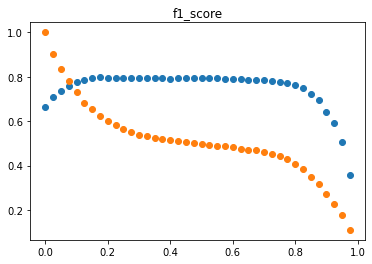

In [34]:
best_score, best_threshold = optimize_threshold(preds, test_set.state)
print(best_score, best_threshold)

In [ ]:
def making_sub(preds, threshold):
    preds = np.where(preds<threshold, 0, 1)
    
    df = pd.DataFrame(columns=["id", "state"])
    df["state"] = preds
    df["id"] = range(10545, 21089)
    return df

In [ ]:
sub_file = making_sub(preds, 0.45)
sub_file.to_csv(f"./sub_files/pseudo_lgbm_sub_{1}.csv", index=False, header=False)
plt.figure()
sub_file["state"].value_counts().plot(kind="bar")